In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
#import gym
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque
import random
import pdb
import plotly.express as px
import plotly.graph_objects as go
import pickle
import scipy.io
from matplotlib.font_manager import FontProperties
import pandas as pd
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from tqdm import tqdm
import matplotlib.animation as animation
import glob
from natsort import natsorted
from PIL import Image

def create_gif(pth, time_ind):
    #files = glob.glob(r"./imgs/*.png")
    files = glob.glob(os.path.join(pth,'*.png'))
    files = natsorted(files)
    image_array = []
    
    def update(i):
        im.set_array(image_array[i])
        return im, 
    
    for my_file in files:

        image = Image.open(my_file)
        image_array.append(image)
    
    # Create the figure and axes objects
    fig, ax = plt.subplots()

    # Set the initial image
    im = ax.imshow(image_array[0], animated=True)
    
    animation_fig = animation.FuncAnimation(fig, update, frames=len(image_array), interval=100, blit=True,repeat_delay=10,)

    # Show the animation
    #plt.show()

    #animation_fig.save("./imgs/animated_{}.gif".format(time_ind))
    animation_fig.save(os.path.join(pth,'animated_{}.gif').format(time_ind))
    pass

### Adding gamma_0 value for SINR computation ####

$\gamma = \frac{|h|_s^2P_t}{|h|_i^2P_t + N_0B}$

Assuming power transmitted power is same from all BSs then we have 

$\gamma = \frac{|h|_s^2}{|h|_i^2 + \frac{1}{\gamma_0}}$


where $\gamma_0 = P_t/N_0B$, you can assume P_t = 10 dBm, and the below calculations for $N_0$

In [2]:
## transmit power ###
Pt_dBm = 10  # Transmit power in dBm

#### Noise power ####
k = 1.38e-23  # Boltzmann's constant
T = 290       # Temperature in Kelvin
B = 10e6       # Bandwidth in Hz

# Calculate noise spectral density in Watts/Hz
Noise_spectral_density = k * T

# Convert noise spectral density to dBm/Hz
# Convert to Watts first then to dBm (1 mW = 0.001 W)
Noise_spectral_density_W = Noise_spectral_density * 1000  # Convert to mW
Noise_spectral_density_dBm = 10 * np.log10(Noise_spectral_density_W)
print('Noise_spectral_density_dBm', Noise_spectral_density_dBm)

# Calculate total noise power in Watts then convert to dBm
N_thermal = Noise_spectral_density * B  # Total noise power in Watts
N_thermal_dBm = 10 * np.log10(N_thermal * 1000)  # Convert noise power to dBm
print('thermal_noise_power(dBm)', N_thermal_dBm)

##### gamma_0 in dB ############
gamma_0_dB = Pt_dBm - N_thermal_dBm  # Calculate SNR in dB
#print('gamma_0 (dB)', gamma_0_dB)

##### gamma_0 ######
gamma_0 = np.power(10, gamma_0_dB/10)
print('1/gamma_0', 1/gamma_0)

Noise_spectral_density_dBm -173.97722915699805
thermal_noise_power(dBm) -103.97722915699808
1/gamma_0 4.001999999999999e-12


### 
CDF of SINR computed for F($\gamma$), for different channel realizations,
below is when the the device is at a mean distance of 1m from the serving BS with a standard deviation of 0.1 m, and mean distance from the interfering BS at 4 meters with std of 0.1m 

In [3]:
def return_cdf(a):
    sorted_a = np.sort(a)
    cdf = np.arange(1, len(sorted_a) + 1) / len(sorted_a)
    return sorted_a, cdf

In [4]:
############## Creating distances intra and inter ########
M = 5 # number of sub-networks 
Ts = 10000 # number of time slots
J = 5 # number of devices
f_c = 1.3 #GHz
N = 30
TxRxds = np.zeros((Ts, M, M*J))
d_intra = np.abs(np.random.normal(0.5,0.1,M*J))
d_intra = np.reshape(d_intra, (M,J))

In [5]:
def generate_random_point(grid_size):
    return np.random.uniform(0, grid_size, 2)

def generate_random_velocity():
    angle = np.random.uniform(0, 2 * np.pi)
    velocity = 11.11  # 40 km/h in m/s
    return np.array([velocity * np.cos(angle), velocity * np.sin(angle)])

def is_within_grid(point, grid_size):
    return all(0 <= coord <= grid_size for coord in point)

def handle_boundary_collisions(point, grid_size):
    angle = np.random.uniform(0, 2 * np.pi)
    velocity = 11.11
    if point[0] <= 0 or point[0] >= grid_size:
        angle = np.pi - angle if point[0] <= 0 else -angle
    if point[1] <= 0 or point[1] >= grid_size:
        angle = -np.pi / 2 - angle if point[1] <= 0 else np.pi / 2 - angle
    return np.array([velocity * np.cos(angle), velocity * np.sin(angle)])

def handle_ap_collisions(points, velocities, min_distance):
    for i in range(len(points)):
        for j in range(i + 1, len(points)):
            if np.linalg.norm(points[i] - points[j]) < min_distance:
                # Adjust direction randomly for both APs
                velocities[i] = generate_random_velocity()
                velocities[j] = generate_random_velocity()
    return velocities

def update_positions(points, velocities, tau, grid_size, min_distance):
    new_points = points + velocities * tau
    for i, point in enumerate(new_points):
        if not is_within_grid(point, grid_size):
            velocities[i] = handle_boundary_collisions(point, grid_size)
        new_points[i] = points[i] + velocities[i] * tau  # Recalculate with new velocity
    velocities = handle_ap_collisions(new_points, velocities, min_distance)
    return new_points, velocities

# Initialize parameters
grid_size = 20
num_points = M
min_distance = 2
tau = 0.01  # time interval in seconds

# Initialize points and velocities
points = np.array([generate_random_point(grid_size) for _ in range(num_points)])
velocities = np.array([generate_random_velocity() for _ in range(num_points)])
init_cents = points
# Simulation loop for 20 time steps
pth = r'C:\Users\sriniva3\OneDrive - Aalto University\Simulations\RL framework URLLC\RL framework_V2.0_DDPG\imgs'
#Ts = 1000
sub_net_cents = np.zeros((Ts+1, num_points, 2))
sub_net_cents[0] = init_cents
for step in tqdm(range(Ts-1)):
    points, velocities = update_positions(points, velocities, tau, grid_size, min_distance)
    sub_net_cents[step+1] = points
    '''
    # Plotting for visualization
    plt.figure(figsize=(3, 3))
    plt.scatter(points[:, 0], points[:, 1], c='red', label=f'Time Step {step+1}')
    plt.xlim(0, grid_size)
    plt.ylim(0, grid_size)
    plt.grid(True)
    plt.title(f'Access Points at Step {step+1}')
    plt.xlabel('Meters')
    plt.ylabel('Meters')
    #plt.legend()
    plt.savefig(os.path.join(pth, '{}.png'.format(step)))
    plt.close()
    #plt.show()
    ''';
#create_gif(pth, step)

100%|████████████████████████████████████████████████████████████████████████████| 9999/9999 [00:01<00:00, 8505.59it/s]


In [6]:
d_relative_locs = {}
for i in range(M):
    d_angle = np.random.uniform(0,2*np.pi,J) 
    d_r = np.random.uniform(0, 1, J)
    d_relative_locs[i] = np.vstack([d_r*np.cos(d_angle), d_r*np.sin(d_angle)])

In [7]:
def return_euclid_dist(device_x_coord, device_y_coord, AP_x_coord, AP_y_coord):
    device_coords = np.array([device_x_coord, device_y_coord])
    AP_coords = np.array([AP_x_coord, AP_y_coord])
    return np.linalg.norm(device_coords - AP_coords)

x_coords_ts, y_coords_ts = {}, {}
for ts in range(Ts):
    coords = sub_net_cents[ts]
    point_xs, point_ys = [], []
    for k in d_relative_locs.keys():
        point_x = d_relative_locs[k][0] + coords[k][0]
        point_y = d_relative_locs[k][1] + coords[k][1]
        #print(point_x, point_y)
        point_xs.append(point_x)
        point_ys.append(point_y)
    #break    
    x_coords_ts[ts] = point_xs
    y_coords_ts[ts] = point_ys

In [8]:
TxRxds = np.zeros((Ts, M, M*J))
for ts in range(Ts):
    device_x_coords, device_y_coords = np.array(x_coords_ts[ts]), np.array(y_coords_ts[ts])
    device_x_coords, device_y_coords = device_x_coords.flatten(), device_y_coords.flatten()
    AP_x_coords, AP_y_coords = sub_net_cents[ts][:,0], sub_net_cents[ts][:,1]
    
    #for dx in device_x_coords 
    dists = np.zeros((M,M*J))
    for i in range(AP_x_coords.shape[0]):
        dist = []
        for j in range(len(device_x_coords.flatten())):
            #dist = []
            #print(i,j)
            dist.append(return_euclid_dist(device_x_coords[j], device_y_coords[j], AP_x_coords[i], AP_y_coords[i]))
            #print(dist)
        dists[i] = np.array(dist)
    TxRxds[ts] = dists
    #break

#dist = return_euclid_dist(x_coords_ts[0], y_coords_ts[0], AP_x_coord, AP_y_coord)

(array([319595., 150298., 184248., 194347., 171806., 126134.,  80515.,
         18592.,   3535.,    930.]),
 array([1.85634796e-02, 3.21010779e+00, 6.40165210e+00, 9.59319641e+00,
        1.27847407e+01, 1.59762850e+01, 1.91678293e+01, 2.23593737e+01,
        2.55509180e+01, 2.87424623e+01, 3.19340066e+01]),
 <BarContainer object of 10 artists>)

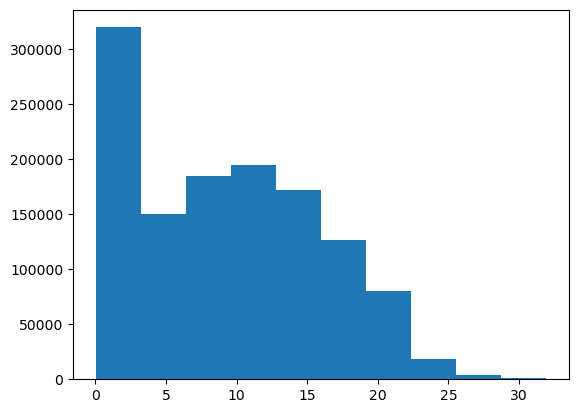

In [9]:
plt.hist(TxRxds.flatten())

In [10]:
TxRxds.shape

(10000, 5, 25)

### Using Jakes model 

In [11]:

def return_jakes_coeffcients(fd_max, TimeVaris, n_links = 5, plot = True):
    ff_gains, TimeSequences = [], []
    rays = 100
    for i in tqdm(range(n_links)):    
        #TimeVaris = np.arange(0,50,0.0005)
        #TimeVaris = np.arange(0,.2,0.005)
        frequs = np.sort(np.array([np.round(fd_max*np.cos(2*np.pi*np.random.uniform(0,1))) for _ in range(rays)]))
        phases = np.array([np.exp(1j*2*np.pi*np.random.uniform(0,1)) for _ in range(rays)])

        TimeSequence = []
        for t in TimeVaris:
            tab = np.exp(1j*2*np.pi*frequs*t)
            tabrot = tab*phases
            fun = np.sum(tabrot)
            TimeSequence.append(fun)
        TimeSequence = np.array(TimeSequence)

        #TimeSequence = TimeSequence/np.linalg.norm(TimeSequence)*np.sqrt(len(TimeSequence))
        PowerSequence1 =  np.abs(TimeSequence)**2;
        #plt.plot(TimeVaris[0:200], 10*np.log10(PowerSequence1)[0:200])
        ff_gains.append(PowerSequence1)
        TimeSequences.append(TimeSequence)
    ff_gains = np.array(ff_gains)/rays
    TimeSequences = np.array(TimeSequences)
    if plot:
        plt.plot(TimeVaris[0:200], 10*np.log10(ff_gains[0])[0:200])
        plt.show()
    return ff_gains, TimeSequences

v = 40 #kmph 
v_ms = v*5/18
c = 3*1e8
tau = .01
fd_max = v_ms*f_c*1e9/c
TimeVaris = np.arange(0,5,0.0005)

ff_gains, TimeSequences = return_jakes_coeffcients(fd_max, TimeVaris, n_links = M*(M-1)*J*N, plot = False)
#plt.plot(TimeVaris[0:Ts], 10*np.log10(ff_gains.flatten()[0:Ts]))
#plt.show()

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [13:56<00:00,  3.59it/s]


In [12]:
#np.save( 'ff_gains_3000.npy',ff_gains)
#ff_gains = np.load('ff_gains_3000.npy')

In [13]:
############ fast fading coeffecients ########

FastFadingChannels = np.random.normal(0,1/np.sqrt(2), M*J*N) + 1j*np.random.normal(0,1/np.sqrt(2), M*J*N)
FastFadingChannels = np.reshape(FastFadingChannels,(M,J,N))
FadingGains = np.abs(FastFadingChannels)**2
#all_SINRsdB, all_MeansPerSubNW, all_DiffsFromMean = np.zeros((Ts, M*J)), np.zeros((Ts, M)), np.zeros((Ts, M*J))
all_SINRsdB = np.zeros((Ts, M,J,N))
alltime_WantedSigPerDev, alltime_InterfPowsPerDev = [], []
for ts in range(Ts):
    

    #FadingGains.shape

    all_fast_fading_gains = np.zeros((M,M*J,N))
    for m in range(M):
        jakes_coeffs = ff_gains[:,ts]
        jakes_coeffs = np.reshape(jakes_coeffs,(M,(M-1)*J,N))
        all_fast_fading_gains[m] = np.concatenate([FadingGains[m], jakes_coeffs[m]])
    all_fast_fading_gains = np.array(all_fast_fading_gains)
    
    PL_los = 31.84 +21.5*np.log10(TxRxds[ts]) + 19*np.log10(f_c)
    PL = 33+25.5*np.log10(TxRxds[ts])+20*np.log10(f_c)
    PL_nlos = np.max((PL_los, PL), axis = 0)
    PathGains = np.power(10, -PL_nlos/10)
    PathGains = np.repeat(PathGains[:, :, np.newaxis], N, axis=2)

    ##### Compute total path gains ########
    #pdb.set_trace()
    PathGainsTot = PathGains*all_fast_fading_gains

    #### Compute WantedSigPerDev ######
    WantedSigPerDev = np.zeros((M,J,N))
    for m in range(M):
        WantedSigPerDev[m] = PathGainsTot[m,m*J:(m+1)*J]
    alltime_WantedSigPerDev.append(WantedSigPerDev)
    InterfPowsPerDev = np.zeros((M,J,N))
    for m in range(M):
        Interferers = [i for i in range(M) if i!=m]
        Devs = np.arange(m*J,(m+1)*J)
        #print(Interferers, Devs)
        InterfPowGains = PathGainsTot[np.ix_(Interferers, Devs)]
        InterfPowsPerDev[m,] = np.sum(InterfPowGains, axis = 0)
    alltime_InterfPowsPerDev.append(InterfPowsPerDev)
    SINRs = WantedSigPerDev/(InterfPowsPerDev + 1/gamma_0);
    SINRsdB = 10*np.log10(SINRs)
    all_SINRsdB[ts,:] = SINRsdB
alltime_WantedSigPerDev = np.array(alltime_WantedSigPerDev)
alltime_InterfPowsPerDev = np.array(alltime_InterfPowsPerDev)

In [14]:
WantedSigPerDev.shape

(5, 5, 30)

22.665782185618824


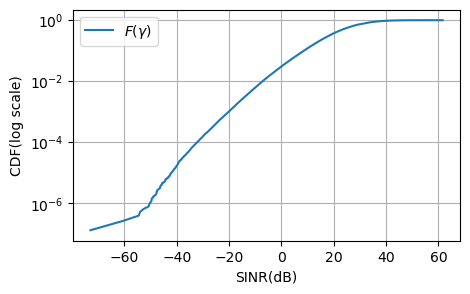

In [15]:
a1, cdf1 = return_cdf(all_SINRsdB.flatten())
plt.figure(figsize= [5,3])
#plt.ylim(np.min(cdf2))
plt.semilogy(a1, cdf1, label = r'$F(\gamma)$')
plt.grid()
plt.xlabel('SINR(dB)')
plt.ylabel('CDF(log scale)')
plt.legend()
print(np.mean(all_SINRsdB.flatten()))

In [16]:
PathGainsTot.shape

(5, 25, 30)

In [17]:
InterfPowGains.shape

(4, 5, 30)

6.477376376460374


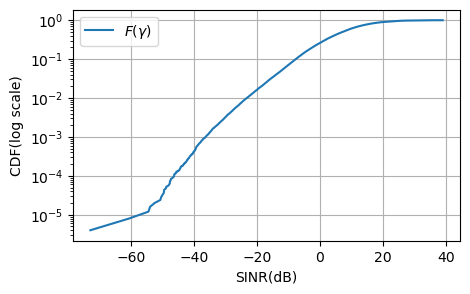

In [18]:
alltime_SINRsdB_combined = []
all_SINRslin = np.power(10, all_SINRsdB/10)
for ts in range(all_SINRsdB.shape[0]):
    vals = all_SINRslin[ts,:,:,:]
    SINRS_combined = np.min(vals, axis = 2)
    SINRsdB_combined = 10*np.log10(SINRS_combined)
    alltime_SINRsdB_combined.append(SINRsdB_combined)
alltime_SINRsdB_combined = np.array(alltime_SINRsdB_combined)

a1, cdf1 = return_cdf(alltime_SINRsdB_combined.flatten())
plt.figure(figsize= [5,3])
#plt.ylim(np.min(cdf2))
plt.semilogy(a1, cdf1, label = r'$F(\gamma)$')
plt.grid()
plt.xlabel('SINR(dB)')
plt.ylabel('CDF(log scale)')
plt.legend()
print(np.mean(alltime_SINRsdB_combined.flatten()))

In [19]:
all_SINRsdB.shape

(10000, 5, 5, 30)

### The below model needs to be integrated with DRL framework trained paralelly. 


##### prediction of SINR at t given 10 previous time slots #########
####### 10000 x 5x 5 x 30, 10000 is time slots, first 5 denotes the sub networks, 2nd 5 denotes the devices of a sub network, 
####### 30 denotes the channel resources. 


#### preparing data for a sub-network ########
######## each sub-network will have one LSTM layer getting trained in parallel with the main DRL agent ########
######### i.e., the LSTM layer is trained for a given example with a loss function and predicted SINR is given as the 
######### input to the DRL framework which is subsequently trained. This happens in an online fashion at every time-slot.

In [20]:
## data for a sub-network 
lag = 10
inp_data, out_data = [], []
for i in range(M):
    sinr_sub_nw = all_SINRsdB[:,0,:,:]
    data_per_device = sinr_sub_nw[:,0,:]
    for t in range(0, len(data_per_device)-lag):
        inp_data.append(data_per_device[t:t+lag])
        out_data.append(data_per_device[t+lag])

    
inp_data = np.array(inp_data)
out_data = np.array(out_data)

In [21]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # Define the LSTM layer
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        
        # Define the output layer
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        
        # Initialize cell state with zeros
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))
        
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

In [22]:
samp_no =47000
inp_train_data = inp_data[0:samp_no]
out_train_data = out_data[0:samp_no]
inp_test_data = inp_data[samp_no:]
out_test_data = out_data[samp_no:]

# Convert numpy arrays to PyTorch tensors
inp_train_data = torch.tensor(inp_train_data, dtype=torch.float32)
out_train_data = torch.tensor(out_train_data, dtype=torch.float32)
inp_test_data = torch.tensor(inp_test_data, dtype=torch.float32)
out_test_data = torch.tensor(out_test_data, dtype=torch.float32)


inp_test_data 
# Create a dataset and dataloader
train_dataset = TensorDataset(inp_train_data, out_train_data)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)


In [23]:
# Set device (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Model parameters
input_dim = N
hidden_dim = 128
output_dim = N
num_layers = 1
num_epochs = 50
learning_rate = 1e-3

# Initialize the model, loss function and optimizer
model = LSTMModel(input_dim, hidden_dim, output_dim, num_layers).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
epoch_loss = []
# Training loop
for epoch in range(num_epochs):
    for i, (inputs, targets) in enumerate(train_loader):
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss.append(loss.item())
        #if (i+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')


Epoch [1/50], Step [1/735], Loss: 360.2106
Epoch [1/50], Step [2/735], Loss: 419.9127
Epoch [1/50], Step [3/735], Loss: 460.9243
Epoch [1/50], Step [4/735], Loss: 393.0578
Epoch [1/50], Step [5/735], Loss: 349.0497
Epoch [1/50], Step [6/735], Loss: 373.7418
Epoch [1/50], Step [7/735], Loss: 429.3665
Epoch [1/50], Step [8/735], Loss: 432.6199
Epoch [1/50], Step [9/735], Loss: 462.6012
Epoch [1/50], Step [10/735], Loss: 363.7121
Epoch [1/50], Step [11/735], Loss: 423.8451
Epoch [1/50], Step [12/735], Loss: 391.1205
Epoch [1/50], Step [13/735], Loss: 353.3471
Epoch [1/50], Step [14/735], Loss: 448.4174
Epoch [1/50], Step [15/735], Loss: 397.7729
Epoch [1/50], Step [16/735], Loss: 425.0495
Epoch [1/50], Step [17/735], Loss: 388.6484
Epoch [1/50], Step [18/735], Loss: 348.9367
Epoch [1/50], Step [19/735], Loss: 420.4949
Epoch [1/50], Step [20/735], Loss: 365.2315
Epoch [1/50], Step [21/735], Loss: 382.2322
Epoch [1/50], Step [22/735], Loss: 380.9889
Epoch [1/50], Step [23/735], Loss: 385.17

Epoch [1/50], Step [196/735], Loss: 34.5719
Epoch [1/50], Step [197/735], Loss: 36.4392
Epoch [1/50], Step [198/735], Loss: 42.2020
Epoch [1/50], Step [199/735], Loss: 39.2764
Epoch [1/50], Step [200/735], Loss: 40.6987
Epoch [1/50], Step [201/735], Loss: 34.2321
Epoch [1/50], Step [202/735], Loss: 39.5953
Epoch [1/50], Step [203/735], Loss: 29.2673
Epoch [1/50], Step [204/735], Loss: 37.2505
Epoch [1/50], Step [205/735], Loss: 37.9583
Epoch [1/50], Step [206/735], Loss: 33.7463
Epoch [1/50], Step [207/735], Loss: 24.7649
Epoch [1/50], Step [208/735], Loss: 32.8536
Epoch [1/50], Step [209/735], Loss: 27.6626
Epoch [1/50], Step [210/735], Loss: 34.5913
Epoch [1/50], Step [211/735], Loss: 31.6205
Epoch [1/50], Step [212/735], Loss: 39.8463
Epoch [1/50], Step [213/735], Loss: 34.5372
Epoch [1/50], Step [214/735], Loss: 34.0405
Epoch [1/50], Step [215/735], Loss: 32.5225
Epoch [1/50], Step [216/735], Loss: 24.8937
Epoch [1/50], Step [217/735], Loss: 27.9112
Epoch [1/50], Step [218/735], Lo

Epoch [1/50], Step [386/735], Loss: 10.1100
Epoch [1/50], Step [387/735], Loss: 9.7544
Epoch [1/50], Step [388/735], Loss: 13.5454
Epoch [1/50], Step [389/735], Loss: 12.2319
Epoch [1/50], Step [390/735], Loss: 7.9498
Epoch [1/50], Step [391/735], Loss: 18.9788
Epoch [1/50], Step [392/735], Loss: 7.4606
Epoch [1/50], Step [393/735], Loss: 11.2141
Epoch [1/50], Step [394/735], Loss: 10.9117
Epoch [1/50], Step [395/735], Loss: 9.1747
Epoch [1/50], Step [396/735], Loss: 8.5345
Epoch [1/50], Step [397/735], Loss: 10.9488
Epoch [1/50], Step [398/735], Loss: 8.7787
Epoch [1/50], Step [399/735], Loss: 8.0330
Epoch [1/50], Step [400/735], Loss: 7.3957
Epoch [1/50], Step [401/735], Loss: 10.3376
Epoch [1/50], Step [402/735], Loss: 8.7961
Epoch [1/50], Step [403/735], Loss: 9.5909
Epoch [1/50], Step [404/735], Loss: 10.6753
Epoch [1/50], Step [405/735], Loss: 6.8159
Epoch [1/50], Step [406/735], Loss: 8.3551
Epoch [1/50], Step [407/735], Loss: 9.5742
Epoch [1/50], Step [408/735], Loss: 9.7315
Ep

Epoch [1/50], Step [588/735], Loss: 4.7540
Epoch [1/50], Step [589/735], Loss: 4.2767
Epoch [1/50], Step [590/735], Loss: 6.9269
Epoch [1/50], Step [591/735], Loss: 5.0083
Epoch [1/50], Step [592/735], Loss: 3.7854
Epoch [1/50], Step [593/735], Loss: 5.0346
Epoch [1/50], Step [594/735], Loss: 5.3034
Epoch [1/50], Step [595/735], Loss: 5.9794
Epoch [1/50], Step [596/735], Loss: 5.5145
Epoch [1/50], Step [597/735], Loss: 4.9932
Epoch [1/50], Step [598/735], Loss: 4.9878
Epoch [1/50], Step [599/735], Loss: 4.1369
Epoch [1/50], Step [600/735], Loss: 7.6992
Epoch [1/50], Step [601/735], Loss: 4.8890
Epoch [1/50], Step [602/735], Loss: 4.2851
Epoch [1/50], Step [603/735], Loss: 4.7802
Epoch [1/50], Step [604/735], Loss: 4.8132
Epoch [1/50], Step [605/735], Loss: 4.2607
Epoch [1/50], Step [606/735], Loss: 4.7504
Epoch [1/50], Step [607/735], Loss: 3.6847
Epoch [1/50], Step [608/735], Loss: 4.9891
Epoch [1/50], Step [609/735], Loss: 3.5872
Epoch [1/50], Step [610/735], Loss: 4.8545
Epoch [1/50

Epoch [2/50], Step [52/735], Loss: 2.8056
Epoch [2/50], Step [53/735], Loss: 2.7527
Epoch [2/50], Step [54/735], Loss: 2.2329
Epoch [2/50], Step [55/735], Loss: 3.1465
Epoch [2/50], Step [56/735], Loss: 3.3482
Epoch [2/50], Step [57/735], Loss: 2.4447
Epoch [2/50], Step [58/735], Loss: 2.0883
Epoch [2/50], Step [59/735], Loss: 2.0060
Epoch [2/50], Step [60/735], Loss: 2.5854
Epoch [2/50], Step [61/735], Loss: 3.2410
Epoch [2/50], Step [62/735], Loss: 2.1723
Epoch [2/50], Step [63/735], Loss: 3.6038
Epoch [2/50], Step [64/735], Loss: 1.9019
Epoch [2/50], Step [65/735], Loss: 3.8567
Epoch [2/50], Step [66/735], Loss: 3.4782
Epoch [2/50], Step [67/735], Loss: 4.5999
Epoch [2/50], Step [68/735], Loss: 2.9931
Epoch [2/50], Step [69/735], Loss: 3.6723
Epoch [2/50], Step [70/735], Loss: 4.0516
Epoch [2/50], Step [71/735], Loss: 3.3371
Epoch [2/50], Step [72/735], Loss: 2.0646
Epoch [2/50], Step [73/735], Loss: 2.7681
Epoch [2/50], Step [74/735], Loss: 5.2787
Epoch [2/50], Step [75/735], Loss:

Epoch [2/50], Step [254/735], Loss: 1.5118
Epoch [2/50], Step [255/735], Loss: 2.5394
Epoch [2/50], Step [256/735], Loss: 7.9725
Epoch [2/50], Step [257/735], Loss: 2.6612
Epoch [2/50], Step [258/735], Loss: 1.3710
Epoch [2/50], Step [259/735], Loss: 1.2406
Epoch [2/50], Step [260/735], Loss: 2.0112
Epoch [2/50], Step [261/735], Loss: 1.7846
Epoch [2/50], Step [262/735], Loss: 1.7775
Epoch [2/50], Step [263/735], Loss: 2.4635
Epoch [2/50], Step [264/735], Loss: 1.6492
Epoch [2/50], Step [265/735], Loss: 4.5329
Epoch [2/50], Step [266/735], Loss: 1.5199
Epoch [2/50], Step [267/735], Loss: 2.1455
Epoch [2/50], Step [268/735], Loss: 2.2936
Epoch [2/50], Step [269/735], Loss: 1.6967
Epoch [2/50], Step [270/735], Loss: 2.0442
Epoch [2/50], Step [271/735], Loss: 1.9008
Epoch [2/50], Step [272/735], Loss: 1.6164
Epoch [2/50], Step [273/735], Loss: 1.8225
Epoch [2/50], Step [274/735], Loss: 1.8823
Epoch [2/50], Step [275/735], Loss: 1.6507
Epoch [2/50], Step [276/735], Loss: 2.0866
Epoch [2/50

Epoch [2/50], Step [458/735], Loss: 0.7492
Epoch [2/50], Step [459/735], Loss: 1.3506
Epoch [2/50], Step [460/735], Loss: 0.9913
Epoch [2/50], Step [461/735], Loss: 0.9662
Epoch [2/50], Step [462/735], Loss: 1.4548
Epoch [2/50], Step [463/735], Loss: 0.7168
Epoch [2/50], Step [464/735], Loss: 1.2122
Epoch [2/50], Step [465/735], Loss: 0.7508
Epoch [2/50], Step [466/735], Loss: 1.0305
Epoch [2/50], Step [467/735], Loss: 1.3538
Epoch [2/50], Step [468/735], Loss: 0.9559
Epoch [2/50], Step [469/735], Loss: 1.6418
Epoch [2/50], Step [470/735], Loss: 1.3872
Epoch [2/50], Step [471/735], Loss: 1.4857
Epoch [2/50], Step [472/735], Loss: 1.6891
Epoch [2/50], Step [473/735], Loss: 1.5200
Epoch [2/50], Step [474/735], Loss: 0.8482
Epoch [2/50], Step [475/735], Loss: 1.9498
Epoch [2/50], Step [476/735], Loss: 2.4794
Epoch [2/50], Step [477/735], Loss: 1.4110
Epoch [2/50], Step [478/735], Loss: 1.9189
Epoch [2/50], Step [479/735], Loss: 1.3614
Epoch [2/50], Step [480/735], Loss: 1.0311
Epoch [2/50

Epoch [2/50], Step [664/735], Loss: 1.4044
Epoch [2/50], Step [665/735], Loss: 1.2387
Epoch [2/50], Step [666/735], Loss: 1.3291
Epoch [2/50], Step [667/735], Loss: 0.9719
Epoch [2/50], Step [668/735], Loss: 0.8890
Epoch [2/50], Step [669/735], Loss: 0.4742
Epoch [2/50], Step [670/735], Loss: 0.7185
Epoch [2/50], Step [671/735], Loss: 0.8016
Epoch [2/50], Step [672/735], Loss: 1.2530
Epoch [2/50], Step [673/735], Loss: 0.6350
Epoch [2/50], Step [674/735], Loss: 1.7829
Epoch [2/50], Step [675/735], Loss: 1.4239
Epoch [2/50], Step [676/735], Loss: 1.2370
Epoch [2/50], Step [677/735], Loss: 0.8508
Epoch [2/50], Step [678/735], Loss: 0.7068
Epoch [2/50], Step [679/735], Loss: 1.0493
Epoch [2/50], Step [680/735], Loss: 0.8449
Epoch [2/50], Step [681/735], Loss: 0.9825
Epoch [2/50], Step [682/735], Loss: 1.1594
Epoch [2/50], Step [683/735], Loss: 1.1758
Epoch [2/50], Step [684/735], Loss: 0.7941
Epoch [2/50], Step [685/735], Loss: 1.0227
Epoch [2/50], Step [686/735], Loss: 0.8800
Epoch [2/50

Epoch [3/50], Step [123/735], Loss: 0.6018
Epoch [3/50], Step [124/735], Loss: 0.5953
Epoch [3/50], Step [125/735], Loss: 0.9089
Epoch [3/50], Step [126/735], Loss: 1.0033
Epoch [3/50], Step [127/735], Loss: 0.9701
Epoch [3/50], Step [128/735], Loss: 1.0314
Epoch [3/50], Step [129/735], Loss: 0.4477
Epoch [3/50], Step [130/735], Loss: 0.3828
Epoch [3/50], Step [131/735], Loss: 1.4011
Epoch [3/50], Step [132/735], Loss: 0.5713
Epoch [3/50], Step [133/735], Loss: 2.0878
Epoch [3/50], Step [134/735], Loss: 1.2895
Epoch [3/50], Step [135/735], Loss: 1.2988
Epoch [3/50], Step [136/735], Loss: 0.7587
Epoch [3/50], Step [137/735], Loss: 0.6795
Epoch [3/50], Step [138/735], Loss: 0.5851
Epoch [3/50], Step [139/735], Loss: 0.3222
Epoch [3/50], Step [140/735], Loss: 0.6459
Epoch [3/50], Step [141/735], Loss: 0.7245
Epoch [3/50], Step [142/735], Loss: 0.5650
Epoch [3/50], Step [143/735], Loss: 0.5066
Epoch [3/50], Step [144/735], Loss: 0.7564
Epoch [3/50], Step [145/735], Loss: 1.0064
Epoch [3/50

Epoch [3/50], Step [325/735], Loss: 0.3626
Epoch [3/50], Step [326/735], Loss: 0.4525
Epoch [3/50], Step [327/735], Loss: 0.6559
Epoch [3/50], Step [328/735], Loss: 0.6844
Epoch [3/50], Step [329/735], Loss: 0.4897
Epoch [3/50], Step [330/735], Loss: 0.8145
Epoch [3/50], Step [331/735], Loss: 0.5772
Epoch [3/50], Step [332/735], Loss: 1.3225
Epoch [3/50], Step [333/735], Loss: 0.3836
Epoch [3/50], Step [334/735], Loss: 0.4778
Epoch [3/50], Step [335/735], Loss: 1.0271
Epoch [3/50], Step [336/735], Loss: 0.9793
Epoch [3/50], Step [337/735], Loss: 0.4298
Epoch [3/50], Step [338/735], Loss: 0.7914
Epoch [3/50], Step [339/735], Loss: 0.6902
Epoch [3/50], Step [340/735], Loss: 0.6282
Epoch [3/50], Step [341/735], Loss: 0.5231
Epoch [3/50], Step [342/735], Loss: 0.8152
Epoch [3/50], Step [343/735], Loss: 0.3816
Epoch [3/50], Step [344/735], Loss: 3.0619
Epoch [3/50], Step [345/735], Loss: 1.4963
Epoch [3/50], Step [346/735], Loss: 0.6020
Epoch [3/50], Step [347/735], Loss: 0.5603
Epoch [3/50

Epoch [3/50], Step [523/735], Loss: 0.6732
Epoch [3/50], Step [524/735], Loss: 1.0302
Epoch [3/50], Step [525/735], Loss: 1.7614
Epoch [3/50], Step [526/735], Loss: 0.3762
Epoch [3/50], Step [527/735], Loss: 0.4577
Epoch [3/50], Step [528/735], Loss: 0.5969
Epoch [3/50], Step [529/735], Loss: 0.4602
Epoch [3/50], Step [530/735], Loss: 2.4991
Epoch [3/50], Step [531/735], Loss: 1.7748
Epoch [3/50], Step [532/735], Loss: 0.8853
Epoch [3/50], Step [533/735], Loss: 0.3939
Epoch [3/50], Step [534/735], Loss: 1.3662
Epoch [3/50], Step [535/735], Loss: 0.3817
Epoch [3/50], Step [536/735], Loss: 0.6075
Epoch [3/50], Step [537/735], Loss: 2.7441
Epoch [3/50], Step [538/735], Loss: 0.3647
Epoch [3/50], Step [539/735], Loss: 1.5566
Epoch [3/50], Step [540/735], Loss: 1.0377
Epoch [3/50], Step [541/735], Loss: 0.6912
Epoch [3/50], Step [542/735], Loss: 0.7751
Epoch [3/50], Step [543/735], Loss: 0.4565
Epoch [3/50], Step [544/735], Loss: 0.4947
Epoch [3/50], Step [545/735], Loss: 0.8714
Epoch [3/50

Epoch [3/50], Step [728/735], Loss: 0.3766
Epoch [3/50], Step [729/735], Loss: 0.3174
Epoch [3/50], Step [730/735], Loss: 0.4805
Epoch [3/50], Step [731/735], Loss: 0.1952
Epoch [3/50], Step [732/735], Loss: 0.2244
Epoch [3/50], Step [733/735], Loss: 0.4813
Epoch [3/50], Step [734/735], Loss: 0.5831
Epoch [3/50], Step [735/735], Loss: 0.1648
Epoch [4/50], Step [1/735], Loss: 0.3501
Epoch [4/50], Step [2/735], Loss: 0.2346
Epoch [4/50], Step [3/735], Loss: 0.3955
Epoch [4/50], Step [4/735], Loss: 0.6053
Epoch [4/50], Step [5/735], Loss: 0.2598
Epoch [4/50], Step [6/735], Loss: 0.6155
Epoch [4/50], Step [7/735], Loss: 0.7914
Epoch [4/50], Step [8/735], Loss: 5.3821
Epoch [4/50], Step [9/735], Loss: 0.9160
Epoch [4/50], Step [10/735], Loss: 0.3141
Epoch [4/50], Step [11/735], Loss: 5.6722
Epoch [4/50], Step [12/735], Loss: 0.6137
Epoch [4/50], Step [13/735], Loss: 0.8754
Epoch [4/50], Step [14/735], Loss: 0.8101
Epoch [4/50], Step [15/735], Loss: 0.4000
Epoch [4/50], Step [16/735], Loss: 

Epoch [4/50], Step [194/735], Loss: 0.8895
Epoch [4/50], Step [195/735], Loss: 0.6220
Epoch [4/50], Step [196/735], Loss: 0.7376
Epoch [4/50], Step [197/735], Loss: 0.9686
Epoch [4/50], Step [198/735], Loss: 0.7278
Epoch [4/50], Step [199/735], Loss: 0.3740
Epoch [4/50], Step [200/735], Loss: 0.1917
Epoch [4/50], Step [201/735], Loss: 0.1994
Epoch [4/50], Step [202/735], Loss: 1.7226
Epoch [4/50], Step [203/735], Loss: 1.4621
Epoch [4/50], Step [204/735], Loss: 0.4175
Epoch [4/50], Step [205/735], Loss: 0.9448
Epoch [4/50], Step [206/735], Loss: 1.3783
Epoch [4/50], Step [207/735], Loss: 0.5307
Epoch [4/50], Step [208/735], Loss: 0.5947
Epoch [4/50], Step [209/735], Loss: 0.8427
Epoch [4/50], Step [210/735], Loss: 0.5916
Epoch [4/50], Step [211/735], Loss: 0.5531
Epoch [4/50], Step [212/735], Loss: 0.5340
Epoch [4/50], Step [213/735], Loss: 0.5265
Epoch [4/50], Step [214/735], Loss: 0.9627
Epoch [4/50], Step [215/735], Loss: 0.5205
Epoch [4/50], Step [216/735], Loss: 0.5492
Epoch [4/50

Epoch [4/50], Step [390/735], Loss: 0.2989
Epoch [4/50], Step [391/735], Loss: 0.1911
Epoch [4/50], Step [392/735], Loss: 0.3392
Epoch [4/50], Step [393/735], Loss: 0.5328
Epoch [4/50], Step [394/735], Loss: 0.9325
Epoch [4/50], Step [395/735], Loss: 0.5170
Epoch [4/50], Step [396/735], Loss: 0.2445
Epoch [4/50], Step [397/735], Loss: 0.5239
Epoch [4/50], Step [398/735], Loss: 0.7056
Epoch [4/50], Step [399/735], Loss: 1.0331
Epoch [4/50], Step [400/735], Loss: 1.4465
Epoch [4/50], Step [401/735], Loss: 0.2357
Epoch [4/50], Step [402/735], Loss: 1.0918
Epoch [4/50], Step [403/735], Loss: 0.3113
Epoch [4/50], Step [404/735], Loss: 0.3073
Epoch [4/50], Step [405/735], Loss: 0.2336
Epoch [4/50], Step [406/735], Loss: 0.9773
Epoch [4/50], Step [407/735], Loss: 0.6935
Epoch [4/50], Step [408/735], Loss: 0.6639
Epoch [4/50], Step [409/735], Loss: 0.8302
Epoch [4/50], Step [410/735], Loss: 0.6234
Epoch [4/50], Step [411/735], Loss: 0.3576
Epoch [4/50], Step [412/735], Loss: 0.9122
Epoch [4/50

Epoch [4/50], Step [587/735], Loss: 0.2803
Epoch [4/50], Step [588/735], Loss: 0.2775
Epoch [4/50], Step [589/735], Loss: 0.6128
Epoch [4/50], Step [590/735], Loss: 0.3620
Epoch [4/50], Step [591/735], Loss: 0.3198
Epoch [4/50], Step [592/735], Loss: 2.7347
Epoch [4/50], Step [593/735], Loss: 2.9540
Epoch [4/50], Step [594/735], Loss: 0.5180
Epoch [4/50], Step [595/735], Loss: 0.2564
Epoch [4/50], Step [596/735], Loss: 0.2104
Epoch [4/50], Step [597/735], Loss: 0.3600
Epoch [4/50], Step [598/735], Loss: 0.6527
Epoch [4/50], Step [599/735], Loss: 0.3096
Epoch [4/50], Step [600/735], Loss: 0.3960
Epoch [4/50], Step [601/735], Loss: 0.2906
Epoch [4/50], Step [602/735], Loss: 2.0949
Epoch [4/50], Step [603/735], Loss: 0.9289
Epoch [4/50], Step [604/735], Loss: 1.2098
Epoch [4/50], Step [605/735], Loss: 0.8614
Epoch [4/50], Step [606/735], Loss: 0.2512
Epoch [4/50], Step [607/735], Loss: 0.7562
Epoch [4/50], Step [608/735], Loss: 1.5977
Epoch [4/50], Step [609/735], Loss: 0.2937
Epoch [4/50

Epoch [5/50], Step [56/735], Loss: 0.4434
Epoch [5/50], Step [57/735], Loss: 0.3197
Epoch [5/50], Step [58/735], Loss: 0.3272
Epoch [5/50], Step [59/735], Loss: 0.2071
Epoch [5/50], Step [60/735], Loss: 0.4953
Epoch [5/50], Step [61/735], Loss: 0.2386
Epoch [5/50], Step [62/735], Loss: 1.1492
Epoch [5/50], Step [63/735], Loss: 0.4199
Epoch [5/50], Step [64/735], Loss: 0.6565
Epoch [5/50], Step [65/735], Loss: 1.2498
Epoch [5/50], Step [66/735], Loss: 0.4859
Epoch [5/50], Step [67/735], Loss: 0.9496
Epoch [5/50], Step [68/735], Loss: 0.5879
Epoch [5/50], Step [69/735], Loss: 0.4219
Epoch [5/50], Step [70/735], Loss: 1.1540
Epoch [5/50], Step [71/735], Loss: 0.7268
Epoch [5/50], Step [72/735], Loss: 1.1251
Epoch [5/50], Step [73/735], Loss: 0.5524
Epoch [5/50], Step [74/735], Loss: 0.2129
Epoch [5/50], Step [75/735], Loss: 1.4891
Epoch [5/50], Step [76/735], Loss: 0.3044
Epoch [5/50], Step [77/735], Loss: 0.9764
Epoch [5/50], Step [78/735], Loss: 4.9570
Epoch [5/50], Step [79/735], Loss:

Epoch [5/50], Step [257/735], Loss: 0.5188
Epoch [5/50], Step [258/735], Loss: 0.9980
Epoch [5/50], Step [259/735], Loss: 0.4594
Epoch [5/50], Step [260/735], Loss: 0.4410
Epoch [5/50], Step [261/735], Loss: 0.9096
Epoch [5/50], Step [262/735], Loss: 0.8371
Epoch [5/50], Step [263/735], Loss: 0.9777
Epoch [5/50], Step [264/735], Loss: 0.5950
Epoch [5/50], Step [265/735], Loss: 0.7229
Epoch [5/50], Step [266/735], Loss: 0.2835
Epoch [5/50], Step [267/735], Loss: 0.4006
Epoch [5/50], Step [268/735], Loss: 0.2377
Epoch [5/50], Step [269/735], Loss: 1.0191
Epoch [5/50], Step [270/735], Loss: 0.9894
Epoch [5/50], Step [271/735], Loss: 1.2082
Epoch [5/50], Step [272/735], Loss: 0.4905
Epoch [5/50], Step [273/735], Loss: 0.3202
Epoch [5/50], Step [274/735], Loss: 0.2978
Epoch [5/50], Step [275/735], Loss: 0.4339
Epoch [5/50], Step [276/735], Loss: 0.5334
Epoch [5/50], Step [277/735], Loss: 0.2986
Epoch [5/50], Step [278/735], Loss: 0.3957
Epoch [5/50], Step [279/735], Loss: 0.4759
Epoch [5/50

Epoch [5/50], Step [456/735], Loss: 0.6307
Epoch [5/50], Step [457/735], Loss: 0.6823
Epoch [5/50], Step [458/735], Loss: 0.2662
Epoch [5/50], Step [459/735], Loss: 0.7159
Epoch [5/50], Step [460/735], Loss: 0.6222
Epoch [5/50], Step [461/735], Loss: 0.5612
Epoch [5/50], Step [462/735], Loss: 0.5026
Epoch [5/50], Step [463/735], Loss: 0.1491
Epoch [5/50], Step [464/735], Loss: 0.1937
Epoch [5/50], Step [465/735], Loss: 0.4038
Epoch [5/50], Step [466/735], Loss: 0.7329
Epoch [5/50], Step [467/735], Loss: 0.2579
Epoch [5/50], Step [468/735], Loss: 0.6122
Epoch [5/50], Step [469/735], Loss: 0.4358
Epoch [5/50], Step [470/735], Loss: 0.6443
Epoch [5/50], Step [471/735], Loss: 1.4014
Epoch [5/50], Step [472/735], Loss: 0.2555
Epoch [5/50], Step [473/735], Loss: 0.4004
Epoch [5/50], Step [474/735], Loss: 0.4463
Epoch [5/50], Step [475/735], Loss: 0.4826
Epoch [5/50], Step [476/735], Loss: 0.3596
Epoch [5/50], Step [477/735], Loss: 0.2932
Epoch [5/50], Step [478/735], Loss: 0.3483
Epoch [5/50

Epoch [5/50], Step [650/735], Loss: 0.4036
Epoch [5/50], Step [651/735], Loss: 0.3833
Epoch [5/50], Step [652/735], Loss: 0.3635
Epoch [5/50], Step [653/735], Loss: 0.4496
Epoch [5/50], Step [654/735], Loss: 0.2999
Epoch [5/50], Step [655/735], Loss: 0.2769
Epoch [5/50], Step [656/735], Loss: 0.3237
Epoch [5/50], Step [657/735], Loss: 0.8767
Epoch [5/50], Step [658/735], Loss: 0.1934
Epoch [5/50], Step [659/735], Loss: 0.2505
Epoch [5/50], Step [660/735], Loss: 0.6097
Epoch [5/50], Step [661/735], Loss: 0.1863
Epoch [5/50], Step [662/735], Loss: 0.2839
Epoch [5/50], Step [663/735], Loss: 0.5248
Epoch [5/50], Step [664/735], Loss: 0.4119
Epoch [5/50], Step [665/735], Loss: 0.2406
Epoch [5/50], Step [666/735], Loss: 0.3467
Epoch [5/50], Step [667/735], Loss: 0.1138
Epoch [5/50], Step [668/735], Loss: 0.8906
Epoch [5/50], Step [669/735], Loss: 0.6956
Epoch [5/50], Step [670/735], Loss: 0.4146
Epoch [5/50], Step [671/735], Loss: 0.1218
Epoch [5/50], Step [672/735], Loss: 0.1093
Epoch [5/50

Epoch [6/50], Step [114/735], Loss: 0.2962
Epoch [6/50], Step [115/735], Loss: 0.5557
Epoch [6/50], Step [116/735], Loss: 0.3909
Epoch [6/50], Step [117/735], Loss: 0.3125
Epoch [6/50], Step [118/735], Loss: 0.1805
Epoch [6/50], Step [119/735], Loss: 0.1597
Epoch [6/50], Step [120/735], Loss: 0.7283
Epoch [6/50], Step [121/735], Loss: 1.1534
Epoch [6/50], Step [122/735], Loss: 0.4829
Epoch [6/50], Step [123/735], Loss: 0.2947
Epoch [6/50], Step [124/735], Loss: 0.2626
Epoch [6/50], Step [125/735], Loss: 0.7577
Epoch [6/50], Step [126/735], Loss: 0.5138
Epoch [6/50], Step [127/735], Loss: 0.8943
Epoch [6/50], Step [128/735], Loss: 0.1858
Epoch [6/50], Step [129/735], Loss: 0.3177
Epoch [6/50], Step [130/735], Loss: 0.3178
Epoch [6/50], Step [131/735], Loss: 0.5995
Epoch [6/50], Step [132/735], Loss: 0.4850
Epoch [6/50], Step [133/735], Loss: 0.4016
Epoch [6/50], Step [134/735], Loss: 0.3674
Epoch [6/50], Step [135/735], Loss: 0.4900
Epoch [6/50], Step [136/735], Loss: 0.0941
Epoch [6/50

Epoch [6/50], Step [306/735], Loss: 0.3498
Epoch [6/50], Step [307/735], Loss: 0.2725
Epoch [6/50], Step [308/735], Loss: 0.3580
Epoch [6/50], Step [309/735], Loss: 0.6167
Epoch [6/50], Step [310/735], Loss: 1.1123
Epoch [6/50], Step [311/735], Loss: 0.4933
Epoch [6/50], Step [312/735], Loss: 0.3132
Epoch [6/50], Step [313/735], Loss: 0.3105
Epoch [6/50], Step [314/735], Loss: 0.1882
Epoch [6/50], Step [315/735], Loss: 0.2110
Epoch [6/50], Step [316/735], Loss: 0.5053
Epoch [6/50], Step [317/735], Loss: 0.2742
Epoch [6/50], Step [318/735], Loss: 0.4720
Epoch [6/50], Step [319/735], Loss: 0.9006
Epoch [6/50], Step [320/735], Loss: 0.2789
Epoch [6/50], Step [321/735], Loss: 0.3364
Epoch [6/50], Step [322/735], Loss: 3.7799
Epoch [6/50], Step [323/735], Loss: 0.1074
Epoch [6/50], Step [324/735], Loss: 0.9041
Epoch [6/50], Step [325/735], Loss: 0.9175
Epoch [6/50], Step [326/735], Loss: 0.9191
Epoch [6/50], Step [327/735], Loss: 0.8635
Epoch [6/50], Step [328/735], Loss: 0.4579
Epoch [6/50

Epoch [6/50], Step [502/735], Loss: 2.1635
Epoch [6/50], Step [503/735], Loss: 0.1760
Epoch [6/50], Step [504/735], Loss: 0.2319
Epoch [6/50], Step [505/735], Loss: 1.0941
Epoch [6/50], Step [506/735], Loss: 0.9544
Epoch [6/50], Step [507/735], Loss: 0.3846
Epoch [6/50], Step [508/735], Loss: 5.8117
Epoch [6/50], Step [509/735], Loss: 0.2035
Epoch [6/50], Step [510/735], Loss: 0.3615
Epoch [6/50], Step [511/735], Loss: 0.3157
Epoch [6/50], Step [512/735], Loss: 0.6530
Epoch [6/50], Step [513/735], Loss: 2.2853
Epoch [6/50], Step [514/735], Loss: 0.4195
Epoch [6/50], Step [515/735], Loss: 0.4503
Epoch [6/50], Step [516/735], Loss: 0.2766
Epoch [6/50], Step [517/735], Loss: 0.5027
Epoch [6/50], Step [518/735], Loss: 0.5368
Epoch [6/50], Step [519/735], Loss: 0.4770
Epoch [6/50], Step [520/735], Loss: 0.6504
Epoch [6/50], Step [521/735], Loss: 0.5573
Epoch [6/50], Step [522/735], Loss: 0.1547
Epoch [6/50], Step [523/735], Loss: 0.5767
Epoch [6/50], Step [524/735], Loss: 0.3871
Epoch [6/50

Epoch [6/50], Step [693/735], Loss: 0.2965
Epoch [6/50], Step [694/735], Loss: 0.2245
Epoch [6/50], Step [695/735], Loss: 0.1250
Epoch [6/50], Step [696/735], Loss: 0.4613
Epoch [6/50], Step [697/735], Loss: 0.2849
Epoch [6/50], Step [698/735], Loss: 0.2850
Epoch [6/50], Step [699/735], Loss: 0.2412
Epoch [6/50], Step [700/735], Loss: 0.6716
Epoch [6/50], Step [701/735], Loss: 0.2857
Epoch [6/50], Step [702/735], Loss: 1.0763
Epoch [6/50], Step [703/735], Loss: 0.1443
Epoch [6/50], Step [704/735], Loss: 0.9474
Epoch [6/50], Step [705/735], Loss: 0.1916
Epoch [6/50], Step [706/735], Loss: 0.6504
Epoch [6/50], Step [707/735], Loss: 0.2208
Epoch [6/50], Step [708/735], Loss: 0.2816
Epoch [6/50], Step [709/735], Loss: 2.3276
Epoch [6/50], Step [710/735], Loss: 0.2368
Epoch [6/50], Step [711/735], Loss: 0.6775
Epoch [6/50], Step [712/735], Loss: 0.7569
Epoch [6/50], Step [713/735], Loss: 0.1094
Epoch [6/50], Step [714/735], Loss: 1.1010
Epoch [6/50], Step [715/735], Loss: 0.6003
Epoch [6/50

Epoch [7/50], Step [157/735], Loss: 0.4499
Epoch [7/50], Step [158/735], Loss: 0.3016
Epoch [7/50], Step [159/735], Loss: 1.4722
Epoch [7/50], Step [160/735], Loss: 0.6309
Epoch [7/50], Step [161/735], Loss: 0.5394
Epoch [7/50], Step [162/735], Loss: 0.2892
Epoch [7/50], Step [163/735], Loss: 0.2558
Epoch [7/50], Step [164/735], Loss: 0.2649
Epoch [7/50], Step [165/735], Loss: 0.3062
Epoch [7/50], Step [166/735], Loss: 0.7199
Epoch [7/50], Step [167/735], Loss: 0.0977
Epoch [7/50], Step [168/735], Loss: 0.8539
Epoch [7/50], Step [169/735], Loss: 0.3122
Epoch [7/50], Step [170/735], Loss: 0.3531
Epoch [7/50], Step [171/735], Loss: 0.1444
Epoch [7/50], Step [172/735], Loss: 0.9172
Epoch [7/50], Step [173/735], Loss: 0.2309
Epoch [7/50], Step [174/735], Loss: 0.2667
Epoch [7/50], Step [175/735], Loss: 0.4145
Epoch [7/50], Step [176/735], Loss: 0.2641
Epoch [7/50], Step [177/735], Loss: 1.2310
Epoch [7/50], Step [178/735], Loss: 0.2435
Epoch [7/50], Step [179/735], Loss: 3.1965
Epoch [7/50

Epoch [7/50], Step [352/735], Loss: 0.3584
Epoch [7/50], Step [353/735], Loss: 0.4609
Epoch [7/50], Step [354/735], Loss: 0.1785
Epoch [7/50], Step [355/735], Loss: 0.5063
Epoch [7/50], Step [356/735], Loss: 0.5826
Epoch [7/50], Step [357/735], Loss: 1.1448
Epoch [7/50], Step [358/735], Loss: 0.8287
Epoch [7/50], Step [359/735], Loss: 2.6266
Epoch [7/50], Step [360/735], Loss: 1.0542
Epoch [7/50], Step [361/735], Loss: 0.8707
Epoch [7/50], Step [362/735], Loss: 0.2166
Epoch [7/50], Step [363/735], Loss: 1.0801
Epoch [7/50], Step [364/735], Loss: 0.8386
Epoch [7/50], Step [365/735], Loss: 0.7660
Epoch [7/50], Step [366/735], Loss: 0.2976
Epoch [7/50], Step [367/735], Loss: 0.4190
Epoch [7/50], Step [368/735], Loss: 0.1678
Epoch [7/50], Step [369/735], Loss: 0.9814
Epoch [7/50], Step [370/735], Loss: 0.1907
Epoch [7/50], Step [371/735], Loss: 0.1213
Epoch [7/50], Step [372/735], Loss: 0.1625
Epoch [7/50], Step [373/735], Loss: 0.1799
Epoch [7/50], Step [374/735], Loss: 0.6523
Epoch [7/50

Epoch [7/50], Step [551/735], Loss: 0.4782
Epoch [7/50], Step [552/735], Loss: 0.8920
Epoch [7/50], Step [553/735], Loss: 0.1236
Epoch [7/50], Step [554/735], Loss: 1.3978
Epoch [7/50], Step [555/735], Loss: 0.2988
Epoch [7/50], Step [556/735], Loss: 0.3005
Epoch [7/50], Step [557/735], Loss: 0.4284
Epoch [7/50], Step [558/735], Loss: 1.2850
Epoch [7/50], Step [559/735], Loss: 0.5828
Epoch [7/50], Step [560/735], Loss: 0.1210
Epoch [7/50], Step [561/735], Loss: 0.3454
Epoch [7/50], Step [562/735], Loss: 1.1369
Epoch [7/50], Step [563/735], Loss: 1.7318
Epoch [7/50], Step [564/735], Loss: 0.2905
Epoch [7/50], Step [565/735], Loss: 0.4987
Epoch [7/50], Step [566/735], Loss: 0.1686
Epoch [7/50], Step [567/735], Loss: 0.3950
Epoch [7/50], Step [568/735], Loss: 0.0773
Epoch [7/50], Step [569/735], Loss: 0.4332
Epoch [7/50], Step [570/735], Loss: 0.6578
Epoch [7/50], Step [571/735], Loss: 0.1746
Epoch [7/50], Step [572/735], Loss: 1.5501
Epoch [7/50], Step [573/735], Loss: 0.7340
Epoch [7/50

Epoch [8/50], Step [15/735], Loss: 0.2657
Epoch [8/50], Step [16/735], Loss: 0.4347
Epoch [8/50], Step [17/735], Loss: 0.2813
Epoch [8/50], Step [18/735], Loss: 0.1760
Epoch [8/50], Step [19/735], Loss: 0.3240
Epoch [8/50], Step [20/735], Loss: 0.2918
Epoch [8/50], Step [21/735], Loss: 0.1657
Epoch [8/50], Step [22/735], Loss: 1.8308
Epoch [8/50], Step [23/735], Loss: 0.1785
Epoch [8/50], Step [24/735], Loss: 0.3367
Epoch [8/50], Step [25/735], Loss: 0.1626
Epoch [8/50], Step [26/735], Loss: 0.5649
Epoch [8/50], Step [27/735], Loss: 0.1951
Epoch [8/50], Step [28/735], Loss: 0.2576
Epoch [8/50], Step [29/735], Loss: 0.6185
Epoch [8/50], Step [30/735], Loss: 0.2902
Epoch [8/50], Step [31/735], Loss: 1.7375
Epoch [8/50], Step [32/735], Loss: 1.5428
Epoch [8/50], Step [33/735], Loss: 0.3895
Epoch [8/50], Step [34/735], Loss: 0.3432
Epoch [8/50], Step [35/735], Loss: 0.2992
Epoch [8/50], Step [36/735], Loss: 0.5128
Epoch [8/50], Step [37/735], Loss: 0.7787
Epoch [8/50], Step [38/735], Loss:

Epoch [8/50], Step [217/735], Loss: 0.8395
Epoch [8/50], Step [218/735], Loss: 0.4453
Epoch [8/50], Step [219/735], Loss: 0.3390
Epoch [8/50], Step [220/735], Loss: 0.1941
Epoch [8/50], Step [221/735], Loss: 0.8129
Epoch [8/50], Step [222/735], Loss: 0.5573
Epoch [8/50], Step [223/735], Loss: 0.7427
Epoch [8/50], Step [224/735], Loss: 0.4420
Epoch [8/50], Step [225/735], Loss: 1.3334
Epoch [8/50], Step [226/735], Loss: 0.3830
Epoch [8/50], Step [227/735], Loss: 0.3616
Epoch [8/50], Step [228/735], Loss: 0.7858
Epoch [8/50], Step [229/735], Loss: 0.2536
Epoch [8/50], Step [230/735], Loss: 0.3997
Epoch [8/50], Step [231/735], Loss: 0.4669
Epoch [8/50], Step [232/735], Loss: 0.9195
Epoch [8/50], Step [233/735], Loss: 0.3066
Epoch [8/50], Step [234/735], Loss: 0.8089
Epoch [8/50], Step [235/735], Loss: 0.7349
Epoch [8/50], Step [236/735], Loss: 1.2943
Epoch [8/50], Step [237/735], Loss: 0.2157
Epoch [8/50], Step [238/735], Loss: 0.3072
Epoch [8/50], Step [239/735], Loss: 0.8755
Epoch [8/50

Epoch [8/50], Step [428/735], Loss: 0.5697
Epoch [8/50], Step [429/735], Loss: 0.4808
Epoch [8/50], Step [430/735], Loss: 0.2355
Epoch [8/50], Step [431/735], Loss: 0.4218
Epoch [8/50], Step [432/735], Loss: 0.7371
Epoch [8/50], Step [433/735], Loss: 0.2808
Epoch [8/50], Step [434/735], Loss: 0.2473
Epoch [8/50], Step [435/735], Loss: 0.2742
Epoch [8/50], Step [436/735], Loss: 0.3502
Epoch [8/50], Step [437/735], Loss: 0.1926
Epoch [8/50], Step [438/735], Loss: 0.4510
Epoch [8/50], Step [439/735], Loss: 0.1267
Epoch [8/50], Step [440/735], Loss: 1.0057
Epoch [8/50], Step [441/735], Loss: 0.7570
Epoch [8/50], Step [442/735], Loss: 0.4386
Epoch [8/50], Step [443/735], Loss: 0.2835
Epoch [8/50], Step [444/735], Loss: 1.0586
Epoch [8/50], Step [445/735], Loss: 0.3411
Epoch [8/50], Step [446/735], Loss: 2.3675
Epoch [8/50], Step [447/735], Loss: 0.8901
Epoch [8/50], Step [448/735], Loss: 0.3194
Epoch [8/50], Step [449/735], Loss: 0.3995
Epoch [8/50], Step [450/735], Loss: 0.5300
Epoch [8/50

Epoch [8/50], Step [620/735], Loss: 0.4352
Epoch [8/50], Step [621/735], Loss: 0.6857
Epoch [8/50], Step [622/735], Loss: 0.1880
Epoch [8/50], Step [623/735], Loss: 0.1261
Epoch [8/50], Step [624/735], Loss: 0.6425
Epoch [8/50], Step [625/735], Loss: 0.2155
Epoch [8/50], Step [626/735], Loss: 1.8538
Epoch [8/50], Step [627/735], Loss: 1.3333
Epoch [8/50], Step [628/735], Loss: 0.4013
Epoch [8/50], Step [629/735], Loss: 0.4262
Epoch [8/50], Step [630/735], Loss: 0.6405
Epoch [8/50], Step [631/735], Loss: 0.3835
Epoch [8/50], Step [632/735], Loss: 0.7284
Epoch [8/50], Step [633/735], Loss: 0.3482
Epoch [8/50], Step [634/735], Loss: 0.1779
Epoch [8/50], Step [635/735], Loss: 0.2452
Epoch [8/50], Step [636/735], Loss: 0.3463
Epoch [8/50], Step [637/735], Loss: 0.7845
Epoch [8/50], Step [638/735], Loss: 1.7632
Epoch [8/50], Step [639/735], Loss: 0.5639
Epoch [8/50], Step [640/735], Loss: 0.1565
Epoch [8/50], Step [641/735], Loss: 0.0889
Epoch [8/50], Step [642/735], Loss: 0.0743
Epoch [8/50

Epoch [9/50], Step [83/735], Loss: 0.6891
Epoch [9/50], Step [84/735], Loss: 1.1389
Epoch [9/50], Step [85/735], Loss: 0.6960
Epoch [9/50], Step [86/735], Loss: 0.2090
Epoch [9/50], Step [87/735], Loss: 0.2590
Epoch [9/50], Step [88/735], Loss: 1.2056
Epoch [9/50], Step [89/735], Loss: 0.1327
Epoch [9/50], Step [90/735], Loss: 0.3470
Epoch [9/50], Step [91/735], Loss: 1.0980
Epoch [9/50], Step [92/735], Loss: 0.8098
Epoch [9/50], Step [93/735], Loss: 1.4768
Epoch [9/50], Step [94/735], Loss: 0.3781
Epoch [9/50], Step [95/735], Loss: 0.1025
Epoch [9/50], Step [96/735], Loss: 0.7682
Epoch [9/50], Step [97/735], Loss: 0.8595
Epoch [9/50], Step [98/735], Loss: 0.5234
Epoch [9/50], Step [99/735], Loss: 0.7582
Epoch [9/50], Step [100/735], Loss: 0.2687
Epoch [9/50], Step [101/735], Loss: 0.5332
Epoch [9/50], Step [102/735], Loss: 0.2143
Epoch [9/50], Step [103/735], Loss: 0.1848
Epoch [9/50], Step [104/735], Loss: 0.4110
Epoch [9/50], Step [105/735], Loss: 0.3977
Epoch [9/50], Step [106/735]

Epoch [9/50], Step [294/735], Loss: 0.1985
Epoch [9/50], Step [295/735], Loss: 0.6484
Epoch [9/50], Step [296/735], Loss: 0.4181
Epoch [9/50], Step [297/735], Loss: 0.6238
Epoch [9/50], Step [298/735], Loss: 0.1522
Epoch [9/50], Step [299/735], Loss: 0.4057
Epoch [9/50], Step [300/735], Loss: 0.2374
Epoch [9/50], Step [301/735], Loss: 0.4472
Epoch [9/50], Step [302/735], Loss: 0.3458
Epoch [9/50], Step [303/735], Loss: 0.8469
Epoch [9/50], Step [304/735], Loss: 5.3777
Epoch [9/50], Step [305/735], Loss: 0.1670
Epoch [9/50], Step [306/735], Loss: 0.5528
Epoch [9/50], Step [307/735], Loss: 0.6745
Epoch [9/50], Step [308/735], Loss: 0.1929
Epoch [9/50], Step [309/735], Loss: 0.3470
Epoch [9/50], Step [310/735], Loss: 0.5754
Epoch [9/50], Step [311/735], Loss: 0.8525
Epoch [9/50], Step [312/735], Loss: 0.3948
Epoch [9/50], Step [313/735], Loss: 0.4605
Epoch [9/50], Step [314/735], Loss: 1.4044
Epoch [9/50], Step [315/735], Loss: 0.0949
Epoch [9/50], Step [316/735], Loss: 2.2613
Epoch [9/50

Epoch [9/50], Step [498/735], Loss: 0.2653
Epoch [9/50], Step [499/735], Loss: 0.2233
Epoch [9/50], Step [500/735], Loss: 0.4265
Epoch [9/50], Step [501/735], Loss: 0.3669
Epoch [9/50], Step [502/735], Loss: 0.7152
Epoch [9/50], Step [503/735], Loss: 0.2607
Epoch [9/50], Step [504/735], Loss: 0.4459
Epoch [9/50], Step [505/735], Loss: 0.2535
Epoch [9/50], Step [506/735], Loss: 0.4188
Epoch [9/50], Step [507/735], Loss: 0.6296
Epoch [9/50], Step [508/735], Loss: 0.4855
Epoch [9/50], Step [509/735], Loss: 0.0785
Epoch [9/50], Step [510/735], Loss: 0.3167
Epoch [9/50], Step [511/735], Loss: 0.0854
Epoch [9/50], Step [512/735], Loss: 0.4522
Epoch [9/50], Step [513/735], Loss: 0.2341
Epoch [9/50], Step [514/735], Loss: 0.4294
Epoch [9/50], Step [515/735], Loss: 0.2678
Epoch [9/50], Step [516/735], Loss: 0.1370
Epoch [9/50], Step [517/735], Loss: 0.4720
Epoch [9/50], Step [518/735], Loss: 0.5185
Epoch [9/50], Step [519/735], Loss: 0.1886
Epoch [9/50], Step [520/735], Loss: 0.8618
Epoch [9/50

Epoch [9/50], Step [712/735], Loss: 0.1259
Epoch [9/50], Step [713/735], Loss: 0.3610
Epoch [9/50], Step [714/735], Loss: 0.4096
Epoch [9/50], Step [715/735], Loss: 0.3180
Epoch [9/50], Step [716/735], Loss: 0.3638
Epoch [9/50], Step [717/735], Loss: 0.2021
Epoch [9/50], Step [718/735], Loss: 0.4487
Epoch [9/50], Step [719/735], Loss: 0.7826
Epoch [9/50], Step [720/735], Loss: 0.5970
Epoch [9/50], Step [721/735], Loss: 0.2348
Epoch [9/50], Step [722/735], Loss: 0.6136
Epoch [9/50], Step [723/735], Loss: 0.1403
Epoch [9/50], Step [724/735], Loss: 0.4516
Epoch [9/50], Step [725/735], Loss: 0.3789
Epoch [9/50], Step [726/735], Loss: 0.2422
Epoch [9/50], Step [727/735], Loss: 0.6754
Epoch [9/50], Step [728/735], Loss: 0.4092
Epoch [9/50], Step [729/735], Loss: 0.1673
Epoch [9/50], Step [730/735], Loss: 0.1524
Epoch [9/50], Step [731/735], Loss: 0.5041
Epoch [9/50], Step [732/735], Loss: 0.6199
Epoch [9/50], Step [733/735], Loss: 0.3364
Epoch [9/50], Step [734/735], Loss: 0.3954
Epoch [9/50

Epoch [10/50], Step [175/735], Loss: 0.3306
Epoch [10/50], Step [176/735], Loss: 0.2643
Epoch [10/50], Step [177/735], Loss: 0.1433
Epoch [10/50], Step [178/735], Loss: 0.4744
Epoch [10/50], Step [179/735], Loss: 0.3758
Epoch [10/50], Step [180/735], Loss: 0.1136
Epoch [10/50], Step [181/735], Loss: 0.2030
Epoch [10/50], Step [182/735], Loss: 5.3338
Epoch [10/50], Step [183/735], Loss: 0.3326
Epoch [10/50], Step [184/735], Loss: 0.3973
Epoch [10/50], Step [185/735], Loss: 0.2275
Epoch [10/50], Step [186/735], Loss: 0.9269
Epoch [10/50], Step [187/735], Loss: 0.3491
Epoch [10/50], Step [188/735], Loss: 0.3184
Epoch [10/50], Step [189/735], Loss: 0.1276
Epoch [10/50], Step [190/735], Loss: 0.2473
Epoch [10/50], Step [191/735], Loss: 0.1690
Epoch [10/50], Step [192/735], Loss: 0.3738
Epoch [10/50], Step [193/735], Loss: 0.2346
Epoch [10/50], Step [194/735], Loss: 0.5094
Epoch [10/50], Step [195/735], Loss: 1.2039
Epoch [10/50], Step [196/735], Loss: 0.1658
Epoch [10/50], Step [197/735], L

Epoch [10/50], Step [377/735], Loss: 0.4740
Epoch [10/50], Step [378/735], Loss: 0.2750
Epoch [10/50], Step [379/735], Loss: 0.7820
Epoch [10/50], Step [380/735], Loss: 0.2469
Epoch [10/50], Step [381/735], Loss: 0.6066
Epoch [10/50], Step [382/735], Loss: 0.1000
Epoch [10/50], Step [383/735], Loss: 0.3710
Epoch [10/50], Step [384/735], Loss: 0.2953
Epoch [10/50], Step [385/735], Loss: 0.3867
Epoch [10/50], Step [386/735], Loss: 0.4633
Epoch [10/50], Step [387/735], Loss: 0.1336
Epoch [10/50], Step [388/735], Loss: 0.3923
Epoch [10/50], Step [389/735], Loss: 0.2049
Epoch [10/50], Step [390/735], Loss: 0.6171
Epoch [10/50], Step [391/735], Loss: 0.4593
Epoch [10/50], Step [392/735], Loss: 0.4003
Epoch [10/50], Step [393/735], Loss: 0.1607
Epoch [10/50], Step [394/735], Loss: 0.1151
Epoch [10/50], Step [395/735], Loss: 0.2360
Epoch [10/50], Step [396/735], Loss: 0.1314
Epoch [10/50], Step [397/735], Loss: 0.1537
Epoch [10/50], Step [398/735], Loss: 0.1301
Epoch [10/50], Step [399/735], L

Epoch [10/50], Step [581/735], Loss: 0.2916
Epoch [10/50], Step [582/735], Loss: 0.9019
Epoch [10/50], Step [583/735], Loss: 0.2048
Epoch [10/50], Step [584/735], Loss: 0.1513
Epoch [10/50], Step [585/735], Loss: 0.2887
Epoch [10/50], Step [586/735], Loss: 0.1940
Epoch [10/50], Step [587/735], Loss: 0.3003
Epoch [10/50], Step [588/735], Loss: 0.0865
Epoch [10/50], Step [589/735], Loss: 0.1223
Epoch [10/50], Step [590/735], Loss: 0.6152
Epoch [10/50], Step [591/735], Loss: 1.0105
Epoch [10/50], Step [592/735], Loss: 0.3584
Epoch [10/50], Step [593/735], Loss: 0.9341
Epoch [10/50], Step [594/735], Loss: 0.8340
Epoch [10/50], Step [595/735], Loss: 0.1126
Epoch [10/50], Step [596/735], Loss: 0.4466
Epoch [10/50], Step [597/735], Loss: 0.2929
Epoch [10/50], Step [598/735], Loss: 0.1492
Epoch [10/50], Step [599/735], Loss: 0.2515
Epoch [10/50], Step [600/735], Loss: 0.1096
Epoch [10/50], Step [601/735], Loss: 0.2687
Epoch [10/50], Step [602/735], Loss: 0.2849
Epoch [10/50], Step [603/735], L

Epoch [11/50], Step [45/735], Loss: 0.3763
Epoch [11/50], Step [46/735], Loss: 0.0842
Epoch [11/50], Step [47/735], Loss: 0.3857
Epoch [11/50], Step [48/735], Loss: 0.8050
Epoch [11/50], Step [49/735], Loss: 0.3512
Epoch [11/50], Step [50/735], Loss: 0.8479
Epoch [11/50], Step [51/735], Loss: 0.1447
Epoch [11/50], Step [52/735], Loss: 0.2919
Epoch [11/50], Step [53/735], Loss: 0.1268
Epoch [11/50], Step [54/735], Loss: 0.2380
Epoch [11/50], Step [55/735], Loss: 0.4049
Epoch [11/50], Step [56/735], Loss: 0.4997
Epoch [11/50], Step [57/735], Loss: 1.8056
Epoch [11/50], Step [58/735], Loss: 0.5892
Epoch [11/50], Step [59/735], Loss: 0.3898
Epoch [11/50], Step [60/735], Loss: 0.2016
Epoch [11/50], Step [61/735], Loss: 0.6841
Epoch [11/50], Step [62/735], Loss: 0.4053
Epoch [11/50], Step [63/735], Loss: 0.4311
Epoch [11/50], Step [64/735], Loss: 0.3856
Epoch [11/50], Step [65/735], Loss: 0.6057
Epoch [11/50], Step [66/735], Loss: 0.2658
Epoch [11/50], Step [67/735], Loss: 0.6068
Epoch [11/5

Epoch [11/50], Step [244/735], Loss: 0.2160
Epoch [11/50], Step [245/735], Loss: 0.2838
Epoch [11/50], Step [246/735], Loss: 0.4071
Epoch [11/50], Step [247/735], Loss: 0.1012
Epoch [11/50], Step [248/735], Loss: 0.5059
Epoch [11/50], Step [249/735], Loss: 0.1693
Epoch [11/50], Step [250/735], Loss: 0.6926
Epoch [11/50], Step [251/735], Loss: 0.3388
Epoch [11/50], Step [252/735], Loss: 0.3421
Epoch [11/50], Step [253/735], Loss: 0.4979
Epoch [11/50], Step [254/735], Loss: 0.3656
Epoch [11/50], Step [255/735], Loss: 0.2303
Epoch [11/50], Step [256/735], Loss: 0.6692
Epoch [11/50], Step [257/735], Loss: 0.3499
Epoch [11/50], Step [258/735], Loss: 0.2211
Epoch [11/50], Step [259/735], Loss: 0.1446
Epoch [11/50], Step [260/735], Loss: 0.6626
Epoch [11/50], Step [261/735], Loss: 0.0993
Epoch [11/50], Step [262/735], Loss: 0.4276
Epoch [11/50], Step [263/735], Loss: 1.0105
Epoch [11/50], Step [264/735], Loss: 0.4068
Epoch [11/50], Step [265/735], Loss: 0.9109
Epoch [11/50], Step [266/735], L

Epoch [11/50], Step [435/735], Loss: 0.2063
Epoch [11/50], Step [436/735], Loss: 0.3781
Epoch [11/50], Step [437/735], Loss: 0.6586
Epoch [11/50], Step [438/735], Loss: 0.1520
Epoch [11/50], Step [439/735], Loss: 0.5501
Epoch [11/50], Step [440/735], Loss: 0.2794
Epoch [11/50], Step [441/735], Loss: 0.6588
Epoch [11/50], Step [442/735], Loss: 1.0887
Epoch [11/50], Step [443/735], Loss: 0.3205
Epoch [11/50], Step [444/735], Loss: 0.2411
Epoch [11/50], Step [445/735], Loss: 0.2980
Epoch [11/50], Step [446/735], Loss: 0.5222
Epoch [11/50], Step [447/735], Loss: 0.3059
Epoch [11/50], Step [448/735], Loss: 0.1555
Epoch [11/50], Step [449/735], Loss: 0.4004
Epoch [11/50], Step [450/735], Loss: 0.0821
Epoch [11/50], Step [451/735], Loss: 0.3868
Epoch [11/50], Step [452/735], Loss: 0.5177
Epoch [11/50], Step [453/735], Loss: 0.2158
Epoch [11/50], Step [454/735], Loss: 0.4663
Epoch [11/50], Step [455/735], Loss: 0.3636
Epoch [11/50], Step [456/735], Loss: 0.7447
Epoch [11/50], Step [457/735], L

Epoch [11/50], Step [632/735], Loss: 0.7125
Epoch [11/50], Step [633/735], Loss: 0.7811
Epoch [11/50], Step [634/735], Loss: 0.1127
Epoch [11/50], Step [635/735], Loss: 1.8710
Epoch [11/50], Step [636/735], Loss: 0.4423
Epoch [11/50], Step [637/735], Loss: 0.4944
Epoch [11/50], Step [638/735], Loss: 0.1759
Epoch [11/50], Step [639/735], Loss: 0.2961
Epoch [11/50], Step [640/735], Loss: 0.3983
Epoch [11/50], Step [641/735], Loss: 0.2934
Epoch [11/50], Step [642/735], Loss: 0.3682
Epoch [11/50], Step [643/735], Loss: 0.5443
Epoch [11/50], Step [644/735], Loss: 0.4147
Epoch [11/50], Step [645/735], Loss: 0.3324
Epoch [11/50], Step [646/735], Loss: 0.6275
Epoch [11/50], Step [647/735], Loss: 0.2255
Epoch [11/50], Step [648/735], Loss: 0.5565
Epoch [11/50], Step [649/735], Loss: 0.5314
Epoch [11/50], Step [650/735], Loss: 0.1653
Epoch [11/50], Step [651/735], Loss: 0.1297
Epoch [11/50], Step [652/735], Loss: 1.0651
Epoch [11/50], Step [653/735], Loss: 0.3386
Epoch [11/50], Step [654/735], L

Epoch [12/50], Step [105/735], Loss: 0.5356
Epoch [12/50], Step [106/735], Loss: 0.1128
Epoch [12/50], Step [107/735], Loss: 0.1963
Epoch [12/50], Step [108/735], Loss: 0.2539
Epoch [12/50], Step [109/735], Loss: 0.3459
Epoch [12/50], Step [110/735], Loss: 0.3797
Epoch [12/50], Step [111/735], Loss: 0.5449
Epoch [12/50], Step [112/735], Loss: 0.3451
Epoch [12/50], Step [113/735], Loss: 0.2303
Epoch [12/50], Step [114/735], Loss: 0.3705
Epoch [12/50], Step [115/735], Loss: 0.1469
Epoch [12/50], Step [116/735], Loss: 0.3032
Epoch [12/50], Step [117/735], Loss: 0.1829
Epoch [12/50], Step [118/735], Loss: 0.2178
Epoch [12/50], Step [119/735], Loss: 0.3522
Epoch [12/50], Step [120/735], Loss: 0.3793
Epoch [12/50], Step [121/735], Loss: 0.8660
Epoch [12/50], Step [122/735], Loss: 0.3310
Epoch [12/50], Step [123/735], Loss: 0.3369
Epoch [12/50], Step [124/735], Loss: 0.1689
Epoch [12/50], Step [125/735], Loss: 0.9805
Epoch [12/50], Step [126/735], Loss: 0.8736
Epoch [12/50], Step [127/735], L

Epoch [12/50], Step [312/735], Loss: 0.6295
Epoch [12/50], Step [313/735], Loss: 0.4331
Epoch [12/50], Step [314/735], Loss: 0.2207
Epoch [12/50], Step [315/735], Loss: 0.4363
Epoch [12/50], Step [316/735], Loss: 0.2619
Epoch [12/50], Step [317/735], Loss: 0.5416
Epoch [12/50], Step [318/735], Loss: 0.3316
Epoch [12/50], Step [319/735], Loss: 0.9023
Epoch [12/50], Step [320/735], Loss: 0.1190
Epoch [12/50], Step [321/735], Loss: 0.2727
Epoch [12/50], Step [322/735], Loss: 0.3462
Epoch [12/50], Step [323/735], Loss: 0.3336
Epoch [12/50], Step [324/735], Loss: 0.1007
Epoch [12/50], Step [325/735], Loss: 0.1495
Epoch [12/50], Step [326/735], Loss: 0.2745
Epoch [12/50], Step [327/735], Loss: 0.2157
Epoch [12/50], Step [328/735], Loss: 0.2204
Epoch [12/50], Step [329/735], Loss: 1.3278
Epoch [12/50], Step [330/735], Loss: 2.0271
Epoch [12/50], Step [331/735], Loss: 0.6940
Epoch [12/50], Step [332/735], Loss: 0.2173
Epoch [12/50], Step [333/735], Loss: 0.6198
Epoch [12/50], Step [334/735], L

Epoch [12/50], Step [514/735], Loss: 0.7632
Epoch [12/50], Step [515/735], Loss: 0.1047
Epoch [12/50], Step [516/735], Loss: 0.5773
Epoch [12/50], Step [517/735], Loss: 0.1257
Epoch [12/50], Step [518/735], Loss: 0.2628
Epoch [12/50], Step [519/735], Loss: 0.3557
Epoch [12/50], Step [520/735], Loss: 1.4571
Epoch [12/50], Step [521/735], Loss: 0.3016
Epoch [12/50], Step [522/735], Loss: 1.7331
Epoch [12/50], Step [523/735], Loss: 0.2879
Epoch [12/50], Step [524/735], Loss: 1.0439
Epoch [12/50], Step [525/735], Loss: 0.2136
Epoch [12/50], Step [526/735], Loss: 0.1272
Epoch [12/50], Step [527/735], Loss: 0.3165
Epoch [12/50], Step [528/735], Loss: 0.2911
Epoch [12/50], Step [529/735], Loss: 0.5465
Epoch [12/50], Step [530/735], Loss: 1.6899
Epoch [12/50], Step [531/735], Loss: 0.6147
Epoch [12/50], Step [532/735], Loss: 0.8829
Epoch [12/50], Step [533/735], Loss: 0.1266
Epoch [12/50], Step [534/735], Loss: 0.4249
Epoch [12/50], Step [535/735], Loss: 0.5680
Epoch [12/50], Step [536/735], L

Epoch [12/50], Step [719/735], Loss: 0.8182
Epoch [12/50], Step [720/735], Loss: 0.8403
Epoch [12/50], Step [721/735], Loss: 0.6623
Epoch [12/50], Step [722/735], Loss: 0.2489
Epoch [12/50], Step [723/735], Loss: 0.4384
Epoch [12/50], Step [724/735], Loss: 0.4377
Epoch [12/50], Step [725/735], Loss: 0.6268
Epoch [12/50], Step [726/735], Loss: 0.4685
Epoch [12/50], Step [727/735], Loss: 0.2037
Epoch [12/50], Step [728/735], Loss: 0.2378
Epoch [12/50], Step [729/735], Loss: 0.1226
Epoch [12/50], Step [730/735], Loss: 0.5401
Epoch [12/50], Step [731/735], Loss: 0.0642
Epoch [12/50], Step [732/735], Loss: 0.5603
Epoch [12/50], Step [733/735], Loss: 0.2555
Epoch [12/50], Step [734/735], Loss: 0.3872
Epoch [12/50], Step [735/735], Loss: 0.1516
Epoch [13/50], Step [1/735], Loss: 0.7471
Epoch [13/50], Step [2/735], Loss: 0.3091
Epoch [13/50], Step [3/735], Loss: 0.3323
Epoch [13/50], Step [4/735], Loss: 0.2397
Epoch [13/50], Step [5/735], Loss: 0.1916
Epoch [13/50], Step [6/735], Loss: 0.3834


Epoch [13/50], Step [173/735], Loss: 1.0081
Epoch [13/50], Step [174/735], Loss: 1.7845
Epoch [13/50], Step [175/735], Loss: 0.1830
Epoch [13/50], Step [176/735], Loss: 0.2241
Epoch [13/50], Step [177/735], Loss: 0.3724
Epoch [13/50], Step [178/735], Loss: 0.3474
Epoch [13/50], Step [179/735], Loss: 0.2295
Epoch [13/50], Step [180/735], Loss: 0.5587
Epoch [13/50], Step [181/735], Loss: 0.2650
Epoch [13/50], Step [182/735], Loss: 0.7845
Epoch [13/50], Step [183/735], Loss: 1.0053
Epoch [13/50], Step [184/735], Loss: 0.1880
Epoch [13/50], Step [185/735], Loss: 0.4776
Epoch [13/50], Step [186/735], Loss: 0.1396
Epoch [13/50], Step [187/735], Loss: 0.4443
Epoch [13/50], Step [188/735], Loss: 0.7949
Epoch [13/50], Step [189/735], Loss: 0.6342
Epoch [13/50], Step [190/735], Loss: 0.7040
Epoch [13/50], Step [191/735], Loss: 0.7628
Epoch [13/50], Step [192/735], Loss: 0.2108
Epoch [13/50], Step [193/735], Loss: 0.3340
Epoch [13/50], Step [194/735], Loss: 0.3592
Epoch [13/50], Step [195/735], L

Epoch [13/50], Step [369/735], Loss: 0.4730
Epoch [13/50], Step [370/735], Loss: 0.1748
Epoch [13/50], Step [371/735], Loss: 0.3823
Epoch [13/50], Step [372/735], Loss: 0.2176
Epoch [13/50], Step [373/735], Loss: 0.1359
Epoch [13/50], Step [374/735], Loss: 1.0450
Epoch [13/50], Step [375/735], Loss: 0.2112
Epoch [13/50], Step [376/735], Loss: 0.2056
Epoch [13/50], Step [377/735], Loss: 0.3065
Epoch [13/50], Step [378/735], Loss: 0.2775
Epoch [13/50], Step [379/735], Loss: 0.0661
Epoch [13/50], Step [380/735], Loss: 1.2540
Epoch [13/50], Step [381/735], Loss: 0.2710
Epoch [13/50], Step [382/735], Loss: 0.2183
Epoch [13/50], Step [383/735], Loss: 0.7501
Epoch [13/50], Step [384/735], Loss: 0.9122
Epoch [13/50], Step [385/735], Loss: 0.2699
Epoch [13/50], Step [386/735], Loss: 0.2792
Epoch [13/50], Step [387/735], Loss: 0.3731
Epoch [13/50], Step [388/735], Loss: 0.2574
Epoch [13/50], Step [389/735], Loss: 0.7112
Epoch [13/50], Step [390/735], Loss: 0.3206
Epoch [13/50], Step [391/735], L

Epoch [13/50], Step [559/735], Loss: 0.4119
Epoch [13/50], Step [560/735], Loss: 2.0337
Epoch [13/50], Step [561/735], Loss: 0.8673
Epoch [13/50], Step [562/735], Loss: 0.2651
Epoch [13/50], Step [563/735], Loss: 0.3930
Epoch [13/50], Step [564/735], Loss: 0.4489
Epoch [13/50], Step [565/735], Loss: 0.2314
Epoch [13/50], Step [566/735], Loss: 0.3371
Epoch [13/50], Step [567/735], Loss: 0.1462
Epoch [13/50], Step [568/735], Loss: 0.3539
Epoch [13/50], Step [569/735], Loss: 1.2552
Epoch [13/50], Step [570/735], Loss: 0.0729
Epoch [13/50], Step [571/735], Loss: 1.3346
Epoch [13/50], Step [572/735], Loss: 0.1793
Epoch [13/50], Step [573/735], Loss: 0.1622
Epoch [13/50], Step [574/735], Loss: 0.4769
Epoch [13/50], Step [575/735], Loss: 0.0842
Epoch [13/50], Step [576/735], Loss: 0.2896
Epoch [13/50], Step [577/735], Loss: 0.9746
Epoch [13/50], Step [578/735], Loss: 0.3759
Epoch [13/50], Step [579/735], Loss: 0.4832
Epoch [13/50], Step [580/735], Loss: 0.2989
Epoch [13/50], Step [581/735], L

Epoch [14/50], Step [15/735], Loss: 0.7722
Epoch [14/50], Step [16/735], Loss: 0.0796
Epoch [14/50], Step [17/735], Loss: 0.2846
Epoch [14/50], Step [18/735], Loss: 0.5688
Epoch [14/50], Step [19/735], Loss: 0.4791
Epoch [14/50], Step [20/735], Loss: 0.3629
Epoch [14/50], Step [21/735], Loss: 0.3545
Epoch [14/50], Step [22/735], Loss: 0.2700
Epoch [14/50], Step [23/735], Loss: 0.3173
Epoch [14/50], Step [24/735], Loss: 0.6529
Epoch [14/50], Step [25/735], Loss: 0.0927
Epoch [14/50], Step [26/735], Loss: 0.3190
Epoch [14/50], Step [27/735], Loss: 0.1505
Epoch [14/50], Step [28/735], Loss: 0.1989
Epoch [14/50], Step [29/735], Loss: 0.2965
Epoch [14/50], Step [30/735], Loss: 1.1038
Epoch [14/50], Step [31/735], Loss: 0.2428
Epoch [14/50], Step [32/735], Loss: 0.1233
Epoch [14/50], Step [33/735], Loss: 0.2418
Epoch [14/50], Step [34/735], Loss: 0.2398
Epoch [14/50], Step [35/735], Loss: 0.1436
Epoch [14/50], Step [36/735], Loss: 0.9900
Epoch [14/50], Step [37/735], Loss: 0.2094
Epoch [14/5

Epoch [14/50], Step [208/735], Loss: 0.3238
Epoch [14/50], Step [209/735], Loss: 0.2851
Epoch [14/50], Step [210/735], Loss: 0.1080
Epoch [14/50], Step [211/735], Loss: 0.1228
Epoch [14/50], Step [212/735], Loss: 1.0199
Epoch [14/50], Step [213/735], Loss: 0.6161
Epoch [14/50], Step [214/735], Loss: 0.1596
Epoch [14/50], Step [215/735], Loss: 0.1532
Epoch [14/50], Step [216/735], Loss: 0.3596
Epoch [14/50], Step [217/735], Loss: 0.5892
Epoch [14/50], Step [218/735], Loss: 0.3183
Epoch [14/50], Step [219/735], Loss: 0.2098
Epoch [14/50], Step [220/735], Loss: 0.2210
Epoch [14/50], Step [221/735], Loss: 1.1168
Epoch [14/50], Step [222/735], Loss: 0.3052
Epoch [14/50], Step [223/735], Loss: 1.1039
Epoch [14/50], Step [224/735], Loss: 0.2251
Epoch [14/50], Step [225/735], Loss: 0.4232
Epoch [14/50], Step [226/735], Loss: 0.0939
Epoch [14/50], Step [227/735], Loss: 5.8493
Epoch [14/50], Step [228/735], Loss: 0.8636
Epoch [14/50], Step [229/735], Loss: 0.3675
Epoch [14/50], Step [230/735], L

Epoch [14/50], Step [404/735], Loss: 0.3232
Epoch [14/50], Step [405/735], Loss: 1.2021
Epoch [14/50], Step [406/735], Loss: 0.1884
Epoch [14/50], Step [407/735], Loss: 0.2704
Epoch [14/50], Step [408/735], Loss: 0.1484
Epoch [14/50], Step [409/735], Loss: 0.2136
Epoch [14/50], Step [410/735], Loss: 0.2056
Epoch [14/50], Step [411/735], Loss: 0.3484
Epoch [14/50], Step [412/735], Loss: 1.6566
Epoch [14/50], Step [413/735], Loss: 0.0683
Epoch [14/50], Step [414/735], Loss: 0.1596
Epoch [14/50], Step [415/735], Loss: 0.4959
Epoch [14/50], Step [416/735], Loss: 0.1739
Epoch [14/50], Step [417/735], Loss: 0.5284
Epoch [14/50], Step [418/735], Loss: 0.3874
Epoch [14/50], Step [419/735], Loss: 0.3049
Epoch [14/50], Step [420/735], Loss: 0.3296
Epoch [14/50], Step [421/735], Loss: 1.2084
Epoch [14/50], Step [422/735], Loss: 0.2458
Epoch [14/50], Step [423/735], Loss: 0.1635
Epoch [14/50], Step [424/735], Loss: 0.1605
Epoch [14/50], Step [425/735], Loss: 0.6282
Epoch [14/50], Step [426/735], L

Epoch [14/50], Step [607/735], Loss: 0.2853
Epoch [14/50], Step [608/735], Loss: 0.1006
Epoch [14/50], Step [609/735], Loss: 0.1186
Epoch [14/50], Step [610/735], Loss: 1.9445
Epoch [14/50], Step [611/735], Loss: 0.3066
Epoch [14/50], Step [612/735], Loss: 0.1201
Epoch [14/50], Step [613/735], Loss: 0.3182
Epoch [14/50], Step [614/735], Loss: 0.2696
Epoch [14/50], Step [615/735], Loss: 0.5269
Epoch [14/50], Step [616/735], Loss: 0.2111
Epoch [14/50], Step [617/735], Loss: 0.2672
Epoch [14/50], Step [618/735], Loss: 1.7302
Epoch [14/50], Step [619/735], Loss: 0.2166
Epoch [14/50], Step [620/735], Loss: 0.4083
Epoch [14/50], Step [621/735], Loss: 0.5337
Epoch [14/50], Step [622/735], Loss: 0.6186
Epoch [14/50], Step [623/735], Loss: 0.4638
Epoch [14/50], Step [624/735], Loss: 0.2315
Epoch [14/50], Step [625/735], Loss: 0.2280
Epoch [14/50], Step [626/735], Loss: 0.8185
Epoch [14/50], Step [627/735], Loss: 0.3299
Epoch [14/50], Step [628/735], Loss: 2.1194
Epoch [14/50], Step [629/735], L

Epoch [15/50], Step [60/735], Loss: 0.1571
Epoch [15/50], Step [61/735], Loss: 0.0854
Epoch [15/50], Step [62/735], Loss: 0.2227
Epoch [15/50], Step [63/735], Loss: 0.1673
Epoch [15/50], Step [64/735], Loss: 0.7982
Epoch [15/50], Step [65/735], Loss: 0.2574
Epoch [15/50], Step [66/735], Loss: 0.4462
Epoch [15/50], Step [67/735], Loss: 0.5108
Epoch [15/50], Step [68/735], Loss: 0.1640
Epoch [15/50], Step [69/735], Loss: 0.4170
Epoch [15/50], Step [70/735], Loss: 0.7247
Epoch [15/50], Step [71/735], Loss: 0.4701
Epoch [15/50], Step [72/735], Loss: 0.4485
Epoch [15/50], Step [73/735], Loss: 1.3164
Epoch [15/50], Step [74/735], Loss: 0.0897
Epoch [15/50], Step [75/735], Loss: 0.2699
Epoch [15/50], Step [76/735], Loss: 0.2551
Epoch [15/50], Step [77/735], Loss: 0.0991
Epoch [15/50], Step [78/735], Loss: 0.6695
Epoch [15/50], Step [79/735], Loss: 1.1570
Epoch [15/50], Step [80/735], Loss: 0.2962
Epoch [15/50], Step [81/735], Loss: 0.4750
Epoch [15/50], Step [82/735], Loss: 1.3226
Epoch [15/5

Epoch [15/50], Step [258/735], Loss: 0.1715
Epoch [15/50], Step [259/735], Loss: 0.3794
Epoch [15/50], Step [260/735], Loss: 0.5589
Epoch [15/50], Step [261/735], Loss: 0.1586
Epoch [15/50], Step [262/735], Loss: 0.5717
Epoch [15/50], Step [263/735], Loss: 1.5232
Epoch [15/50], Step [264/735], Loss: 0.8169
Epoch [15/50], Step [265/735], Loss: 0.1694
Epoch [15/50], Step [266/735], Loss: 0.1119
Epoch [15/50], Step [267/735], Loss: 0.9301
Epoch [15/50], Step [268/735], Loss: 0.4127
Epoch [15/50], Step [269/735], Loss: 0.0394
Epoch [15/50], Step [270/735], Loss: 0.0567
Epoch [15/50], Step [271/735], Loss: 0.7332
Epoch [15/50], Step [272/735], Loss: 0.6877
Epoch [15/50], Step [273/735], Loss: 0.3403
Epoch [15/50], Step [274/735], Loss: 1.2529
Epoch [15/50], Step [275/735], Loss: 0.3142
Epoch [15/50], Step [276/735], Loss: 0.3344
Epoch [15/50], Step [277/735], Loss: 0.6446
Epoch [15/50], Step [278/735], Loss: 0.5089
Epoch [15/50], Step [279/735], Loss: 0.1070
Epoch [15/50], Step [280/735], L

Epoch [15/50], Step [445/735], Loss: 0.0828
Epoch [15/50], Step [446/735], Loss: 0.6470
Epoch [15/50], Step [447/735], Loss: 0.1531
Epoch [15/50], Step [448/735], Loss: 0.4833
Epoch [15/50], Step [449/735], Loss: 0.2003
Epoch [15/50], Step [450/735], Loss: 0.8144
Epoch [15/50], Step [451/735], Loss: 0.8695
Epoch [15/50], Step [452/735], Loss: 0.6287
Epoch [15/50], Step [453/735], Loss: 0.4642
Epoch [15/50], Step [454/735], Loss: 0.2246
Epoch [15/50], Step [455/735], Loss: 0.9413
Epoch [15/50], Step [456/735], Loss: 0.4200
Epoch [15/50], Step [457/735], Loss: 0.2303
Epoch [15/50], Step [458/735], Loss: 0.3834
Epoch [15/50], Step [459/735], Loss: 0.2012
Epoch [15/50], Step [460/735], Loss: 0.7200
Epoch [15/50], Step [461/735], Loss: 0.1506
Epoch [15/50], Step [462/735], Loss: 0.2701
Epoch [15/50], Step [463/735], Loss: 0.1373
Epoch [15/50], Step [464/735], Loss: 0.1600
Epoch [15/50], Step [465/735], Loss: 0.9060
Epoch [15/50], Step [466/735], Loss: 0.6376
Epoch [15/50], Step [467/735], L

Epoch [15/50], Step [646/735], Loss: 0.6154
Epoch [15/50], Step [647/735], Loss: 0.7683
Epoch [15/50], Step [648/735], Loss: 0.6109
Epoch [15/50], Step [649/735], Loss: 1.5601
Epoch [15/50], Step [650/735], Loss: 0.2331
Epoch [15/50], Step [651/735], Loss: 0.2663
Epoch [15/50], Step [652/735], Loss: 0.3169
Epoch [15/50], Step [653/735], Loss: 0.2493
Epoch [15/50], Step [654/735], Loss: 0.1376
Epoch [15/50], Step [655/735], Loss: 0.1903
Epoch [15/50], Step [656/735], Loss: 0.4812
Epoch [15/50], Step [657/735], Loss: 0.4353
Epoch [15/50], Step [658/735], Loss: 0.5305
Epoch [15/50], Step [659/735], Loss: 0.2779
Epoch [15/50], Step [660/735], Loss: 0.5260
Epoch [15/50], Step [661/735], Loss: 0.4215
Epoch [15/50], Step [662/735], Loss: 0.1601
Epoch [15/50], Step [663/735], Loss: 0.2228
Epoch [15/50], Step [664/735], Loss: 0.5890
Epoch [15/50], Step [665/735], Loss: 0.7957
Epoch [15/50], Step [666/735], Loss: 0.3013
Epoch [15/50], Step [667/735], Loss: 0.4762
Epoch [15/50], Step [668/735], L

Epoch [16/50], Step [107/735], Loss: 0.3536
Epoch [16/50], Step [108/735], Loss: 0.4676
Epoch [16/50], Step [109/735], Loss: 0.6542
Epoch [16/50], Step [110/735], Loss: 0.4768
Epoch [16/50], Step [111/735], Loss: 0.2698
Epoch [16/50], Step [112/735], Loss: 0.1834
Epoch [16/50], Step [113/735], Loss: 0.2932
Epoch [16/50], Step [114/735], Loss: 0.1156
Epoch [16/50], Step [115/735], Loss: 0.3556
Epoch [16/50], Step [116/735], Loss: 0.2775
Epoch [16/50], Step [117/735], Loss: 0.2175
Epoch [16/50], Step [118/735], Loss: 1.9952
Epoch [16/50], Step [119/735], Loss: 0.1197
Epoch [16/50], Step [120/735], Loss: 0.2831
Epoch [16/50], Step [121/735], Loss: 0.2490
Epoch [16/50], Step [122/735], Loss: 0.7147
Epoch [16/50], Step [123/735], Loss: 0.2377
Epoch [16/50], Step [124/735], Loss: 0.4565
Epoch [16/50], Step [125/735], Loss: 1.6587
Epoch [16/50], Step [126/735], Loss: 0.3194
Epoch [16/50], Step [127/735], Loss: 0.5191
Epoch [16/50], Step [128/735], Loss: 0.4518
Epoch [16/50], Step [129/735], L

Epoch [16/50], Step [298/735], Loss: 0.1232
Epoch [16/50], Step [299/735], Loss: 0.2506
Epoch [16/50], Step [300/735], Loss: 0.2103
Epoch [16/50], Step [301/735], Loss: 0.1869
Epoch [16/50], Step [302/735], Loss: 0.1126
Epoch [16/50], Step [303/735], Loss: 0.3634
Epoch [16/50], Step [304/735], Loss: 0.9791
Epoch [16/50], Step [305/735], Loss: 0.9321
Epoch [16/50], Step [306/735], Loss: 0.2229
Epoch [16/50], Step [307/735], Loss: 0.3110
Epoch [16/50], Step [308/735], Loss: 0.8661
Epoch [16/50], Step [309/735], Loss: 0.7211
Epoch [16/50], Step [310/735], Loss: 0.6209
Epoch [16/50], Step [311/735], Loss: 0.6763
Epoch [16/50], Step [312/735], Loss: 0.0777
Epoch [16/50], Step [313/735], Loss: 0.7800
Epoch [16/50], Step [314/735], Loss: 0.2654
Epoch [16/50], Step [315/735], Loss: 0.0798
Epoch [16/50], Step [316/735], Loss: 0.2536
Epoch [16/50], Step [317/735], Loss: 0.2394
Epoch [16/50], Step [318/735], Loss: 0.1559
Epoch [16/50], Step [319/735], Loss: 0.0855
Epoch [16/50], Step [320/735], L

Epoch [16/50], Step [500/735], Loss: 0.3756
Epoch [16/50], Step [501/735], Loss: 0.4308
Epoch [16/50], Step [502/735], Loss: 0.8058
Epoch [16/50], Step [503/735], Loss: 0.5002
Epoch [16/50], Step [504/735], Loss: 0.2848
Epoch [16/50], Step [505/735], Loss: 0.1616
Epoch [16/50], Step [506/735], Loss: 0.1656
Epoch [16/50], Step [507/735], Loss: 0.1409
Epoch [16/50], Step [508/735], Loss: 0.1192
Epoch [16/50], Step [509/735], Loss: 1.6078
Epoch [16/50], Step [510/735], Loss: 0.5076
Epoch [16/50], Step [511/735], Loss: 0.1842
Epoch [16/50], Step [512/735], Loss: 0.6299
Epoch [16/50], Step [513/735], Loss: 0.2865
Epoch [16/50], Step [514/735], Loss: 0.3466
Epoch [16/50], Step [515/735], Loss: 0.3561
Epoch [16/50], Step [516/735], Loss: 0.3079
Epoch [16/50], Step [517/735], Loss: 0.4190
Epoch [16/50], Step [518/735], Loss: 0.1633
Epoch [16/50], Step [519/735], Loss: 0.1132
Epoch [16/50], Step [520/735], Loss: 0.2965
Epoch [16/50], Step [521/735], Loss: 0.2802
Epoch [16/50], Step [522/735], L

Epoch [16/50], Step [701/735], Loss: 0.1778
Epoch [16/50], Step [702/735], Loss: 0.3729
Epoch [16/50], Step [703/735], Loss: 0.1008
Epoch [16/50], Step [704/735], Loss: 0.1817
Epoch [16/50], Step [705/735], Loss: 0.1618
Epoch [16/50], Step [706/735], Loss: 0.4916
Epoch [16/50], Step [707/735], Loss: 0.9842
Epoch [16/50], Step [708/735], Loss: 0.1886
Epoch [16/50], Step [709/735], Loss: 0.2638
Epoch [16/50], Step [710/735], Loss: 0.7446
Epoch [16/50], Step [711/735], Loss: 0.4590
Epoch [16/50], Step [712/735], Loss: 0.3750
Epoch [16/50], Step [713/735], Loss: 1.0629
Epoch [16/50], Step [714/735], Loss: 0.4525
Epoch [16/50], Step [715/735], Loss: 0.1312
Epoch [16/50], Step [716/735], Loss: 0.6665
Epoch [16/50], Step [717/735], Loss: 0.1826
Epoch [16/50], Step [718/735], Loss: 2.1642
Epoch [16/50], Step [719/735], Loss: 0.6464
Epoch [16/50], Step [720/735], Loss: 0.6974
Epoch [16/50], Step [721/735], Loss: 0.1156
Epoch [16/50], Step [722/735], Loss: 0.2485
Epoch [16/50], Step [723/735], L

Epoch [17/50], Step [169/735], Loss: 0.4677
Epoch [17/50], Step [170/735], Loss: 0.2748
Epoch [17/50], Step [171/735], Loss: 0.9234
Epoch [17/50], Step [172/735], Loss: 0.7522
Epoch [17/50], Step [173/735], Loss: 0.3284
Epoch [17/50], Step [174/735], Loss: 0.3643
Epoch [17/50], Step [175/735], Loss: 2.0883
Epoch [17/50], Step [176/735], Loss: 5.0466
Epoch [17/50], Step [177/735], Loss: 0.7841
Epoch [17/50], Step [178/735], Loss: 0.2879
Epoch [17/50], Step [179/735], Loss: 0.4912
Epoch [17/50], Step [180/735], Loss: 0.3470
Epoch [17/50], Step [181/735], Loss: 0.1852
Epoch [17/50], Step [182/735], Loss: 0.8167
Epoch [17/50], Step [183/735], Loss: 0.2494
Epoch [17/50], Step [184/735], Loss: 1.0141
Epoch [17/50], Step [185/735], Loss: 0.3326
Epoch [17/50], Step [186/735], Loss: 0.1766
Epoch [17/50], Step [187/735], Loss: 0.1215
Epoch [17/50], Step [188/735], Loss: 1.8715
Epoch [17/50], Step [189/735], Loss: 0.4827
Epoch [17/50], Step [190/735], Loss: 0.4135
Epoch [17/50], Step [191/735], L

Epoch [17/50], Step [372/735], Loss: 1.5257
Epoch [17/50], Step [373/735], Loss: 0.1495
Epoch [17/50], Step [374/735], Loss: 0.1218
Epoch [17/50], Step [375/735], Loss: 0.1546
Epoch [17/50], Step [376/735], Loss: 0.1973
Epoch [17/50], Step [377/735], Loss: 0.9738
Epoch [17/50], Step [378/735], Loss: 0.2778
Epoch [17/50], Step [379/735], Loss: 0.4050
Epoch [17/50], Step [380/735], Loss: 0.8414
Epoch [17/50], Step [381/735], Loss: 0.1753
Epoch [17/50], Step [382/735], Loss: 0.5905
Epoch [17/50], Step [383/735], Loss: 0.6976
Epoch [17/50], Step [384/735], Loss: 0.2511
Epoch [17/50], Step [385/735], Loss: 0.2243
Epoch [17/50], Step [386/735], Loss: 0.3667
Epoch [17/50], Step [387/735], Loss: 0.1351
Epoch [17/50], Step [388/735], Loss: 0.8886
Epoch [17/50], Step [389/735], Loss: 0.0878
Epoch [17/50], Step [390/735], Loss: 0.2871
Epoch [17/50], Step [391/735], Loss: 0.0673
Epoch [17/50], Step [392/735], Loss: 0.9713
Epoch [17/50], Step [393/735], Loss: 0.1456
Epoch [17/50], Step [394/735], L

Epoch [17/50], Step [561/735], Loss: 1.2328
Epoch [17/50], Step [562/735], Loss: 0.2710
Epoch [17/50], Step [563/735], Loss: 0.2399
Epoch [17/50], Step [564/735], Loss: 0.4996
Epoch [17/50], Step [565/735], Loss: 0.3624
Epoch [17/50], Step [566/735], Loss: 0.2549
Epoch [17/50], Step [567/735], Loss: 0.8619
Epoch [17/50], Step [568/735], Loss: 0.6350
Epoch [17/50], Step [569/735], Loss: 0.2187
Epoch [17/50], Step [570/735], Loss: 0.4892
Epoch [17/50], Step [571/735], Loss: 0.8268
Epoch [17/50], Step [572/735], Loss: 0.1166
Epoch [17/50], Step [573/735], Loss: 0.5944
Epoch [17/50], Step [574/735], Loss: 0.2939
Epoch [17/50], Step [575/735], Loss: 0.0748
Epoch [17/50], Step [576/735], Loss: 0.4882
Epoch [17/50], Step [577/735], Loss: 0.3726
Epoch [17/50], Step [578/735], Loss: 0.4967
Epoch [17/50], Step [579/735], Loss: 0.9707
Epoch [17/50], Step [580/735], Loss: 0.1208
Epoch [17/50], Step [581/735], Loss: 0.1401
Epoch [17/50], Step [582/735], Loss: 0.3455
Epoch [17/50], Step [583/735], L

Epoch [18/50], Step [14/735], Loss: 0.3976
Epoch [18/50], Step [15/735], Loss: 0.3545
Epoch [18/50], Step [16/735], Loss: 0.2299
Epoch [18/50], Step [17/735], Loss: 1.1103
Epoch [18/50], Step [18/735], Loss: 0.1982
Epoch [18/50], Step [19/735], Loss: 0.9339
Epoch [18/50], Step [20/735], Loss: 0.5577
Epoch [18/50], Step [21/735], Loss: 0.2878
Epoch [18/50], Step [22/735], Loss: 0.5117
Epoch [18/50], Step [23/735], Loss: 0.4133
Epoch [18/50], Step [24/735], Loss: 1.4835
Epoch [18/50], Step [25/735], Loss: 0.6102
Epoch [18/50], Step [26/735], Loss: 0.2803
Epoch [18/50], Step [27/735], Loss: 0.2837
Epoch [18/50], Step [28/735], Loss: 0.3951
Epoch [18/50], Step [29/735], Loss: 0.3851
Epoch [18/50], Step [30/735], Loss: 0.3000
Epoch [18/50], Step [31/735], Loss: 0.5384
Epoch [18/50], Step [32/735], Loss: 0.4742
Epoch [18/50], Step [33/735], Loss: 0.2173
Epoch [18/50], Step [34/735], Loss: 0.3165
Epoch [18/50], Step [35/735], Loss: 0.1999
Epoch [18/50], Step [36/735], Loss: 0.3530
Epoch [18/5

Epoch [18/50], Step [215/735], Loss: 0.2473
Epoch [18/50], Step [216/735], Loss: 0.5229
Epoch [18/50], Step [217/735], Loss: 0.3047
Epoch [18/50], Step [218/735], Loss: 1.9003
Epoch [18/50], Step [219/735], Loss: 0.6010
Epoch [18/50], Step [220/735], Loss: 0.1886
Epoch [18/50], Step [221/735], Loss: 0.1684
Epoch [18/50], Step [222/735], Loss: 0.3463
Epoch [18/50], Step [223/735], Loss: 1.2769
Epoch [18/50], Step [224/735], Loss: 5.0425
Epoch [18/50], Step [225/735], Loss: 0.1213
Epoch [18/50], Step [226/735], Loss: 0.3549
Epoch [18/50], Step [227/735], Loss: 0.3855
Epoch [18/50], Step [228/735], Loss: 0.3490
Epoch [18/50], Step [229/735], Loss: 0.2714
Epoch [18/50], Step [230/735], Loss: 0.2160
Epoch [18/50], Step [231/735], Loss: 4.5610
Epoch [18/50], Step [232/735], Loss: 1.0012
Epoch [18/50], Step [233/735], Loss: 0.3025
Epoch [18/50], Step [234/735], Loss: 0.2245
Epoch [18/50], Step [235/735], Loss: 0.5675
Epoch [18/50], Step [236/735], Loss: 0.5897
Epoch [18/50], Step [237/735], L

Epoch [18/50], Step [414/735], Loss: 0.1402
Epoch [18/50], Step [415/735], Loss: 0.2506
Epoch [18/50], Step [416/735], Loss: 0.1612
Epoch [18/50], Step [417/735], Loss: 0.2438
Epoch [18/50], Step [418/735], Loss: 0.0905
Epoch [18/50], Step [419/735], Loss: 0.5648
Epoch [18/50], Step [420/735], Loss: 1.3304
Epoch [18/50], Step [421/735], Loss: 0.3317
Epoch [18/50], Step [422/735], Loss: 0.1967
Epoch [18/50], Step [423/735], Loss: 0.1644
Epoch [18/50], Step [424/735], Loss: 0.5164
Epoch [18/50], Step [425/735], Loss: 0.9435
Epoch [18/50], Step [426/735], Loss: 0.4911
Epoch [18/50], Step [427/735], Loss: 0.3437
Epoch [18/50], Step [428/735], Loss: 0.4215
Epoch [18/50], Step [429/735], Loss: 0.2714
Epoch [18/50], Step [430/735], Loss: 0.3282
Epoch [18/50], Step [431/735], Loss: 0.0792
Epoch [18/50], Step [432/735], Loss: 0.8820
Epoch [18/50], Step [433/735], Loss: 0.2968
Epoch [18/50], Step [434/735], Loss: 0.1656
Epoch [18/50], Step [435/735], Loss: 0.2788
Epoch [18/50], Step [436/735], L

Epoch [18/50], Step [616/735], Loss: 0.6857
Epoch [18/50], Step [617/735], Loss: 0.1162
Epoch [18/50], Step [618/735], Loss: 0.3171
Epoch [18/50], Step [619/735], Loss: 0.1513
Epoch [18/50], Step [620/735], Loss: 0.2565
Epoch [18/50], Step [621/735], Loss: 0.4563
Epoch [18/50], Step [622/735], Loss: 0.7422
Epoch [18/50], Step [623/735], Loss: 0.3005
Epoch [18/50], Step [624/735], Loss: 0.3483
Epoch [18/50], Step [625/735], Loss: 0.4904
Epoch [18/50], Step [626/735], Loss: 0.2336
Epoch [18/50], Step [627/735], Loss: 0.1205
Epoch [18/50], Step [628/735], Loss: 0.4799
Epoch [18/50], Step [629/735], Loss: 0.3488
Epoch [18/50], Step [630/735], Loss: 0.2332
Epoch [18/50], Step [631/735], Loss: 0.7327
Epoch [18/50], Step [632/735], Loss: 0.6796
Epoch [18/50], Step [633/735], Loss: 0.9992
Epoch [18/50], Step [634/735], Loss: 0.0763
Epoch [18/50], Step [635/735], Loss: 0.1271
Epoch [18/50], Step [636/735], Loss: 0.2016
Epoch [18/50], Step [637/735], Loss: 0.5392
Epoch [18/50], Step [638/735], L

Epoch [19/50], Step [81/735], Loss: 0.1155
Epoch [19/50], Step [82/735], Loss: 0.2912
Epoch [19/50], Step [83/735], Loss: 0.3534
Epoch [19/50], Step [84/735], Loss: 0.2774
Epoch [19/50], Step [85/735], Loss: 0.7733
Epoch [19/50], Step [86/735], Loss: 0.1096
Epoch [19/50], Step [87/735], Loss: 0.2816
Epoch [19/50], Step [88/735], Loss: 0.7976
Epoch [19/50], Step [89/735], Loss: 0.3683
Epoch [19/50], Step [90/735], Loss: 0.9969
Epoch [19/50], Step [91/735], Loss: 0.2103
Epoch [19/50], Step [92/735], Loss: 0.1906
Epoch [19/50], Step [93/735], Loss: 0.1948
Epoch [19/50], Step [94/735], Loss: 0.1110
Epoch [19/50], Step [95/735], Loss: 0.0519
Epoch [19/50], Step [96/735], Loss: 0.1937
Epoch [19/50], Step [97/735], Loss: 1.6404
Epoch [19/50], Step [98/735], Loss: 0.1395
Epoch [19/50], Step [99/735], Loss: 0.6144
Epoch [19/50], Step [100/735], Loss: 1.6971
Epoch [19/50], Step [101/735], Loss: 0.1266
Epoch [19/50], Step [102/735], Loss: 0.6035
Epoch [19/50], Step [103/735], Loss: 0.2449
Epoch [

Epoch [19/50], Step [280/735], Loss: 0.5022
Epoch [19/50], Step [281/735], Loss: 0.4415
Epoch [19/50], Step [282/735], Loss: 0.1461
Epoch [19/50], Step [283/735], Loss: 0.2916
Epoch [19/50], Step [284/735], Loss: 0.4422
Epoch [19/50], Step [285/735], Loss: 0.6843
Epoch [19/50], Step [286/735], Loss: 0.8931
Epoch [19/50], Step [287/735], Loss: 0.4370
Epoch [19/50], Step [288/735], Loss: 0.6350
Epoch [19/50], Step [289/735], Loss: 0.1012
Epoch [19/50], Step [290/735], Loss: 0.5494
Epoch [19/50], Step [291/735], Loss: 0.4368
Epoch [19/50], Step [292/735], Loss: 0.3386
Epoch [19/50], Step [293/735], Loss: 0.3540
Epoch [19/50], Step [294/735], Loss: 0.1187
Epoch [19/50], Step [295/735], Loss: 0.5602
Epoch [19/50], Step [296/735], Loss: 0.2684
Epoch [19/50], Step [297/735], Loss: 0.4739
Epoch [19/50], Step [298/735], Loss: 0.4129
Epoch [19/50], Step [299/735], Loss: 0.5910
Epoch [19/50], Step [300/735], Loss: 0.5714
Epoch [19/50], Step [301/735], Loss: 0.5162
Epoch [19/50], Step [302/735], L

Epoch [19/50], Step [470/735], Loss: 1.5402
Epoch [19/50], Step [471/735], Loss: 0.3846
Epoch [19/50], Step [472/735], Loss: 0.4602
Epoch [19/50], Step [473/735], Loss: 0.3628
Epoch [19/50], Step [474/735], Loss: 0.5701
Epoch [19/50], Step [475/735], Loss: 0.3170
Epoch [19/50], Step [476/735], Loss: 0.5559
Epoch [19/50], Step [477/735], Loss: 0.0950
Epoch [19/50], Step [478/735], Loss: 0.1229
Epoch [19/50], Step [479/735], Loss: 0.8488
Epoch [19/50], Step [480/735], Loss: 0.2473
Epoch [19/50], Step [481/735], Loss: 0.5935
Epoch [19/50], Step [482/735], Loss: 0.3019
Epoch [19/50], Step [483/735], Loss: 0.8956
Epoch [19/50], Step [484/735], Loss: 0.2545
Epoch [19/50], Step [485/735], Loss: 0.5646
Epoch [19/50], Step [486/735], Loss: 0.7248
Epoch [19/50], Step [487/735], Loss: 0.2257
Epoch [19/50], Step [488/735], Loss: 0.4605
Epoch [19/50], Step [489/735], Loss: 0.2707
Epoch [19/50], Step [490/735], Loss: 0.6378
Epoch [19/50], Step [491/735], Loss: 0.0821
Epoch [19/50], Step [492/735], L

Epoch [19/50], Step [662/735], Loss: 1.0301
Epoch [19/50], Step [663/735], Loss: 0.2189
Epoch [19/50], Step [664/735], Loss: 0.5595
Epoch [19/50], Step [665/735], Loss: 0.2461
Epoch [19/50], Step [666/735], Loss: 0.9720
Epoch [19/50], Step [667/735], Loss: 0.0825
Epoch [19/50], Step [668/735], Loss: 0.3378
Epoch [19/50], Step [669/735], Loss: 1.7655
Epoch [19/50], Step [670/735], Loss: 0.4951
Epoch [19/50], Step [671/735], Loss: 0.3765
Epoch [19/50], Step [672/735], Loss: 0.5075
Epoch [19/50], Step [673/735], Loss: 0.3539
Epoch [19/50], Step [674/735], Loss: 0.5913
Epoch [19/50], Step [675/735], Loss: 0.2894
Epoch [19/50], Step [676/735], Loss: 0.3018
Epoch [19/50], Step [677/735], Loss: 0.7501
Epoch [19/50], Step [678/735], Loss: 0.1540
Epoch [19/50], Step [679/735], Loss: 0.1491
Epoch [19/50], Step [680/735], Loss: 0.6103
Epoch [19/50], Step [681/735], Loss: 0.1698
Epoch [19/50], Step [682/735], Loss: 0.0366
Epoch [19/50], Step [683/735], Loss: 0.5980
Epoch [19/50], Step [684/735], L

Epoch [20/50], Step [123/735], Loss: 0.3574
Epoch [20/50], Step [124/735], Loss: 0.0995
Epoch [20/50], Step [125/735], Loss: 0.4347
Epoch [20/50], Step [126/735], Loss: 0.5604
Epoch [20/50], Step [127/735], Loss: 0.2453
Epoch [20/50], Step [128/735], Loss: 0.4823
Epoch [20/50], Step [129/735], Loss: 0.1993
Epoch [20/50], Step [130/735], Loss: 0.9508
Epoch [20/50], Step [131/735], Loss: 0.2832
Epoch [20/50], Step [132/735], Loss: 0.3266
Epoch [20/50], Step [133/735], Loss: 0.5606
Epoch [20/50], Step [134/735], Loss: 0.1270
Epoch [20/50], Step [135/735], Loss: 0.4636
Epoch [20/50], Step [136/735], Loss: 0.4170
Epoch [20/50], Step [137/735], Loss: 0.0699
Epoch [20/50], Step [138/735], Loss: 0.2416
Epoch [20/50], Step [139/735], Loss: 1.9663
Epoch [20/50], Step [140/735], Loss: 0.2528
Epoch [20/50], Step [141/735], Loss: 0.3544
Epoch [20/50], Step [142/735], Loss: 0.3037
Epoch [20/50], Step [143/735], Loss: 0.1187
Epoch [20/50], Step [144/735], Loss: 0.2984
Epoch [20/50], Step [145/735], L

Epoch [20/50], Step [320/735], Loss: 0.2494
Epoch [20/50], Step [321/735], Loss: 0.2328
Epoch [20/50], Step [322/735], Loss: 0.1929
Epoch [20/50], Step [323/735], Loss: 0.5781
Epoch [20/50], Step [324/735], Loss: 0.2152
Epoch [20/50], Step [325/735], Loss: 0.3354
Epoch [20/50], Step [326/735], Loss: 0.2024
Epoch [20/50], Step [327/735], Loss: 0.6551
Epoch [20/50], Step [328/735], Loss: 0.2505
Epoch [20/50], Step [329/735], Loss: 0.1365
Epoch [20/50], Step [330/735], Loss: 0.4853
Epoch [20/50], Step [331/735], Loss: 0.3190
Epoch [20/50], Step [332/735], Loss: 0.4862
Epoch [20/50], Step [333/735], Loss: 2.0598
Epoch [20/50], Step [334/735], Loss: 0.3784
Epoch [20/50], Step [335/735], Loss: 0.7373
Epoch [20/50], Step [336/735], Loss: 0.1367
Epoch [20/50], Step [337/735], Loss: 0.2628
Epoch [20/50], Step [338/735], Loss: 0.5438
Epoch [20/50], Step [339/735], Loss: 0.4634
Epoch [20/50], Step [340/735], Loss: 0.4676
Epoch [20/50], Step [341/735], Loss: 0.3093
Epoch [20/50], Step [342/735], L

Epoch [20/50], Step [518/735], Loss: 0.5399
Epoch [20/50], Step [519/735], Loss: 0.1175
Epoch [20/50], Step [520/735], Loss: 0.7502
Epoch [20/50], Step [521/735], Loss: 1.3569
Epoch [20/50], Step [522/735], Loss: 0.1361
Epoch [20/50], Step [523/735], Loss: 0.1246
Epoch [20/50], Step [524/735], Loss: 0.6707
Epoch [20/50], Step [525/735], Loss: 0.0984
Epoch [20/50], Step [526/735], Loss: 1.2494
Epoch [20/50], Step [527/735], Loss: 0.3110
Epoch [20/50], Step [528/735], Loss: 0.3016
Epoch [20/50], Step [529/735], Loss: 0.1799
Epoch [20/50], Step [530/735], Loss: 0.5517
Epoch [20/50], Step [531/735], Loss: 0.3978
Epoch [20/50], Step [532/735], Loss: 0.0991
Epoch [20/50], Step [533/735], Loss: 0.2120
Epoch [20/50], Step [534/735], Loss: 0.2255
Epoch [20/50], Step [535/735], Loss: 0.6278
Epoch [20/50], Step [536/735], Loss: 0.4825
Epoch [20/50], Step [537/735], Loss: 0.2255
Epoch [20/50], Step [538/735], Loss: 0.2087
Epoch [20/50], Step [539/735], Loss: 0.4480
Epoch [20/50], Step [540/735], L

Epoch [20/50], Step [706/735], Loss: 0.0873
Epoch [20/50], Step [707/735], Loss: 0.1504
Epoch [20/50], Step [708/735], Loss: 0.1785
Epoch [20/50], Step [709/735], Loss: 0.7571
Epoch [20/50], Step [710/735], Loss: 0.2488
Epoch [20/50], Step [711/735], Loss: 0.1569
Epoch [20/50], Step [712/735], Loss: 0.5414
Epoch [20/50], Step [713/735], Loss: 0.3527
Epoch [20/50], Step [714/735], Loss: 0.0845
Epoch [20/50], Step [715/735], Loss: 0.1540
Epoch [20/50], Step [716/735], Loss: 0.2543
Epoch [20/50], Step [717/735], Loss: 0.3371
Epoch [20/50], Step [718/735], Loss: 0.3196
Epoch [20/50], Step [719/735], Loss: 0.1508
Epoch [20/50], Step [720/735], Loss: 0.3947
Epoch [20/50], Step [721/735], Loss: 0.4013
Epoch [20/50], Step [722/735], Loss: 0.1968
Epoch [20/50], Step [723/735], Loss: 0.2313
Epoch [20/50], Step [724/735], Loss: 0.6449
Epoch [20/50], Step [725/735], Loss: 0.7137
Epoch [20/50], Step [726/735], Loss: 0.1946
Epoch [20/50], Step [727/735], Loss: 0.2217
Epoch [20/50], Step [728/735], L

Epoch [21/50], Step [168/735], Loss: 0.6077
Epoch [21/50], Step [169/735], Loss: 0.4188
Epoch [21/50], Step [170/735], Loss: 0.2823
Epoch [21/50], Step [171/735], Loss: 0.5071
Epoch [21/50], Step [172/735], Loss: 0.2111
Epoch [21/50], Step [173/735], Loss: 1.7735
Epoch [21/50], Step [174/735], Loss: 0.4420
Epoch [21/50], Step [175/735], Loss: 0.3102
Epoch [21/50], Step [176/735], Loss: 0.3019
Epoch [21/50], Step [177/735], Loss: 0.8187
Epoch [21/50], Step [178/735], Loss: 0.2052
Epoch [21/50], Step [179/735], Loss: 0.2163
Epoch [21/50], Step [180/735], Loss: 0.1362
Epoch [21/50], Step [181/735], Loss: 0.7375
Epoch [21/50], Step [182/735], Loss: 0.4238
Epoch [21/50], Step [183/735], Loss: 0.1188
Epoch [21/50], Step [184/735], Loss: 0.1877
Epoch [21/50], Step [185/735], Loss: 0.3362
Epoch [21/50], Step [186/735], Loss: 0.9397
Epoch [21/50], Step [187/735], Loss: 0.3288
Epoch [21/50], Step [188/735], Loss: 0.4507
Epoch [21/50], Step [189/735], Loss: 0.2828
Epoch [21/50], Step [190/735], L

Epoch [21/50], Step [367/735], Loss: 0.1447
Epoch [21/50], Step [368/735], Loss: 0.5306
Epoch [21/50], Step [369/735], Loss: 0.1372
Epoch [21/50], Step [370/735], Loss: 0.2667
Epoch [21/50], Step [371/735], Loss: 0.2629
Epoch [21/50], Step [372/735], Loss: 0.2851
Epoch [21/50], Step [373/735], Loss: 0.7761
Epoch [21/50], Step [374/735], Loss: 0.1183
Epoch [21/50], Step [375/735], Loss: 0.2061
Epoch [21/50], Step [376/735], Loss: 0.1049
Epoch [21/50], Step [377/735], Loss: 0.5341
Epoch [21/50], Step [378/735], Loss: 0.1060
Epoch [21/50], Step [379/735], Loss: 0.2096
Epoch [21/50], Step [380/735], Loss: 0.1086
Epoch [21/50], Step [381/735], Loss: 0.2253
Epoch [21/50], Step [382/735], Loss: 0.0625
Epoch [21/50], Step [383/735], Loss: 0.2824
Epoch [21/50], Step [384/735], Loss: 0.2122
Epoch [21/50], Step [385/735], Loss: 0.4891
Epoch [21/50], Step [386/735], Loss: 0.4502
Epoch [21/50], Step [387/735], Loss: 0.4266
Epoch [21/50], Step [388/735], Loss: 0.4675
Epoch [21/50], Step [389/735], L

Epoch [21/50], Step [566/735], Loss: 0.5348
Epoch [21/50], Step [567/735], Loss: 1.1544
Epoch [21/50], Step [568/735], Loss: 0.2744
Epoch [21/50], Step [569/735], Loss: 0.2031
Epoch [21/50], Step [570/735], Loss: 0.5362
Epoch [21/50], Step [571/735], Loss: 0.4191
Epoch [21/50], Step [572/735], Loss: 0.2454
Epoch [21/50], Step [573/735], Loss: 0.1446
Epoch [21/50], Step [574/735], Loss: 0.6170
Epoch [21/50], Step [575/735], Loss: 0.1420
Epoch [21/50], Step [576/735], Loss: 0.2262
Epoch [21/50], Step [577/735], Loss: 0.2623
Epoch [21/50], Step [578/735], Loss: 0.2245
Epoch [21/50], Step [579/735], Loss: 0.0882
Epoch [21/50], Step [580/735], Loss: 0.4645
Epoch [21/50], Step [581/735], Loss: 0.4174
Epoch [21/50], Step [582/735], Loss: 0.1984
Epoch [21/50], Step [583/735], Loss: 0.1600
Epoch [21/50], Step [584/735], Loss: 0.0729
Epoch [21/50], Step [585/735], Loss: 1.5151
Epoch [21/50], Step [586/735], Loss: 0.2128
Epoch [21/50], Step [587/735], Loss: 0.3877
Epoch [21/50], Step [588/735], L

Epoch [22/50], Step [18/735], Loss: 0.1837
Epoch [22/50], Step [19/735], Loss: 0.8395
Epoch [22/50], Step [20/735], Loss: 0.9068
Epoch [22/50], Step [21/735], Loss: 0.3994
Epoch [22/50], Step [22/735], Loss: 0.4696
Epoch [22/50], Step [23/735], Loss: 0.2638
Epoch [22/50], Step [24/735], Loss: 0.3026
Epoch [22/50], Step [25/735], Loss: 0.3527
Epoch [22/50], Step [26/735], Loss: 0.1235
Epoch [22/50], Step [27/735], Loss: 0.0949
Epoch [22/50], Step [28/735], Loss: 1.0170
Epoch [22/50], Step [29/735], Loss: 0.5535
Epoch [22/50], Step [30/735], Loss: 0.2954
Epoch [22/50], Step [31/735], Loss: 1.7196
Epoch [22/50], Step [32/735], Loss: 0.4765
Epoch [22/50], Step [33/735], Loss: 0.2625
Epoch [22/50], Step [34/735], Loss: 0.1751
Epoch [22/50], Step [35/735], Loss: 0.5382
Epoch [22/50], Step [36/735], Loss: 0.2767
Epoch [22/50], Step [37/735], Loss: 0.1979
Epoch [22/50], Step [38/735], Loss: 0.1343
Epoch [22/50], Step [39/735], Loss: 0.3484
Epoch [22/50], Step [40/735], Loss: 0.5728
Epoch [22/5

Epoch [22/50], Step [215/735], Loss: 0.2928
Epoch [22/50], Step [216/735], Loss: 0.1153
Epoch [22/50], Step [217/735], Loss: 0.1024
Epoch [22/50], Step [218/735], Loss: 0.6520
Epoch [22/50], Step [219/735], Loss: 0.4081
Epoch [22/50], Step [220/735], Loss: 0.2892
Epoch [22/50], Step [221/735], Loss: 0.4821
Epoch [22/50], Step [222/735], Loss: 0.3824
Epoch [22/50], Step [223/735], Loss: 1.6600
Epoch [22/50], Step [224/735], Loss: 1.3589
Epoch [22/50], Step [225/735], Loss: 1.3766
Epoch [22/50], Step [226/735], Loss: 0.0756
Epoch [22/50], Step [227/735], Loss: 0.1847
Epoch [22/50], Step [228/735], Loss: 0.5928
Epoch [22/50], Step [229/735], Loss: 0.4083
Epoch [22/50], Step [230/735], Loss: 1.0581
Epoch [22/50], Step [231/735], Loss: 0.3593
Epoch [22/50], Step [232/735], Loss: 0.6522
Epoch [22/50], Step [233/735], Loss: 0.2211
Epoch [22/50], Step [234/735], Loss: 0.3275
Epoch [22/50], Step [235/735], Loss: 0.9411
Epoch [22/50], Step [236/735], Loss: 0.4455
Epoch [22/50], Step [237/735], L

Epoch [22/50], Step [403/735], Loss: 0.6693
Epoch [22/50], Step [404/735], Loss: 0.1808
Epoch [22/50], Step [405/735], Loss: 0.8430
Epoch [22/50], Step [406/735], Loss: 0.3471
Epoch [22/50], Step [407/735], Loss: 0.5859
Epoch [22/50], Step [408/735], Loss: 0.2150
Epoch [22/50], Step [409/735], Loss: 0.2354
Epoch [22/50], Step [410/735], Loss: 0.1100
Epoch [22/50], Step [411/735], Loss: 0.1863
Epoch [22/50], Step [412/735], Loss: 0.7631
Epoch [22/50], Step [413/735], Loss: 0.2417
Epoch [22/50], Step [414/735], Loss: 0.4211
Epoch [22/50], Step [415/735], Loss: 1.2402
Epoch [22/50], Step [416/735], Loss: 0.6190
Epoch [22/50], Step [417/735], Loss: 0.2812
Epoch [22/50], Step [418/735], Loss: 0.3657
Epoch [22/50], Step [419/735], Loss: 0.2820
Epoch [22/50], Step [420/735], Loss: 0.3328
Epoch [22/50], Step [421/735], Loss: 1.2504
Epoch [22/50], Step [422/735], Loss: 0.5410
Epoch [22/50], Step [423/735], Loss: 0.2087
Epoch [22/50], Step [424/735], Loss: 0.3074
Epoch [22/50], Step [425/735], L

Epoch [22/50], Step [603/735], Loss: 1.0697
Epoch [22/50], Step [604/735], Loss: 0.8256
Epoch [22/50], Step [605/735], Loss: 0.5539
Epoch [22/50], Step [606/735], Loss: 0.8520
Epoch [22/50], Step [607/735], Loss: 5.2197
Epoch [22/50], Step [608/735], Loss: 1.4294
Epoch [22/50], Step [609/735], Loss: 0.2658
Epoch [22/50], Step [610/735], Loss: 0.5458
Epoch [22/50], Step [611/735], Loss: 1.2165
Epoch [22/50], Step [612/735], Loss: 0.1353
Epoch [22/50], Step [613/735], Loss: 0.6866
Epoch [22/50], Step [614/735], Loss: 0.4263
Epoch [22/50], Step [615/735], Loss: 0.3661
Epoch [22/50], Step [616/735], Loss: 0.3155
Epoch [22/50], Step [617/735], Loss: 0.1823
Epoch [22/50], Step [618/735], Loss: 0.5187
Epoch [22/50], Step [619/735], Loss: 0.3084
Epoch [22/50], Step [620/735], Loss: 0.5647
Epoch [22/50], Step [621/735], Loss: 0.2258
Epoch [22/50], Step [622/735], Loss: 0.1756
Epoch [22/50], Step [623/735], Loss: 0.1031
Epoch [22/50], Step [624/735], Loss: 0.4275
Epoch [22/50], Step [625/735], L

Epoch [23/50], Step [60/735], Loss: 0.4189
Epoch [23/50], Step [61/735], Loss: 0.1634
Epoch [23/50], Step [62/735], Loss: 0.4892
Epoch [23/50], Step [63/735], Loss: 0.4989
Epoch [23/50], Step [64/735], Loss: 0.1894
Epoch [23/50], Step [65/735], Loss: 0.1631
Epoch [23/50], Step [66/735], Loss: 0.5294
Epoch [23/50], Step [67/735], Loss: 0.2330
Epoch [23/50], Step [68/735], Loss: 0.1045
Epoch [23/50], Step [69/735], Loss: 0.2994
Epoch [23/50], Step [70/735], Loss: 0.4972
Epoch [23/50], Step [71/735], Loss: 4.6845
Epoch [23/50], Step [72/735], Loss: 0.3778
Epoch [23/50], Step [73/735], Loss: 0.1144
Epoch [23/50], Step [74/735], Loss: 0.6543
Epoch [23/50], Step [75/735], Loss: 0.0788
Epoch [23/50], Step [76/735], Loss: 0.4028
Epoch [23/50], Step [77/735], Loss: 0.4917
Epoch [23/50], Step [78/735], Loss: 0.3977
Epoch [23/50], Step [79/735], Loss: 0.2669
Epoch [23/50], Step [80/735], Loss: 0.1434
Epoch [23/50], Step [81/735], Loss: 0.6977
Epoch [23/50], Step [82/735], Loss: 0.6658
Epoch [23/5

Epoch [23/50], Step [256/735], Loss: 0.6821
Epoch [23/50], Step [257/735], Loss: 1.2797
Epoch [23/50], Step [258/735], Loss: 1.0369
Epoch [23/50], Step [259/735], Loss: 0.0703
Epoch [23/50], Step [260/735], Loss: 1.0945
Epoch [23/50], Step [261/735], Loss: 0.9130
Epoch [23/50], Step [262/735], Loss: 0.2841
Epoch [23/50], Step [263/735], Loss: 0.2319
Epoch [23/50], Step [264/735], Loss: 0.1352
Epoch [23/50], Step [265/735], Loss: 0.1633
Epoch [23/50], Step [266/735], Loss: 0.5291
Epoch [23/50], Step [267/735], Loss: 0.6995
Epoch [23/50], Step [268/735], Loss: 0.0892
Epoch [23/50], Step [269/735], Loss: 0.1830
Epoch [23/50], Step [270/735], Loss: 0.4414
Epoch [23/50], Step [271/735], Loss: 0.4616
Epoch [23/50], Step [272/735], Loss: 0.2359
Epoch [23/50], Step [273/735], Loss: 0.2117
Epoch [23/50], Step [274/735], Loss: 0.1405
Epoch [23/50], Step [275/735], Loss: 0.4845
Epoch [23/50], Step [276/735], Loss: 0.6766
Epoch [23/50], Step [277/735], Loss: 0.2119
Epoch [23/50], Step [278/735], L

Epoch [23/50], Step [450/735], Loss: 0.0936
Epoch [23/50], Step [451/735], Loss: 0.2883
Epoch [23/50], Step [452/735], Loss: 0.2190
Epoch [23/50], Step [453/735], Loss: 0.3530
Epoch [23/50], Step [454/735], Loss: 0.9704
Epoch [23/50], Step [455/735], Loss: 0.1805
Epoch [23/50], Step [456/735], Loss: 0.5099
Epoch [23/50], Step [457/735], Loss: 0.1334
Epoch [23/50], Step [458/735], Loss: 0.2146
Epoch [23/50], Step [459/735], Loss: 0.3303
Epoch [23/50], Step [460/735], Loss: 0.8232
Epoch [23/50], Step [461/735], Loss: 0.3781
Epoch [23/50], Step [462/735], Loss: 0.2195
Epoch [23/50], Step [463/735], Loss: 0.0813
Epoch [23/50], Step [464/735], Loss: 0.5588
Epoch [23/50], Step [465/735], Loss: 0.2148
Epoch [23/50], Step [466/735], Loss: 0.3999
Epoch [23/50], Step [467/735], Loss: 0.3909
Epoch [23/50], Step [468/735], Loss: 1.3015
Epoch [23/50], Step [469/735], Loss: 0.2382
Epoch [23/50], Step [470/735], Loss: 0.2648
Epoch [23/50], Step [471/735], Loss: 0.0944
Epoch [23/50], Step [472/735], L

Epoch [23/50], Step [637/735], Loss: 0.1472
Epoch [23/50], Step [638/735], Loss: 0.1766
Epoch [23/50], Step [639/735], Loss: 0.2513
Epoch [23/50], Step [640/735], Loss: 0.4531
Epoch [23/50], Step [641/735], Loss: 0.2360
Epoch [23/50], Step [642/735], Loss: 0.1001
Epoch [23/50], Step [643/735], Loss: 0.1930
Epoch [23/50], Step [644/735], Loss: 0.2035
Epoch [23/50], Step [645/735], Loss: 1.0354
Epoch [23/50], Step [646/735], Loss: 0.1581
Epoch [23/50], Step [647/735], Loss: 0.7609
Epoch [23/50], Step [648/735], Loss: 0.1679
Epoch [23/50], Step [649/735], Loss: 0.0417
Epoch [23/50], Step [650/735], Loss: 0.0801
Epoch [23/50], Step [651/735], Loss: 0.2494
Epoch [23/50], Step [652/735], Loss: 0.2762
Epoch [23/50], Step [653/735], Loss: 0.3074
Epoch [23/50], Step [654/735], Loss: 0.1972
Epoch [23/50], Step [655/735], Loss: 0.1192
Epoch [23/50], Step [656/735], Loss: 0.5276
Epoch [23/50], Step [657/735], Loss: 0.1297
Epoch [23/50], Step [658/735], Loss: 0.2950
Epoch [23/50], Step [659/735], L

Epoch [24/50], Step [98/735], Loss: 0.2565
Epoch [24/50], Step [99/735], Loss: 0.0547
Epoch [24/50], Step [100/735], Loss: 0.2857
Epoch [24/50], Step [101/735], Loss: 0.3488
Epoch [24/50], Step [102/735], Loss: 0.6001
Epoch [24/50], Step [103/735], Loss: 0.5211
Epoch [24/50], Step [104/735], Loss: 0.1788
Epoch [24/50], Step [105/735], Loss: 0.2101
Epoch [24/50], Step [106/735], Loss: 0.2530
Epoch [24/50], Step [107/735], Loss: 0.3715
Epoch [24/50], Step [108/735], Loss: 0.1824
Epoch [24/50], Step [109/735], Loss: 0.4868
Epoch [24/50], Step [110/735], Loss: 0.8904
Epoch [24/50], Step [111/735], Loss: 0.0696
Epoch [24/50], Step [112/735], Loss: 0.1801
Epoch [24/50], Step [113/735], Loss: 0.1436
Epoch [24/50], Step [114/735], Loss: 1.2459
Epoch [24/50], Step [115/735], Loss: 0.2367
Epoch [24/50], Step [116/735], Loss: 0.3050
Epoch [24/50], Step [117/735], Loss: 0.2420
Epoch [24/50], Step [118/735], Loss: 0.1294
Epoch [24/50], Step [119/735], Loss: 0.1135
Epoch [24/50], Step [120/735], Los

Epoch [24/50], Step [293/735], Loss: 0.3389
Epoch [24/50], Step [294/735], Loss: 1.6638
Epoch [24/50], Step [295/735], Loss: 0.2981
Epoch [24/50], Step [296/735], Loss: 0.1354
Epoch [24/50], Step [297/735], Loss: 0.3658
Epoch [24/50], Step [298/735], Loss: 0.7095
Epoch [24/50], Step [299/735], Loss: 0.3358
Epoch [24/50], Step [300/735], Loss: 0.4345
Epoch [24/50], Step [301/735], Loss: 0.2352
Epoch [24/50], Step [302/735], Loss: 0.6557
Epoch [24/50], Step [303/735], Loss: 0.1610
Epoch [24/50], Step [304/735], Loss: 0.4545
Epoch [24/50], Step [305/735], Loss: 0.3924
Epoch [24/50], Step [306/735], Loss: 0.2180
Epoch [24/50], Step [307/735], Loss: 0.3821
Epoch [24/50], Step [308/735], Loss: 0.8822
Epoch [24/50], Step [309/735], Loss: 0.1124
Epoch [24/50], Step [310/735], Loss: 0.1898
Epoch [24/50], Step [311/735], Loss: 0.8938
Epoch [24/50], Step [312/735], Loss: 0.3028
Epoch [24/50], Step [313/735], Loss: 1.6617
Epoch [24/50], Step [314/735], Loss: 0.2571
Epoch [24/50], Step [315/735], L

Epoch [24/50], Step [487/735], Loss: 0.3356
Epoch [24/50], Step [488/735], Loss: 0.1585
Epoch [24/50], Step [489/735], Loss: 1.2355
Epoch [24/50], Step [490/735], Loss: 0.2921
Epoch [24/50], Step [491/735], Loss: 0.1507
Epoch [24/50], Step [492/735], Loss: 0.1791
Epoch [24/50], Step [493/735], Loss: 0.0718
Epoch [24/50], Step [494/735], Loss: 0.2944
Epoch [24/50], Step [495/735], Loss: 2.1756
Epoch [24/50], Step [496/735], Loss: 0.1822
Epoch [24/50], Step [497/735], Loss: 0.8685
Epoch [24/50], Step [498/735], Loss: 0.2128
Epoch [24/50], Step [499/735], Loss: 0.1752
Epoch [24/50], Step [500/735], Loss: 0.1903
Epoch [24/50], Step [501/735], Loss: 0.1773
Epoch [24/50], Step [502/735], Loss: 0.3283
Epoch [24/50], Step [503/735], Loss: 0.2877
Epoch [24/50], Step [504/735], Loss: 0.0975
Epoch [24/50], Step [505/735], Loss: 0.0803
Epoch [24/50], Step [506/735], Loss: 0.3275
Epoch [24/50], Step [507/735], Loss: 0.2242
Epoch [24/50], Step [508/735], Loss: 0.6565
Epoch [24/50], Step [509/735], L

Epoch [24/50], Step [684/735], Loss: 0.6233
Epoch [24/50], Step [685/735], Loss: 0.1138
Epoch [24/50], Step [686/735], Loss: 0.2410
Epoch [24/50], Step [687/735], Loss: 0.0494
Epoch [24/50], Step [688/735], Loss: 0.4796
Epoch [24/50], Step [689/735], Loss: 0.4073
Epoch [24/50], Step [690/735], Loss: 0.1210
Epoch [24/50], Step [691/735], Loss: 0.5317
Epoch [24/50], Step [692/735], Loss: 0.5383
Epoch [24/50], Step [693/735], Loss: 0.1135
Epoch [24/50], Step [694/735], Loss: 0.1404
Epoch [24/50], Step [695/735], Loss: 0.0740
Epoch [24/50], Step [696/735], Loss: 0.9570
Epoch [24/50], Step [697/735], Loss: 0.5857
Epoch [24/50], Step [698/735], Loss: 0.1550
Epoch [24/50], Step [699/735], Loss: 0.1744
Epoch [24/50], Step [700/735], Loss: 0.0878
Epoch [24/50], Step [701/735], Loss: 0.1893
Epoch [24/50], Step [702/735], Loss: 0.5191
Epoch [24/50], Step [703/735], Loss: 0.0897
Epoch [24/50], Step [704/735], Loss: 0.0335
Epoch [24/50], Step [705/735], Loss: 0.4277
Epoch [24/50], Step [706/735], L

Epoch [25/50], Step [141/735], Loss: 0.8681
Epoch [25/50], Step [142/735], Loss: 0.2851
Epoch [25/50], Step [143/735], Loss: 0.3436
Epoch [25/50], Step [144/735], Loss: 0.3541
Epoch [25/50], Step [145/735], Loss: 0.3999
Epoch [25/50], Step [146/735], Loss: 0.2187
Epoch [25/50], Step [147/735], Loss: 0.3955
Epoch [25/50], Step [148/735], Loss: 0.5534
Epoch [25/50], Step [149/735], Loss: 0.0646
Epoch [25/50], Step [150/735], Loss: 0.2098
Epoch [25/50], Step [151/735], Loss: 0.3588
Epoch [25/50], Step [152/735], Loss: 0.1474
Epoch [25/50], Step [153/735], Loss: 0.7419
Epoch [25/50], Step [154/735], Loss: 0.1980
Epoch [25/50], Step [155/735], Loss: 0.0864
Epoch [25/50], Step [156/735], Loss: 0.1958
Epoch [25/50], Step [157/735], Loss: 0.7177
Epoch [25/50], Step [158/735], Loss: 0.2166
Epoch [25/50], Step [159/735], Loss: 0.2244
Epoch [25/50], Step [160/735], Loss: 0.2188
Epoch [25/50], Step [161/735], Loss: 0.2874
Epoch [25/50], Step [162/735], Loss: 0.1524
Epoch [25/50], Step [163/735], L

Epoch [25/50], Step [333/735], Loss: 0.3654
Epoch [25/50], Step [334/735], Loss: 0.2126
Epoch [25/50], Step [335/735], Loss: 0.6606
Epoch [25/50], Step [336/735], Loss: 0.6041
Epoch [25/50], Step [337/735], Loss: 0.4911
Epoch [25/50], Step [338/735], Loss: 0.6388
Epoch [25/50], Step [339/735], Loss: 0.5032
Epoch [25/50], Step [340/735], Loss: 0.2607
Epoch [25/50], Step [341/735], Loss: 0.1341
Epoch [25/50], Step [342/735], Loss: 0.1042
Epoch [25/50], Step [343/735], Loss: 0.2179
Epoch [25/50], Step [344/735], Loss: 0.3173
Epoch [25/50], Step [345/735], Loss: 0.3007
Epoch [25/50], Step [346/735], Loss: 0.4359
Epoch [25/50], Step [347/735], Loss: 0.2139
Epoch [25/50], Step [348/735], Loss: 0.3153
Epoch [25/50], Step [349/735], Loss: 0.1532
Epoch [25/50], Step [350/735], Loss: 0.4770
Epoch [25/50], Step [351/735], Loss: 0.1090
Epoch [25/50], Step [352/735], Loss: 0.3373
Epoch [25/50], Step [353/735], Loss: 0.6525
Epoch [25/50], Step [354/735], Loss: 0.5932
Epoch [25/50], Step [355/735], L

Epoch [25/50], Step [531/735], Loss: 0.2038
Epoch [25/50], Step [532/735], Loss: 0.3234
Epoch [25/50], Step [533/735], Loss: 0.6104
Epoch [25/50], Step [534/735], Loss: 0.4606
Epoch [25/50], Step [535/735], Loss: 0.9037
Epoch [25/50], Step [536/735], Loss: 0.3220
Epoch [25/50], Step [537/735], Loss: 0.4055
Epoch [25/50], Step [538/735], Loss: 1.3758
Epoch [25/50], Step [539/735], Loss: 0.4476
Epoch [25/50], Step [540/735], Loss: 0.3763
Epoch [25/50], Step [541/735], Loss: 0.2241
Epoch [25/50], Step [542/735], Loss: 0.3825
Epoch [25/50], Step [543/735], Loss: 0.4098
Epoch [25/50], Step [544/735], Loss: 0.5066
Epoch [25/50], Step [545/735], Loss: 0.1892
Epoch [25/50], Step [546/735], Loss: 0.5416
Epoch [25/50], Step [547/735], Loss: 0.8881
Epoch [25/50], Step [548/735], Loss: 0.1042
Epoch [25/50], Step [549/735], Loss: 0.1722
Epoch [25/50], Step [550/735], Loss: 1.6425
Epoch [25/50], Step [551/735], Loss: 0.4128
Epoch [25/50], Step [552/735], Loss: 0.3296
Epoch [25/50], Step [553/735], L

Epoch [25/50], Step [718/735], Loss: 0.1192
Epoch [25/50], Step [719/735], Loss: 0.5345
Epoch [25/50], Step [720/735], Loss: 0.3091
Epoch [25/50], Step [721/735], Loss: 0.2393
Epoch [25/50], Step [722/735], Loss: 0.2079
Epoch [25/50], Step [723/735], Loss: 0.1317
Epoch [25/50], Step [724/735], Loss: 0.2145
Epoch [25/50], Step [725/735], Loss: 0.5707
Epoch [25/50], Step [726/735], Loss: 0.4327
Epoch [25/50], Step [727/735], Loss: 0.3756
Epoch [25/50], Step [728/735], Loss: 0.2418
Epoch [25/50], Step [729/735], Loss: 0.1976
Epoch [25/50], Step [730/735], Loss: 0.1028
Epoch [25/50], Step [731/735], Loss: 0.4498
Epoch [25/50], Step [732/735], Loss: 1.9827
Epoch [25/50], Step [733/735], Loss: 0.7449
Epoch [25/50], Step [734/735], Loss: 0.1834
Epoch [25/50], Step [735/735], Loss: 2.9023
Epoch [26/50], Step [1/735], Loss: 0.1672
Epoch [26/50], Step [2/735], Loss: 0.2074
Epoch [26/50], Step [3/735], Loss: 0.4005
Epoch [26/50], Step [4/735], Loss: 0.2875
Epoch [26/50], Step [5/735], Loss: 0.243

Epoch [26/50], Step [176/735], Loss: 0.3372
Epoch [26/50], Step [177/735], Loss: 0.1786
Epoch [26/50], Step [178/735], Loss: 0.3050
Epoch [26/50], Step [179/735], Loss: 0.6833
Epoch [26/50], Step [180/735], Loss: 0.2966
Epoch [26/50], Step [181/735], Loss: 0.4807
Epoch [26/50], Step [182/735], Loss: 0.1588
Epoch [26/50], Step [183/735], Loss: 0.3791
Epoch [26/50], Step [184/735], Loss: 0.2486
Epoch [26/50], Step [185/735], Loss: 0.0589
Epoch [26/50], Step [186/735], Loss: 0.5965
Epoch [26/50], Step [187/735], Loss: 0.5858
Epoch [26/50], Step [188/735], Loss: 0.2910
Epoch [26/50], Step [189/735], Loss: 0.5198
Epoch [26/50], Step [190/735], Loss: 1.2128
Epoch [26/50], Step [191/735], Loss: 0.1450
Epoch [26/50], Step [192/735], Loss: 0.2706
Epoch [26/50], Step [193/735], Loss: 0.3352
Epoch [26/50], Step [194/735], Loss: 0.3960
Epoch [26/50], Step [195/735], Loss: 0.2112
Epoch [26/50], Step [196/735], Loss: 0.7500
Epoch [26/50], Step [197/735], Loss: 0.3154
Epoch [26/50], Step [198/735], L

Epoch [26/50], Step [367/735], Loss: 0.0845
Epoch [26/50], Step [368/735], Loss: 0.3537
Epoch [26/50], Step [369/735], Loss: 0.1831
Epoch [26/50], Step [370/735], Loss: 0.1850
Epoch [26/50], Step [371/735], Loss: 0.0673
Epoch [26/50], Step [372/735], Loss: 0.2455
Epoch [26/50], Step [373/735], Loss: 0.2952
Epoch [26/50], Step [374/735], Loss: 0.1972
Epoch [26/50], Step [375/735], Loss: 0.3373
Epoch [26/50], Step [376/735], Loss: 0.3713
Epoch [26/50], Step [377/735], Loss: 0.2752
Epoch [26/50], Step [378/735], Loss: 0.1758
Epoch [26/50], Step [379/735], Loss: 0.1230
Epoch [26/50], Step [380/735], Loss: 0.8341
Epoch [26/50], Step [381/735], Loss: 0.1776
Epoch [26/50], Step [382/735], Loss: 0.0548
Epoch [26/50], Step [383/735], Loss: 0.0540
Epoch [26/50], Step [384/735], Loss: 0.2289
Epoch [26/50], Step [385/735], Loss: 0.1469
Epoch [26/50], Step [386/735], Loss: 0.3252
Epoch [26/50], Step [387/735], Loss: 0.5015
Epoch [26/50], Step [388/735], Loss: 0.1069
Epoch [26/50], Step [389/735], L

Epoch [26/50], Step [564/735], Loss: 0.1039
Epoch [26/50], Step [565/735], Loss: 0.4643
Epoch [26/50], Step [566/735], Loss: 0.2401
Epoch [26/50], Step [567/735], Loss: 0.2690
Epoch [26/50], Step [568/735], Loss: 0.3473
Epoch [26/50], Step [569/735], Loss: 0.2827
Epoch [26/50], Step [570/735], Loss: 0.3274
Epoch [26/50], Step [571/735], Loss: 0.3838
Epoch [26/50], Step [572/735], Loss: 0.6689
Epoch [26/50], Step [573/735], Loss: 0.1165
Epoch [26/50], Step [574/735], Loss: 0.8326
Epoch [26/50], Step [575/735], Loss: 0.4122
Epoch [26/50], Step [576/735], Loss: 0.2079
Epoch [26/50], Step [577/735], Loss: 0.3775
Epoch [26/50], Step [578/735], Loss: 1.0577
Epoch [26/50], Step [579/735], Loss: 0.4094
Epoch [26/50], Step [580/735], Loss: 0.2271
Epoch [26/50], Step [581/735], Loss: 0.1684
Epoch [26/50], Step [582/735], Loss: 0.7657
Epoch [26/50], Step [583/735], Loss: 0.4979
Epoch [26/50], Step [584/735], Loss: 0.2414
Epoch [26/50], Step [585/735], Loss: 0.0559
Epoch [26/50], Step [586/735], L

Epoch [27/50], Step [21/735], Loss: 0.5305
Epoch [27/50], Step [22/735], Loss: 0.2193
Epoch [27/50], Step [23/735], Loss: 0.3716
Epoch [27/50], Step [24/735], Loss: 1.5362
Epoch [27/50], Step [25/735], Loss: 0.5506
Epoch [27/50], Step [26/735], Loss: 0.1319
Epoch [27/50], Step [27/735], Loss: 0.2632
Epoch [27/50], Step [28/735], Loss: 0.1407
Epoch [27/50], Step [29/735], Loss: 0.5428
Epoch [27/50], Step [30/735], Loss: 0.5223
Epoch [27/50], Step [31/735], Loss: 0.3740
Epoch [27/50], Step [32/735], Loss: 0.2412
Epoch [27/50], Step [33/735], Loss: 0.7471
Epoch [27/50], Step [34/735], Loss: 0.1158
Epoch [27/50], Step [35/735], Loss: 0.2185
Epoch [27/50], Step [36/735], Loss: 0.1677
Epoch [27/50], Step [37/735], Loss: 0.2511
Epoch [27/50], Step [38/735], Loss: 0.4528
Epoch [27/50], Step [39/735], Loss: 0.3793
Epoch [27/50], Step [40/735], Loss: 0.7195
Epoch [27/50], Step [41/735], Loss: 0.7014
Epoch [27/50], Step [42/735], Loss: 0.3824
Epoch [27/50], Step [43/735], Loss: 0.5015
Epoch [27/5

Epoch [27/50], Step [209/735], Loss: 0.3318
Epoch [27/50], Step [210/735], Loss: 0.1255
Epoch [27/50], Step [211/735], Loss: 0.0968
Epoch [27/50], Step [212/735], Loss: 0.6874
Epoch [27/50], Step [213/735], Loss: 0.4329
Epoch [27/50], Step [214/735], Loss: 0.2230
Epoch [27/50], Step [215/735], Loss: 0.1967
Epoch [27/50], Step [216/735], Loss: 0.8543
Epoch [27/50], Step [217/735], Loss: 1.2460
Epoch [27/50], Step [218/735], Loss: 0.2093
Epoch [27/50], Step [219/735], Loss: 0.6045
Epoch [27/50], Step [220/735], Loss: 0.1086
Epoch [27/50], Step [221/735], Loss: 0.1481
Epoch [27/50], Step [222/735], Loss: 0.6860
Epoch [27/50], Step [223/735], Loss: 0.2476
Epoch [27/50], Step [224/735], Loss: 0.1621
Epoch [27/50], Step [225/735], Loss: 0.3060
Epoch [27/50], Step [226/735], Loss: 0.1600
Epoch [27/50], Step [227/735], Loss: 1.1663
Epoch [27/50], Step [228/735], Loss: 0.0789
Epoch [27/50], Step [229/735], Loss: 0.4011
Epoch [27/50], Step [230/735], Loss: 0.2087
Epoch [27/50], Step [231/735], L

Epoch [27/50], Step [399/735], Loss: 0.1949
Epoch [27/50], Step [400/735], Loss: 0.2549
Epoch [27/50], Step [401/735], Loss: 0.3442
Epoch [27/50], Step [402/735], Loss: 1.9948
Epoch [27/50], Step [403/735], Loss: 0.3562
Epoch [27/50], Step [404/735], Loss: 0.2776
Epoch [27/50], Step [405/735], Loss: 0.5302
Epoch [27/50], Step [406/735], Loss: 0.2844
Epoch [27/50], Step [407/735], Loss: 0.2058
Epoch [27/50], Step [408/735], Loss: 0.2728
Epoch [27/50], Step [409/735], Loss: 0.0761
Epoch [27/50], Step [410/735], Loss: 0.1850
Epoch [27/50], Step [411/735], Loss: 0.5181
Epoch [27/50], Step [412/735], Loss: 0.1506
Epoch [27/50], Step [413/735], Loss: 0.1816
Epoch [27/50], Step [414/735], Loss: 4.9074
Epoch [27/50], Step [415/735], Loss: 0.5090
Epoch [27/50], Step [416/735], Loss: 0.5628
Epoch [27/50], Step [417/735], Loss: 0.1490
Epoch [27/50], Step [418/735], Loss: 0.3525
Epoch [27/50], Step [419/735], Loss: 0.2915
Epoch [27/50], Step [420/735], Loss: 0.5729
Epoch [27/50], Step [421/735], L

Epoch [27/50], Step [586/735], Loss: 0.3229
Epoch [27/50], Step [587/735], Loss: 0.3132
Epoch [27/50], Step [588/735], Loss: 0.2518
Epoch [27/50], Step [589/735], Loss: 0.1920
Epoch [27/50], Step [590/735], Loss: 0.0946
Epoch [27/50], Step [591/735], Loss: 0.7816
Epoch [27/50], Step [592/735], Loss: 0.0653
Epoch [27/50], Step [593/735], Loss: 0.1596
Epoch [27/50], Step [594/735], Loss: 4.7048
Epoch [27/50], Step [595/735], Loss: 0.5653
Epoch [27/50], Step [596/735], Loss: 0.8304
Epoch [27/50], Step [597/735], Loss: 1.0745
Epoch [27/50], Step [598/735], Loss: 0.2156
Epoch [27/50], Step [599/735], Loss: 0.4790
Epoch [27/50], Step [600/735], Loss: 0.9105
Epoch [27/50], Step [601/735], Loss: 0.1360
Epoch [27/50], Step [602/735], Loss: 0.2520
Epoch [27/50], Step [603/735], Loss: 0.1543
Epoch [27/50], Step [604/735], Loss: 0.2964
Epoch [27/50], Step [605/735], Loss: 0.8064
Epoch [27/50], Step [606/735], Loss: 0.1498
Epoch [27/50], Step [607/735], Loss: 0.3230
Epoch [27/50], Step [608/735], L

Epoch [28/50], Step [41/735], Loss: 0.3633
Epoch [28/50], Step [42/735], Loss: 0.3509
Epoch [28/50], Step [43/735], Loss: 0.0707
Epoch [28/50], Step [44/735], Loss: 0.2371
Epoch [28/50], Step [45/735], Loss: 0.7260
Epoch [28/50], Step [46/735], Loss: 0.0780
Epoch [28/50], Step [47/735], Loss: 0.3216
Epoch [28/50], Step [48/735], Loss: 0.5270
Epoch [28/50], Step [49/735], Loss: 0.4655
Epoch [28/50], Step [50/735], Loss: 0.4872
Epoch [28/50], Step [51/735], Loss: 0.6300
Epoch [28/50], Step [52/735], Loss: 0.3265
Epoch [28/50], Step [53/735], Loss: 0.4427
Epoch [28/50], Step [54/735], Loss: 0.2344
Epoch [28/50], Step [55/735], Loss: 0.2938
Epoch [28/50], Step [56/735], Loss: 0.3125
Epoch [28/50], Step [57/735], Loss: 0.4079
Epoch [28/50], Step [58/735], Loss: 0.2574
Epoch [28/50], Step [59/735], Loss: 0.7287
Epoch [28/50], Step [60/735], Loss: 0.1270
Epoch [28/50], Step [61/735], Loss: 0.3291
Epoch [28/50], Step [62/735], Loss: 0.1477
Epoch [28/50], Step [63/735], Loss: 0.5282
Epoch [28/5

Epoch [28/50], Step [239/735], Loss: 0.4246
Epoch [28/50], Step [240/735], Loss: 0.6386
Epoch [28/50], Step [241/735], Loss: 0.1708
Epoch [28/50], Step [242/735], Loss: 0.2397
Epoch [28/50], Step [243/735], Loss: 0.1709
Epoch [28/50], Step [244/735], Loss: 0.3155
Epoch [28/50], Step [245/735], Loss: 0.1223
Epoch [28/50], Step [246/735], Loss: 0.0659
Epoch [28/50], Step [247/735], Loss: 0.1037
Epoch [28/50], Step [248/735], Loss: 0.1043
Epoch [28/50], Step [249/735], Loss: 0.4257
Epoch [28/50], Step [250/735], Loss: 0.1160
Epoch [28/50], Step [251/735], Loss: 0.3352
Epoch [28/50], Step [252/735], Loss: 0.4661
Epoch [28/50], Step [253/735], Loss: 0.2505
Epoch [28/50], Step [254/735], Loss: 1.4275
Epoch [28/50], Step [255/735], Loss: 0.8744
Epoch [28/50], Step [256/735], Loss: 0.1663
Epoch [28/50], Step [257/735], Loss: 0.2175
Epoch [28/50], Step [258/735], Loss: 0.5502
Epoch [28/50], Step [259/735], Loss: 0.6596
Epoch [28/50], Step [260/735], Loss: 0.3020
Epoch [28/50], Step [261/735], L

Epoch [28/50], Step [433/735], Loss: 0.1615
Epoch [28/50], Step [434/735], Loss: 0.4012
Epoch [28/50], Step [435/735], Loss: 0.0832
Epoch [28/50], Step [436/735], Loss: 0.3946
Epoch [28/50], Step [437/735], Loss: 0.2394
Epoch [28/50], Step [438/735], Loss: 0.5496
Epoch [28/50], Step [439/735], Loss: 0.3743
Epoch [28/50], Step [440/735], Loss: 0.3651
Epoch [28/50], Step [441/735], Loss: 0.7750
Epoch [28/50], Step [442/735], Loss: 0.4952
Epoch [28/50], Step [443/735], Loss: 1.2170
Epoch [28/50], Step [444/735], Loss: 0.2604
Epoch [28/50], Step [445/735], Loss: 0.2940
Epoch [28/50], Step [446/735], Loss: 0.1470
Epoch [28/50], Step [447/735], Loss: 0.2128
Epoch [28/50], Step [448/735], Loss: 0.2091
Epoch [28/50], Step [449/735], Loss: 0.1884
Epoch [28/50], Step [450/735], Loss: 0.1328
Epoch [28/50], Step [451/735], Loss: 0.1974
Epoch [28/50], Step [452/735], Loss: 0.2780
Epoch [28/50], Step [453/735], Loss: 0.4214
Epoch [28/50], Step [454/735], Loss: 0.4903
Epoch [28/50], Step [455/735], L

Epoch [28/50], Step [623/735], Loss: 0.7835
Epoch [28/50], Step [624/735], Loss: 0.2447
Epoch [28/50], Step [625/735], Loss: 0.3436
Epoch [28/50], Step [626/735], Loss: 0.4743
Epoch [28/50], Step [627/735], Loss: 0.1409
Epoch [28/50], Step [628/735], Loss: 0.1472
Epoch [28/50], Step [629/735], Loss: 0.6144
Epoch [28/50], Step [630/735], Loss: 0.1374
Epoch [28/50], Step [631/735], Loss: 0.7310
Epoch [28/50], Step [632/735], Loss: 0.1921
Epoch [28/50], Step [633/735], Loss: 0.5090
Epoch [28/50], Step [634/735], Loss: 0.1306
Epoch [28/50], Step [635/735], Loss: 0.1520
Epoch [28/50], Step [636/735], Loss: 0.1205
Epoch [28/50], Step [637/735], Loss: 0.1539
Epoch [28/50], Step [638/735], Loss: 0.1416
Epoch [28/50], Step [639/735], Loss: 0.2572
Epoch [28/50], Step [640/735], Loss: 0.2669
Epoch [28/50], Step [641/735], Loss: 0.5365
Epoch [28/50], Step [642/735], Loss: 0.1063
Epoch [28/50], Step [643/735], Loss: 0.2763
Epoch [28/50], Step [644/735], Loss: 0.2137
Epoch [28/50], Step [645/735], L

Epoch [29/50], Step [83/735], Loss: 0.3139
Epoch [29/50], Step [84/735], Loss: 0.2756
Epoch [29/50], Step [85/735], Loss: 0.1428
Epoch [29/50], Step [86/735], Loss: 0.5832
Epoch [29/50], Step [87/735], Loss: 0.2102
Epoch [29/50], Step [88/735], Loss: 0.2180
Epoch [29/50], Step [89/735], Loss: 0.1168
Epoch [29/50], Step [90/735], Loss: 0.4634
Epoch [29/50], Step [91/735], Loss: 0.3358
Epoch [29/50], Step [92/735], Loss: 0.2027
Epoch [29/50], Step [93/735], Loss: 0.7579
Epoch [29/50], Step [94/735], Loss: 0.1451
Epoch [29/50], Step [95/735], Loss: 0.6755
Epoch [29/50], Step [96/735], Loss: 0.2085
Epoch [29/50], Step [97/735], Loss: 0.3029
Epoch [29/50], Step [98/735], Loss: 0.1829
Epoch [29/50], Step [99/735], Loss: 0.3585
Epoch [29/50], Step [100/735], Loss: 0.1726
Epoch [29/50], Step [101/735], Loss: 0.3930
Epoch [29/50], Step [102/735], Loss: 0.2569
Epoch [29/50], Step [103/735], Loss: 0.4983
Epoch [29/50], Step [104/735], Loss: 0.1548
Epoch [29/50], Step [105/735], Loss: 0.2059
Epoch

Epoch [29/50], Step [273/735], Loss: 0.6077
Epoch [29/50], Step [274/735], Loss: 0.3236
Epoch [29/50], Step [275/735], Loss: 0.0677
Epoch [29/50], Step [276/735], Loss: 0.1810
Epoch [29/50], Step [277/735], Loss: 0.5499
Epoch [29/50], Step [278/735], Loss: 0.1547
Epoch [29/50], Step [279/735], Loss: 0.3544
Epoch [29/50], Step [280/735], Loss: 4.8134
Epoch [29/50], Step [281/735], Loss: 0.2643
Epoch [29/50], Step [282/735], Loss: 0.4387
Epoch [29/50], Step [283/735], Loss: 0.6192
Epoch [29/50], Step [284/735], Loss: 0.1284
Epoch [29/50], Step [285/735], Loss: 0.3472
Epoch [29/50], Step [286/735], Loss: 0.0641
Epoch [29/50], Step [287/735], Loss: 0.2313
Epoch [29/50], Step [288/735], Loss: 0.3144
Epoch [29/50], Step [289/735], Loss: 0.7581
Epoch [29/50], Step [290/735], Loss: 0.3295
Epoch [29/50], Step [291/735], Loss: 0.6625
Epoch [29/50], Step [292/735], Loss: 0.2663
Epoch [29/50], Step [293/735], Loss: 0.3255
Epoch [29/50], Step [294/735], Loss: 0.2385
Epoch [29/50], Step [295/735], L

Epoch [29/50], Step [467/735], Loss: 1.9633
Epoch [29/50], Step [468/735], Loss: 0.5597
Epoch [29/50], Step [469/735], Loss: 0.4295
Epoch [29/50], Step [470/735], Loss: 0.9791
Epoch [29/50], Step [471/735], Loss: 1.4214
Epoch [29/50], Step [472/735], Loss: 0.4666
Epoch [29/50], Step [473/735], Loss: 0.1966
Epoch [29/50], Step [474/735], Loss: 0.1784
Epoch [29/50], Step [475/735], Loss: 0.2342
Epoch [29/50], Step [476/735], Loss: 0.2274
Epoch [29/50], Step [477/735], Loss: 0.8861
Epoch [29/50], Step [478/735], Loss: 0.2184
Epoch [29/50], Step [479/735], Loss: 0.1952
Epoch [29/50], Step [480/735], Loss: 0.1919
Epoch [29/50], Step [481/735], Loss: 0.6330
Epoch [29/50], Step [482/735], Loss: 0.5125
Epoch [29/50], Step [483/735], Loss: 0.1314
Epoch [29/50], Step [484/735], Loss: 0.0555
Epoch [29/50], Step [485/735], Loss: 0.1593
Epoch [29/50], Step [486/735], Loss: 0.2165
Epoch [29/50], Step [487/735], Loss: 0.3035
Epoch [29/50], Step [488/735], Loss: 0.2375
Epoch [29/50], Step [489/735], L

Epoch [29/50], Step [660/735], Loss: 0.1146
Epoch [29/50], Step [661/735], Loss: 0.2782
Epoch [29/50], Step [662/735], Loss: 0.1741
Epoch [29/50], Step [663/735], Loss: 0.3879
Epoch [29/50], Step [664/735], Loss: 0.2731
Epoch [29/50], Step [665/735], Loss: 0.2113
Epoch [29/50], Step [666/735], Loss: 0.2175
Epoch [29/50], Step [667/735], Loss: 0.5515
Epoch [29/50], Step [668/735], Loss: 0.2626
Epoch [29/50], Step [669/735], Loss: 0.3665
Epoch [29/50], Step [670/735], Loss: 0.2396
Epoch [29/50], Step [671/735], Loss: 0.4645
Epoch [29/50], Step [672/735], Loss: 0.2985
Epoch [29/50], Step [673/735], Loss: 0.3065
Epoch [29/50], Step [674/735], Loss: 0.2219
Epoch [29/50], Step [675/735], Loss: 0.2337
Epoch [29/50], Step [676/735], Loss: 0.1492
Epoch [29/50], Step [677/735], Loss: 0.4169
Epoch [29/50], Step [678/735], Loss: 0.8227
Epoch [29/50], Step [679/735], Loss: 0.3736
Epoch [29/50], Step [680/735], Loss: 1.3438
Epoch [29/50], Step [681/735], Loss: 0.0718
Epoch [29/50], Step [682/735], L

Epoch [30/50], Step [116/735], Loss: 0.1837
Epoch [30/50], Step [117/735], Loss: 0.7756
Epoch [30/50], Step [118/735], Loss: 0.0420
Epoch [30/50], Step [119/735], Loss: 0.2645
Epoch [30/50], Step [120/735], Loss: 0.2643
Epoch [30/50], Step [121/735], Loss: 0.3602
Epoch [30/50], Step [122/735], Loss: 0.2253
Epoch [30/50], Step [123/735], Loss: 0.3318
Epoch [30/50], Step [124/735], Loss: 0.9922
Epoch [30/50], Step [125/735], Loss: 0.1512
Epoch [30/50], Step [126/735], Loss: 0.1118
Epoch [30/50], Step [127/735], Loss: 0.2753
Epoch [30/50], Step [128/735], Loss: 0.0391
Epoch [30/50], Step [129/735], Loss: 0.1613
Epoch [30/50], Step [130/735], Loss: 0.0943
Epoch [30/50], Step [131/735], Loss: 0.3045
Epoch [30/50], Step [132/735], Loss: 0.3563
Epoch [30/50], Step [133/735], Loss: 0.4515
Epoch [30/50], Step [134/735], Loss: 0.2640
Epoch [30/50], Step [135/735], Loss: 0.6690
Epoch [30/50], Step [136/735], Loss: 0.9911
Epoch [30/50], Step [137/735], Loss: 0.5168
Epoch [30/50], Step [138/735], L

Epoch [30/50], Step [305/735], Loss: 0.2754
Epoch [30/50], Step [306/735], Loss: 0.2455
Epoch [30/50], Step [307/735], Loss: 0.2810
Epoch [30/50], Step [308/735], Loss: 0.1983
Epoch [30/50], Step [309/735], Loss: 0.9368
Epoch [30/50], Step [310/735], Loss: 0.3036
Epoch [30/50], Step [311/735], Loss: 0.2769
Epoch [30/50], Step [312/735], Loss: 0.6514
Epoch [30/50], Step [313/735], Loss: 0.1193
Epoch [30/50], Step [314/735], Loss: 0.4361
Epoch [30/50], Step [315/735], Loss: 0.3330
Epoch [30/50], Step [316/735], Loss: 0.0715
Epoch [30/50], Step [317/735], Loss: 0.1469
Epoch [30/50], Step [318/735], Loss: 0.1203
Epoch [30/50], Step [319/735], Loss: 0.3577
Epoch [30/50], Step [320/735], Loss: 0.2130
Epoch [30/50], Step [321/735], Loss: 0.5540
Epoch [30/50], Step [322/735], Loss: 0.3845
Epoch [30/50], Step [323/735], Loss: 0.3156
Epoch [30/50], Step [324/735], Loss: 0.4975
Epoch [30/50], Step [325/735], Loss: 0.2233
Epoch [30/50], Step [326/735], Loss: 0.1847
Epoch [30/50], Step [327/735], L

Epoch [30/50], Step [493/735], Loss: 0.4058
Epoch [30/50], Step [494/735], Loss: 0.2463
Epoch [30/50], Step [495/735], Loss: 0.1599
Epoch [30/50], Step [496/735], Loss: 0.2803
Epoch [30/50], Step [497/735], Loss: 0.1007
Epoch [30/50], Step [498/735], Loss: 0.4237
Epoch [30/50], Step [499/735], Loss: 0.1190
Epoch [30/50], Step [500/735], Loss: 0.3553
Epoch [30/50], Step [501/735], Loss: 0.1874
Epoch [30/50], Step [502/735], Loss: 0.2246
Epoch [30/50], Step [503/735], Loss: 1.1476
Epoch [30/50], Step [504/735], Loss: 0.1580
Epoch [30/50], Step [505/735], Loss: 0.0527
Epoch [30/50], Step [506/735], Loss: 0.1271
Epoch [30/50], Step [507/735], Loss: 0.3914
Epoch [30/50], Step [508/735], Loss: 0.1077
Epoch [30/50], Step [509/735], Loss: 0.3894
Epoch [30/50], Step [510/735], Loss: 0.0788
Epoch [30/50], Step [511/735], Loss: 0.5861
Epoch [30/50], Step [512/735], Loss: 0.1312
Epoch [30/50], Step [513/735], Loss: 0.4345
Epoch [30/50], Step [514/735], Loss: 0.2094
Epoch [30/50], Step [515/735], L

Epoch [30/50], Step [682/735], Loss: 0.5938
Epoch [30/50], Step [683/735], Loss: 0.0552
Epoch [30/50], Step [684/735], Loss: 0.1251
Epoch [30/50], Step [685/735], Loss: 0.2747
Epoch [30/50], Step [686/735], Loss: 0.3056
Epoch [30/50], Step [687/735], Loss: 0.6661
Epoch [30/50], Step [688/735], Loss: 0.1248
Epoch [30/50], Step [689/735], Loss: 0.1970
Epoch [30/50], Step [690/735], Loss: 0.2143
Epoch [30/50], Step [691/735], Loss: 0.1960
Epoch [30/50], Step [692/735], Loss: 0.7369
Epoch [30/50], Step [693/735], Loss: 1.0252
Epoch [30/50], Step [694/735], Loss: 0.0986
Epoch [30/50], Step [695/735], Loss: 0.1373
Epoch [30/50], Step [696/735], Loss: 0.1594
Epoch [30/50], Step [697/735], Loss: 0.4788
Epoch [30/50], Step [698/735], Loss: 0.3802
Epoch [30/50], Step [699/735], Loss: 0.1498
Epoch [30/50], Step [700/735], Loss: 0.2058
Epoch [30/50], Step [701/735], Loss: 0.1410
Epoch [30/50], Step [702/735], Loss: 0.3079
Epoch [30/50], Step [703/735], Loss: 0.1341
Epoch [30/50], Step [704/735], L

Epoch [31/50], Step [143/735], Loss: 0.7611
Epoch [31/50], Step [144/735], Loss: 0.1231
Epoch [31/50], Step [145/735], Loss: 0.2133
Epoch [31/50], Step [146/735], Loss: 0.1833
Epoch [31/50], Step [147/735], Loss: 0.3998
Epoch [31/50], Step [148/735], Loss: 0.3264
Epoch [31/50], Step [149/735], Loss: 0.3103
Epoch [31/50], Step [150/735], Loss: 0.1026
Epoch [31/50], Step [151/735], Loss: 0.1346
Epoch [31/50], Step [152/735], Loss: 0.0859
Epoch [31/50], Step [153/735], Loss: 0.2659
Epoch [31/50], Step [154/735], Loss: 0.5456
Epoch [31/50], Step [155/735], Loss: 0.4815
Epoch [31/50], Step [156/735], Loss: 0.3325
Epoch [31/50], Step [157/735], Loss: 0.5090
Epoch [31/50], Step [158/735], Loss: 0.2949
Epoch [31/50], Step [159/735], Loss: 0.5603
Epoch [31/50], Step [160/735], Loss: 1.8742
Epoch [31/50], Step [161/735], Loss: 0.4997
Epoch [31/50], Step [162/735], Loss: 0.4057
Epoch [31/50], Step [163/735], Loss: 0.4669
Epoch [31/50], Step [164/735], Loss: 0.1526
Epoch [31/50], Step [165/735], L

Epoch [31/50], Step [332/735], Loss: 0.0713
Epoch [31/50], Step [333/735], Loss: 0.2355
Epoch [31/50], Step [334/735], Loss: 0.3130
Epoch [31/50], Step [335/735], Loss: 0.2538
Epoch [31/50], Step [336/735], Loss: 0.6851
Epoch [31/50], Step [337/735], Loss: 0.0716
Epoch [31/50], Step [338/735], Loss: 0.2280
Epoch [31/50], Step [339/735], Loss: 0.2875
Epoch [31/50], Step [340/735], Loss: 0.2475
Epoch [31/50], Step [341/735], Loss: 0.0978
Epoch [31/50], Step [342/735], Loss: 0.3692
Epoch [31/50], Step [343/735], Loss: 0.5105
Epoch [31/50], Step [344/735], Loss: 0.1309
Epoch [31/50], Step [345/735], Loss: 0.0924
Epoch [31/50], Step [346/735], Loss: 0.6022
Epoch [31/50], Step [347/735], Loss: 0.7052
Epoch [31/50], Step [348/735], Loss: 0.1447
Epoch [31/50], Step [349/735], Loss: 0.1856
Epoch [31/50], Step [350/735], Loss: 0.1825
Epoch [31/50], Step [351/735], Loss: 0.2859
Epoch [31/50], Step [352/735], Loss: 0.1015
Epoch [31/50], Step [353/735], Loss: 0.7316
Epoch [31/50], Step [354/735], L

Epoch [31/50], Step [527/735], Loss: 0.4334
Epoch [31/50], Step [528/735], Loss: 0.5774
Epoch [31/50], Step [529/735], Loss: 0.9983
Epoch [31/50], Step [530/735], Loss: 0.1675
Epoch [31/50], Step [531/735], Loss: 1.4794
Epoch [31/50], Step [532/735], Loss: 0.4906
Epoch [31/50], Step [533/735], Loss: 0.5956
Epoch [31/50], Step [534/735], Loss: 0.3613
Epoch [31/50], Step [535/735], Loss: 0.1559
Epoch [31/50], Step [536/735], Loss: 0.5902
Epoch [31/50], Step [537/735], Loss: 0.0768
Epoch [31/50], Step [538/735], Loss: 0.4282
Epoch [31/50], Step [539/735], Loss: 0.1535
Epoch [31/50], Step [540/735], Loss: 0.2814
Epoch [31/50], Step [541/735], Loss: 0.2889
Epoch [31/50], Step [542/735], Loss: 0.3614
Epoch [31/50], Step [543/735], Loss: 0.3104
Epoch [31/50], Step [544/735], Loss: 0.3308
Epoch [31/50], Step [545/735], Loss: 0.2789
Epoch [31/50], Step [546/735], Loss: 0.7262
Epoch [31/50], Step [547/735], Loss: 0.7480
Epoch [31/50], Step [548/735], Loss: 0.5351
Epoch [31/50], Step [549/735], L

Epoch [31/50], Step [714/735], Loss: 0.4804
Epoch [31/50], Step [715/735], Loss: 0.3974
Epoch [31/50], Step [716/735], Loss: 0.3395
Epoch [31/50], Step [717/735], Loss: 0.1478
Epoch [31/50], Step [718/735], Loss: 0.4392
Epoch [31/50], Step [719/735], Loss: 0.2591
Epoch [31/50], Step [720/735], Loss: 0.3342
Epoch [31/50], Step [721/735], Loss: 0.6022
Epoch [31/50], Step [722/735], Loss: 0.5464
Epoch [31/50], Step [723/735], Loss: 0.5214
Epoch [31/50], Step [724/735], Loss: 0.2289
Epoch [31/50], Step [725/735], Loss: 0.2742
Epoch [31/50], Step [726/735], Loss: 0.4384
Epoch [31/50], Step [727/735], Loss: 0.2537
Epoch [31/50], Step [728/735], Loss: 0.2072
Epoch [31/50], Step [729/735], Loss: 0.4717
Epoch [31/50], Step [730/735], Loss: 0.2062
Epoch [31/50], Step [731/735], Loss: 0.6438
Epoch [31/50], Step [732/735], Loss: 0.3235
Epoch [31/50], Step [733/735], Loss: 0.6011
Epoch [31/50], Step [734/735], Loss: 0.4462
Epoch [31/50], Step [735/735], Loss: 0.3359
Epoch [32/50], Step [1/735], Los

Epoch [32/50], Step [169/735], Loss: 0.4243
Epoch [32/50], Step [170/735], Loss: 0.2008
Epoch [32/50], Step [171/735], Loss: 0.1204
Epoch [32/50], Step [172/735], Loss: 0.7886
Epoch [32/50], Step [173/735], Loss: 0.2075
Epoch [32/50], Step [174/735], Loss: 0.1548
Epoch [32/50], Step [175/735], Loss: 0.2169
Epoch [32/50], Step [176/735], Loss: 0.2744
Epoch [32/50], Step [177/735], Loss: 0.1139
Epoch [32/50], Step [178/735], Loss: 0.2148
Epoch [32/50], Step [179/735], Loss: 0.2674
Epoch [32/50], Step [180/735], Loss: 0.4954
Epoch [32/50], Step [181/735], Loss: 0.2042
Epoch [32/50], Step [182/735], Loss: 0.4045
Epoch [32/50], Step [183/735], Loss: 0.2754
Epoch [32/50], Step [184/735], Loss: 0.2823
Epoch [32/50], Step [185/735], Loss: 0.2473
Epoch [32/50], Step [186/735], Loss: 0.1813
Epoch [32/50], Step [187/735], Loss: 0.1653
Epoch [32/50], Step [188/735], Loss: 0.0988
Epoch [32/50], Step [189/735], Loss: 0.3331
Epoch [32/50], Step [190/735], Loss: 0.4403
Epoch [32/50], Step [191/735], L

Epoch [32/50], Step [359/735], Loss: 0.1679
Epoch [32/50], Step [360/735], Loss: 0.4047
Epoch [32/50], Step [361/735], Loss: 0.3062
Epoch [32/50], Step [362/735], Loss: 0.1415
Epoch [32/50], Step [363/735], Loss: 0.3779
Epoch [32/50], Step [364/735], Loss: 0.1991
Epoch [32/50], Step [365/735], Loss: 0.2775
Epoch [32/50], Step [366/735], Loss: 0.6152
Epoch [32/50], Step [367/735], Loss: 0.3644
Epoch [32/50], Step [368/735], Loss: 0.5006
Epoch [32/50], Step [369/735], Loss: 0.1002
Epoch [32/50], Step [370/735], Loss: 0.8216
Epoch [32/50], Step [371/735], Loss: 0.3480
Epoch [32/50], Step [372/735], Loss: 0.3469
Epoch [32/50], Step [373/735], Loss: 0.2478
Epoch [32/50], Step [374/735], Loss: 4.2813
Epoch [32/50], Step [375/735], Loss: 0.1768
Epoch [32/50], Step [376/735], Loss: 1.0758
Epoch [32/50], Step [377/735], Loss: 0.7666
Epoch [32/50], Step [378/735], Loss: 0.3784
Epoch [32/50], Step [379/735], Loss: 0.2076
Epoch [32/50], Step [380/735], Loss: 0.3401
Epoch [32/50], Step [381/735], L

Epoch [32/50], Step [552/735], Loss: 0.1744
Epoch [32/50], Step [553/735], Loss: 0.3511
Epoch [32/50], Step [554/735], Loss: 0.6907
Epoch [32/50], Step [555/735], Loss: 0.4910
Epoch [32/50], Step [556/735], Loss: 0.2374
Epoch [32/50], Step [557/735], Loss: 0.2171
Epoch [32/50], Step [558/735], Loss: 0.2841
Epoch [32/50], Step [559/735], Loss: 0.3571
Epoch [32/50], Step [560/735], Loss: 0.1863
Epoch [32/50], Step [561/735], Loss: 0.1877
Epoch [32/50], Step [562/735], Loss: 0.2518
Epoch [32/50], Step [563/735], Loss: 0.2075
Epoch [32/50], Step [564/735], Loss: 0.2660
Epoch [32/50], Step [565/735], Loss: 0.2673
Epoch [32/50], Step [566/735], Loss: 0.0798
Epoch [32/50], Step [567/735], Loss: 0.1787
Epoch [32/50], Step [568/735], Loss: 0.4220
Epoch [32/50], Step [569/735], Loss: 0.4509
Epoch [32/50], Step [570/735], Loss: 0.2419
Epoch [32/50], Step [571/735], Loss: 0.4276
Epoch [32/50], Step [572/735], Loss: 0.3653
Epoch [32/50], Step [573/735], Loss: 0.4341
Epoch [32/50], Step [574/735], L

Epoch [33/50], Step [7/735], Loss: 0.1544
Epoch [33/50], Step [8/735], Loss: 0.0882
Epoch [33/50], Step [9/735], Loss: 0.6287
Epoch [33/50], Step [10/735], Loss: 0.5068
Epoch [33/50], Step [11/735], Loss: 0.1248
Epoch [33/50], Step [12/735], Loss: 0.1928
Epoch [33/50], Step [13/735], Loss: 0.1607
Epoch [33/50], Step [14/735], Loss: 0.1738
Epoch [33/50], Step [15/735], Loss: 0.5025
Epoch [33/50], Step [16/735], Loss: 0.1974
Epoch [33/50], Step [17/735], Loss: 0.6387
Epoch [33/50], Step [18/735], Loss: 0.1823
Epoch [33/50], Step [19/735], Loss: 0.7311
Epoch [33/50], Step [20/735], Loss: 0.4702
Epoch [33/50], Step [21/735], Loss: 0.3147
Epoch [33/50], Step [22/735], Loss: 0.4914
Epoch [33/50], Step [23/735], Loss: 0.2798
Epoch [33/50], Step [24/735], Loss: 0.2291
Epoch [33/50], Step [25/735], Loss: 0.1387
Epoch [33/50], Step [26/735], Loss: 4.6216
Epoch [33/50], Step [27/735], Loss: 0.2179
Epoch [33/50], Step [28/735], Loss: 0.2780
Epoch [33/50], Step [29/735], Loss: 1.1897
Epoch [33/50],

Epoch [33/50], Step [199/735], Loss: 0.1124
Epoch [33/50], Step [200/735], Loss: 0.1914
Epoch [33/50], Step [201/735], Loss: 0.1680
Epoch [33/50], Step [202/735], Loss: 0.4407
Epoch [33/50], Step [203/735], Loss: 0.2284
Epoch [33/50], Step [204/735], Loss: 0.4813
Epoch [33/50], Step [205/735], Loss: 0.2918
Epoch [33/50], Step [206/735], Loss: 0.1408
Epoch [33/50], Step [207/735], Loss: 0.5910
Epoch [33/50], Step [208/735], Loss: 0.7418
Epoch [33/50], Step [209/735], Loss: 0.2973
Epoch [33/50], Step [210/735], Loss: 0.1119
Epoch [33/50], Step [211/735], Loss: 0.4012
Epoch [33/50], Step [212/735], Loss: 0.2019
Epoch [33/50], Step [213/735], Loss: 0.1503
Epoch [33/50], Step [214/735], Loss: 0.2320
Epoch [33/50], Step [215/735], Loss: 1.5901
Epoch [33/50], Step [216/735], Loss: 0.2469
Epoch [33/50], Step [217/735], Loss: 0.2275
Epoch [33/50], Step [218/735], Loss: 0.2420
Epoch [33/50], Step [219/735], Loss: 0.3202
Epoch [33/50], Step [220/735], Loss: 0.1435
Epoch [33/50], Step [221/735], L

Epoch [33/50], Step [390/735], Loss: 0.1805
Epoch [33/50], Step [391/735], Loss: 0.5282
Epoch [33/50], Step [392/735], Loss: 0.3839
Epoch [33/50], Step [393/735], Loss: 0.3753
Epoch [33/50], Step [394/735], Loss: 0.4034
Epoch [33/50], Step [395/735], Loss: 0.0760
Epoch [33/50], Step [396/735], Loss: 0.3041
Epoch [33/50], Step [397/735], Loss: 0.1828
Epoch [33/50], Step [398/735], Loss: 0.3870
Epoch [33/50], Step [399/735], Loss: 0.5580
Epoch [33/50], Step [400/735], Loss: 0.3894
Epoch [33/50], Step [401/735], Loss: 0.5412
Epoch [33/50], Step [402/735], Loss: 0.2278
Epoch [33/50], Step [403/735], Loss: 0.3357
Epoch [33/50], Step [404/735], Loss: 0.1191
Epoch [33/50], Step [405/735], Loss: 0.3617
Epoch [33/50], Step [406/735], Loss: 0.3754
Epoch [33/50], Step [407/735], Loss: 0.6738
Epoch [33/50], Step [408/735], Loss: 0.3610
Epoch [33/50], Step [409/735], Loss: 0.2361
Epoch [33/50], Step [410/735], Loss: 0.2668
Epoch [33/50], Step [411/735], Loss: 0.4601
Epoch [33/50], Step [412/735], L

Epoch [33/50], Step [579/735], Loss: 0.6698
Epoch [33/50], Step [580/735], Loss: 0.2743
Epoch [33/50], Step [581/735], Loss: 0.2561
Epoch [33/50], Step [582/735], Loss: 0.2352
Epoch [33/50], Step [583/735], Loss: 0.2850
Epoch [33/50], Step [584/735], Loss: 0.6561
Epoch [33/50], Step [585/735], Loss: 0.0902
Epoch [33/50], Step [586/735], Loss: 0.4889
Epoch [33/50], Step [587/735], Loss: 0.1100
Epoch [33/50], Step [588/735], Loss: 0.0730
Epoch [33/50], Step [589/735], Loss: 0.1891
Epoch [33/50], Step [590/735], Loss: 0.2963
Epoch [33/50], Step [591/735], Loss: 0.6423
Epoch [33/50], Step [592/735], Loss: 0.1645
Epoch [33/50], Step [593/735], Loss: 0.2537
Epoch [33/50], Step [594/735], Loss: 0.2523
Epoch [33/50], Step [595/735], Loss: 0.2628
Epoch [33/50], Step [596/735], Loss: 0.0888
Epoch [33/50], Step [597/735], Loss: 1.0569
Epoch [33/50], Step [598/735], Loss: 0.2847
Epoch [33/50], Step [599/735], Loss: 0.1561
Epoch [33/50], Step [600/735], Loss: 0.1939
Epoch [33/50], Step [601/735], L

Epoch [34/50], Step [35/735], Loss: 0.6583
Epoch [34/50], Step [36/735], Loss: 0.1460
Epoch [34/50], Step [37/735], Loss: 0.2311
Epoch [34/50], Step [38/735], Loss: 0.4641
Epoch [34/50], Step [39/735], Loss: 0.1047
Epoch [34/50], Step [40/735], Loss: 0.1389
Epoch [34/50], Step [41/735], Loss: 0.5409
Epoch [34/50], Step [42/735], Loss: 0.7459
Epoch [34/50], Step [43/735], Loss: 0.1924
Epoch [34/50], Step [44/735], Loss: 0.1630
Epoch [34/50], Step [45/735], Loss: 0.3330
Epoch [34/50], Step [46/735], Loss: 0.0621
Epoch [34/50], Step [47/735], Loss: 0.1708
Epoch [34/50], Step [48/735], Loss: 0.2580
Epoch [34/50], Step [49/735], Loss: 0.2641
Epoch [34/50], Step [50/735], Loss: 0.2207
Epoch [34/50], Step [51/735], Loss: 0.2778
Epoch [34/50], Step [52/735], Loss: 0.2198
Epoch [34/50], Step [53/735], Loss: 0.2472
Epoch [34/50], Step [54/735], Loss: 0.2658
Epoch [34/50], Step [55/735], Loss: 0.1732
Epoch [34/50], Step [56/735], Loss: 0.1805
Epoch [34/50], Step [57/735], Loss: 0.4837
Epoch [34/5

Epoch [34/50], Step [226/735], Loss: 0.9490
Epoch [34/50], Step [227/735], Loss: 0.2962
Epoch [34/50], Step [228/735], Loss: 0.1163
Epoch [34/50], Step [229/735], Loss: 0.3797
Epoch [34/50], Step [230/735], Loss: 0.3424
Epoch [34/50], Step [231/735], Loss: 0.1382
Epoch [34/50], Step [232/735], Loss: 0.2686
Epoch [34/50], Step [233/735], Loss: 0.1310
Epoch [34/50], Step [234/735], Loss: 0.1673
Epoch [34/50], Step [235/735], Loss: 0.2568
Epoch [34/50], Step [236/735], Loss: 0.1012
Epoch [34/50], Step [237/735], Loss: 0.5491
Epoch [34/50], Step [238/735], Loss: 0.4732
Epoch [34/50], Step [239/735], Loss: 0.3834
Epoch [34/50], Step [240/735], Loss: 0.2236
Epoch [34/50], Step [241/735], Loss: 0.2661
Epoch [34/50], Step [242/735], Loss: 0.1816
Epoch [34/50], Step [243/735], Loss: 0.1708
Epoch [34/50], Step [244/735], Loss: 0.9524
Epoch [34/50], Step [245/735], Loss: 0.2034
Epoch [34/50], Step [246/735], Loss: 0.1412
Epoch [34/50], Step [247/735], Loss: 0.4486
Epoch [34/50], Step [248/735], L

Epoch [34/50], Step [413/735], Loss: 0.1525
Epoch [34/50], Step [414/735], Loss: 0.1141
Epoch [34/50], Step [415/735], Loss: 0.6634
Epoch [34/50], Step [416/735], Loss: 0.2064
Epoch [34/50], Step [417/735], Loss: 0.3232
Epoch [34/50], Step [418/735], Loss: 0.3836
Epoch [34/50], Step [419/735], Loss: 0.4050
Epoch [34/50], Step [420/735], Loss: 0.1325
Epoch [34/50], Step [421/735], Loss: 0.3904
Epoch [34/50], Step [422/735], Loss: 0.8145
Epoch [34/50], Step [423/735], Loss: 0.3913
Epoch [34/50], Step [424/735], Loss: 0.3106
Epoch [34/50], Step [425/735], Loss: 0.6496
Epoch [34/50], Step [426/735], Loss: 0.5568
Epoch [34/50], Step [427/735], Loss: 0.2195
Epoch [34/50], Step [428/735], Loss: 0.4375
Epoch [34/50], Step [429/735], Loss: 0.2822
Epoch [34/50], Step [430/735], Loss: 0.2981
Epoch [34/50], Step [431/735], Loss: 0.2760
Epoch [34/50], Step [432/735], Loss: 0.1236
Epoch [34/50], Step [433/735], Loss: 0.2074
Epoch [34/50], Step [434/735], Loss: 0.1638
Epoch [34/50], Step [435/735], L

Epoch [34/50], Step [600/735], Loss: 0.2083
Epoch [34/50], Step [601/735], Loss: 1.1621
Epoch [34/50], Step [602/735], Loss: 0.0946
Epoch [34/50], Step [603/735], Loss: 0.3979
Epoch [34/50], Step [604/735], Loss: 0.1796
Epoch [34/50], Step [605/735], Loss: 0.2521
Epoch [34/50], Step [606/735], Loss: 0.3054
Epoch [34/50], Step [607/735], Loss: 0.7153
Epoch [34/50], Step [608/735], Loss: 0.4678
Epoch [34/50], Step [609/735], Loss: 1.1605
Epoch [34/50], Step [610/735], Loss: 0.5080
Epoch [34/50], Step [611/735], Loss: 0.2584
Epoch [34/50], Step [612/735], Loss: 0.4043
Epoch [34/50], Step [613/735], Loss: 0.4940
Epoch [34/50], Step [614/735], Loss: 0.2094
Epoch [34/50], Step [615/735], Loss: 0.1409
Epoch [34/50], Step [616/735], Loss: 0.1212
Epoch [34/50], Step [617/735], Loss: 0.4907
Epoch [34/50], Step [618/735], Loss: 0.2434
Epoch [34/50], Step [619/735], Loss: 0.0842
Epoch [34/50], Step [620/735], Loss: 0.3962
Epoch [34/50], Step [621/735], Loss: 0.4462
Epoch [34/50], Step [622/735], L

Epoch [35/50], Step [56/735], Loss: 0.3910
Epoch [35/50], Step [57/735], Loss: 0.6560
Epoch [35/50], Step [58/735], Loss: 0.0637
Epoch [35/50], Step [59/735], Loss: 0.2130
Epoch [35/50], Step [60/735], Loss: 0.1724
Epoch [35/50], Step [61/735], Loss: 0.3862
Epoch [35/50], Step [62/735], Loss: 0.4549
Epoch [35/50], Step [63/735], Loss: 0.6838
Epoch [35/50], Step [64/735], Loss: 0.3619
Epoch [35/50], Step [65/735], Loss: 0.1125
Epoch [35/50], Step [66/735], Loss: 0.4853
Epoch [35/50], Step [67/735], Loss: 0.1463
Epoch [35/50], Step [68/735], Loss: 0.1395
Epoch [35/50], Step [69/735], Loss: 0.1450
Epoch [35/50], Step [70/735], Loss: 0.2437
Epoch [35/50], Step [71/735], Loss: 0.2443
Epoch [35/50], Step [72/735], Loss: 0.3594
Epoch [35/50], Step [73/735], Loss: 0.6469
Epoch [35/50], Step [74/735], Loss: 0.3079
Epoch [35/50], Step [75/735], Loss: 0.2075
Epoch [35/50], Step [76/735], Loss: 0.1574
Epoch [35/50], Step [77/735], Loss: 0.3898
Epoch [35/50], Step [78/735], Loss: 0.4328
Epoch [35/5

Epoch [35/50], Step [249/735], Loss: 0.4899
Epoch [35/50], Step [250/735], Loss: 0.2614
Epoch [35/50], Step [251/735], Loss: 0.2186
Epoch [35/50], Step [252/735], Loss: 0.1102
Epoch [35/50], Step [253/735], Loss: 0.3221
Epoch [35/50], Step [254/735], Loss: 0.6665
Epoch [35/50], Step [255/735], Loss: 0.0990
Epoch [35/50], Step [256/735], Loss: 0.2551
Epoch [35/50], Step [257/735], Loss: 0.5458
Epoch [35/50], Step [258/735], Loss: 0.2004
Epoch [35/50], Step [259/735], Loss: 0.2533
Epoch [35/50], Step [260/735], Loss: 0.1846
Epoch [35/50], Step [261/735], Loss: 0.4027
Epoch [35/50], Step [262/735], Loss: 0.0763
Epoch [35/50], Step [263/735], Loss: 0.0723
Epoch [35/50], Step [264/735], Loss: 0.4881
Epoch [35/50], Step [265/735], Loss: 0.2133
Epoch [35/50], Step [266/735], Loss: 0.2127
Epoch [35/50], Step [267/735], Loss: 0.1573
Epoch [35/50], Step [268/735], Loss: 0.2667
Epoch [35/50], Step [269/735], Loss: 0.1179
Epoch [35/50], Step [270/735], Loss: 0.5575
Epoch [35/50], Step [271/735], L

Epoch [35/50], Step [441/735], Loss: 0.2015
Epoch [35/50], Step [442/735], Loss: 0.2394
Epoch [35/50], Step [443/735], Loss: 0.2598
Epoch [35/50], Step [444/735], Loss: 0.0874
Epoch [35/50], Step [445/735], Loss: 0.2747
Epoch [35/50], Step [446/735], Loss: 0.7151
Epoch [35/50], Step [447/735], Loss: 0.5122
Epoch [35/50], Step [448/735], Loss: 0.2291
Epoch [35/50], Step [449/735], Loss: 0.2026
Epoch [35/50], Step [450/735], Loss: 0.2511
Epoch [35/50], Step [451/735], Loss: 0.2873
Epoch [35/50], Step [452/735], Loss: 1.0175
Epoch [35/50], Step [453/735], Loss: 0.1829
Epoch [35/50], Step [454/735], Loss: 0.5330
Epoch [35/50], Step [455/735], Loss: 0.2194
Epoch [35/50], Step [456/735], Loss: 0.1522
Epoch [35/50], Step [457/735], Loss: 0.2620
Epoch [35/50], Step [458/735], Loss: 0.1948
Epoch [35/50], Step [459/735], Loss: 0.2670
Epoch [35/50], Step [460/735], Loss: 0.1937
Epoch [35/50], Step [461/735], Loss: 0.7703
Epoch [35/50], Step [462/735], Loss: 0.4681
Epoch [35/50], Step [463/735], L

Epoch [35/50], Step [629/735], Loss: 0.3437
Epoch [35/50], Step [630/735], Loss: 0.2953
Epoch [35/50], Step [631/735], Loss: 0.3543
Epoch [35/50], Step [632/735], Loss: 0.2621
Epoch [35/50], Step [633/735], Loss: 0.1385
Epoch [35/50], Step [634/735], Loss: 0.5288
Epoch [35/50], Step [635/735], Loss: 0.2294
Epoch [35/50], Step [636/735], Loss: 0.2831
Epoch [35/50], Step [637/735], Loss: 0.1775
Epoch [35/50], Step [638/735], Loss: 0.3722
Epoch [35/50], Step [639/735], Loss: 0.2779
Epoch [35/50], Step [640/735], Loss: 0.8199
Epoch [35/50], Step [641/735], Loss: 0.2868
Epoch [35/50], Step [642/735], Loss: 0.2091
Epoch [35/50], Step [643/735], Loss: 0.3860
Epoch [35/50], Step [644/735], Loss: 0.1937
Epoch [35/50], Step [645/735], Loss: 0.4127
Epoch [35/50], Step [646/735], Loss: 0.4351
Epoch [35/50], Step [647/735], Loss: 0.2009
Epoch [35/50], Step [648/735], Loss: 0.1217
Epoch [35/50], Step [649/735], Loss: 0.1000
Epoch [35/50], Step [650/735], Loss: 0.6495
Epoch [35/50], Step [651/735], L

Epoch [36/50], Step [83/735], Loss: 0.1097
Epoch [36/50], Step [84/735], Loss: 0.1620
Epoch [36/50], Step [85/735], Loss: 0.0850
Epoch [36/50], Step [86/735], Loss: 0.1632
Epoch [36/50], Step [87/735], Loss: 0.1752
Epoch [36/50], Step [88/735], Loss: 0.1911
Epoch [36/50], Step [89/735], Loss: 0.0900
Epoch [36/50], Step [90/735], Loss: 0.2889
Epoch [36/50], Step [91/735], Loss: 0.4344
Epoch [36/50], Step [92/735], Loss: 4.1371
Epoch [36/50], Step [93/735], Loss: 0.2754
Epoch [36/50], Step [94/735], Loss: 0.3662
Epoch [36/50], Step [95/735], Loss: 0.3584
Epoch [36/50], Step [96/735], Loss: 0.4205
Epoch [36/50], Step [97/735], Loss: 0.0886
Epoch [36/50], Step [98/735], Loss: 0.2402
Epoch [36/50], Step [99/735], Loss: 0.1882
Epoch [36/50], Step [100/735], Loss: 0.2910
Epoch [36/50], Step [101/735], Loss: 0.4374
Epoch [36/50], Step [102/735], Loss: 0.0844
Epoch [36/50], Step [103/735], Loss: 0.2921
Epoch [36/50], Step [104/735], Loss: 0.0996
Epoch [36/50], Step [105/735], Loss: 0.1705
Epoch

Epoch [36/50], Step [272/735], Loss: 0.1873
Epoch [36/50], Step [273/735], Loss: 0.4100
Epoch [36/50], Step [274/735], Loss: 0.3231
Epoch [36/50], Step [275/735], Loss: 0.4506
Epoch [36/50], Step [276/735], Loss: 0.1118
Epoch [36/50], Step [277/735], Loss: 0.3819
Epoch [36/50], Step [278/735], Loss: 0.1640
Epoch [36/50], Step [279/735], Loss: 0.1095
Epoch [36/50], Step [280/735], Loss: 0.5558
Epoch [36/50], Step [281/735], Loss: 0.4042
Epoch [36/50], Step [282/735], Loss: 0.1986
Epoch [36/50], Step [283/735], Loss: 0.0885
Epoch [36/50], Step [284/735], Loss: 0.3397
Epoch [36/50], Step [285/735], Loss: 0.1867
Epoch [36/50], Step [286/735], Loss: 0.3750
Epoch [36/50], Step [287/735], Loss: 0.1810
Epoch [36/50], Step [288/735], Loss: 0.6725
Epoch [36/50], Step [289/735], Loss: 0.2734
Epoch [36/50], Step [290/735], Loss: 0.2896
Epoch [36/50], Step [291/735], Loss: 0.3744
Epoch [36/50], Step [292/735], Loss: 0.6300
Epoch [36/50], Step [293/735], Loss: 0.4579
Epoch [36/50], Step [294/735], L

Epoch [36/50], Step [462/735], Loss: 0.8892
Epoch [36/50], Step [463/735], Loss: 0.6880
Epoch [36/50], Step [464/735], Loss: 0.4034
Epoch [36/50], Step [465/735], Loss: 0.1982
Epoch [36/50], Step [466/735], Loss: 1.0951
Epoch [36/50], Step [467/735], Loss: 0.1211
Epoch [36/50], Step [468/735], Loss: 0.1236
Epoch [36/50], Step [469/735], Loss: 0.3927
Epoch [36/50], Step [470/735], Loss: 0.4255
Epoch [36/50], Step [471/735], Loss: 0.1893
Epoch [36/50], Step [472/735], Loss: 0.3561
Epoch [36/50], Step [473/735], Loss: 0.2686
Epoch [36/50], Step [474/735], Loss: 0.1295
Epoch [36/50], Step [475/735], Loss: 0.1370
Epoch [36/50], Step [476/735], Loss: 0.2450
Epoch [36/50], Step [477/735], Loss: 0.4706
Epoch [36/50], Step [478/735], Loss: 0.2617
Epoch [36/50], Step [479/735], Loss: 0.1100
Epoch [36/50], Step [480/735], Loss: 0.2826
Epoch [36/50], Step [481/735], Loss: 0.0908
Epoch [36/50], Step [482/735], Loss: 0.2230
Epoch [36/50], Step [483/735], Loss: 0.2049
Epoch [36/50], Step [484/735], L

Epoch [36/50], Step [654/735], Loss: 0.0933
Epoch [36/50], Step [655/735], Loss: 0.1493
Epoch [36/50], Step [656/735], Loss: 0.3647
Epoch [36/50], Step [657/735], Loss: 0.1854
Epoch [36/50], Step [658/735], Loss: 0.3959
Epoch [36/50], Step [659/735], Loss: 0.6459
Epoch [36/50], Step [660/735], Loss: 0.1387
Epoch [36/50], Step [661/735], Loss: 0.1476
Epoch [36/50], Step [662/735], Loss: 0.3324
Epoch [36/50], Step [663/735], Loss: 0.0927
Epoch [36/50], Step [664/735], Loss: 0.2595
Epoch [36/50], Step [665/735], Loss: 0.0478
Epoch [36/50], Step [666/735], Loss: 0.0625
Epoch [36/50], Step [667/735], Loss: 0.3644
Epoch [36/50], Step [668/735], Loss: 0.1994
Epoch [36/50], Step [669/735], Loss: 0.0858
Epoch [36/50], Step [670/735], Loss: 0.3257
Epoch [36/50], Step [671/735], Loss: 0.1049
Epoch [36/50], Step [672/735], Loss: 0.0696
Epoch [36/50], Step [673/735], Loss: 0.1254
Epoch [36/50], Step [674/735], Loss: 1.6229
Epoch [36/50], Step [675/735], Loss: 0.4252
Epoch [36/50], Step [676/735], L

Epoch [37/50], Step [111/735], Loss: 0.5446
Epoch [37/50], Step [112/735], Loss: 0.3113
Epoch [37/50], Step [113/735], Loss: 0.2536
Epoch [37/50], Step [114/735], Loss: 0.1188
Epoch [37/50], Step [115/735], Loss: 0.2354
Epoch [37/50], Step [116/735], Loss: 0.6718
Epoch [37/50], Step [117/735], Loss: 0.4048
Epoch [37/50], Step [118/735], Loss: 0.1549
Epoch [37/50], Step [119/735], Loss: 0.2805
Epoch [37/50], Step [120/735], Loss: 0.1014
Epoch [37/50], Step [121/735], Loss: 0.3164
Epoch [37/50], Step [122/735], Loss: 0.2094
Epoch [37/50], Step [123/735], Loss: 0.1480
Epoch [37/50], Step [124/735], Loss: 0.1300
Epoch [37/50], Step [125/735], Loss: 0.3076
Epoch [37/50], Step [126/735], Loss: 0.3204
Epoch [37/50], Step [127/735], Loss: 0.2247
Epoch [37/50], Step [128/735], Loss: 0.1242
Epoch [37/50], Step [129/735], Loss: 0.4623
Epoch [37/50], Step [130/735], Loss: 0.3245
Epoch [37/50], Step [131/735], Loss: 0.2229
Epoch [37/50], Step [132/735], Loss: 0.1515
Epoch [37/50], Step [133/735], L

Epoch [37/50], Step [300/735], Loss: 0.1750
Epoch [37/50], Step [301/735], Loss: 0.4731
Epoch [37/50], Step [302/735], Loss: 0.2077
Epoch [37/50], Step [303/735], Loss: 0.1014
Epoch [37/50], Step [304/735], Loss: 0.6492
Epoch [37/50], Step [305/735], Loss: 0.6412
Epoch [37/50], Step [306/735], Loss: 0.2898
Epoch [37/50], Step [307/735], Loss: 0.3978
Epoch [37/50], Step [308/735], Loss: 0.2111
Epoch [37/50], Step [309/735], Loss: 0.0751
Epoch [37/50], Step [310/735], Loss: 0.1617
Epoch [37/50], Step [311/735], Loss: 0.4346
Epoch [37/50], Step [312/735], Loss: 0.2735
Epoch [37/50], Step [313/735], Loss: 0.0718
Epoch [37/50], Step [314/735], Loss: 0.6702
Epoch [37/50], Step [315/735], Loss: 0.3350
Epoch [37/50], Step [316/735], Loss: 0.2399
Epoch [37/50], Step [317/735], Loss: 0.4198
Epoch [37/50], Step [318/735], Loss: 0.9694
Epoch [37/50], Step [319/735], Loss: 0.2761
Epoch [37/50], Step [320/735], Loss: 0.1101
Epoch [37/50], Step [321/735], Loss: 0.1124
Epoch [37/50], Step [322/735], L

Epoch [37/50], Step [487/735], Loss: 0.2002
Epoch [37/50], Step [488/735], Loss: 0.2174
Epoch [37/50], Step [489/735], Loss: 0.3114
Epoch [37/50], Step [490/735], Loss: 0.4198
Epoch [37/50], Step [491/735], Loss: 0.1008
Epoch [37/50], Step [492/735], Loss: 0.0512
Epoch [37/50], Step [493/735], Loss: 0.6552
Epoch [37/50], Step [494/735], Loss: 0.1966
Epoch [37/50], Step [495/735], Loss: 0.2164
Epoch [37/50], Step [496/735], Loss: 0.4408
Epoch [37/50], Step [497/735], Loss: 0.3624
Epoch [37/50], Step [498/735], Loss: 0.2668
Epoch [37/50], Step [499/735], Loss: 0.5432
Epoch [37/50], Step [500/735], Loss: 0.2629
Epoch [37/50], Step [501/735], Loss: 0.2383
Epoch [37/50], Step [502/735], Loss: 0.3665
Epoch [37/50], Step [503/735], Loss: 0.3491
Epoch [37/50], Step [504/735], Loss: 0.6707
Epoch [37/50], Step [505/735], Loss: 0.2881
Epoch [37/50], Step [506/735], Loss: 0.2833
Epoch [37/50], Step [507/735], Loss: 0.1042
Epoch [37/50], Step [508/735], Loss: 0.1209
Epoch [37/50], Step [509/735], L

Epoch [37/50], Step [674/735], Loss: 0.3077
Epoch [37/50], Step [675/735], Loss: 0.4096
Epoch [37/50], Step [676/735], Loss: 0.1430
Epoch [37/50], Step [677/735], Loss: 0.1385
Epoch [37/50], Step [678/735], Loss: 1.0705
Epoch [37/50], Step [679/735], Loss: 0.2428
Epoch [37/50], Step [680/735], Loss: 0.1854
Epoch [37/50], Step [681/735], Loss: 0.3580
Epoch [37/50], Step [682/735], Loss: 0.2240
Epoch [37/50], Step [683/735], Loss: 4.3978
Epoch [37/50], Step [684/735], Loss: 0.2505
Epoch [37/50], Step [685/735], Loss: 0.0841
Epoch [37/50], Step [686/735], Loss: 0.4037
Epoch [37/50], Step [687/735], Loss: 0.3035
Epoch [37/50], Step [688/735], Loss: 0.2149
Epoch [37/50], Step [689/735], Loss: 0.2072
Epoch [37/50], Step [690/735], Loss: 0.2285
Epoch [37/50], Step [691/735], Loss: 0.2145
Epoch [37/50], Step [692/735], Loss: 0.1245
Epoch [37/50], Step [693/735], Loss: 0.1839
Epoch [37/50], Step [694/735], Loss: 0.2013
Epoch [37/50], Step [695/735], Loss: 0.2688
Epoch [37/50], Step [696/735], L

Epoch [38/50], Step [129/735], Loss: 0.3821
Epoch [38/50], Step [130/735], Loss: 0.3540
Epoch [38/50], Step [131/735], Loss: 0.1495
Epoch [38/50], Step [132/735], Loss: 0.1934
Epoch [38/50], Step [133/735], Loss: 0.0836
Epoch [38/50], Step [134/735], Loss: 0.3031
Epoch [38/50], Step [135/735], Loss: 0.0934
Epoch [38/50], Step [136/735], Loss: 0.2432
Epoch [38/50], Step [137/735], Loss: 0.0903
Epoch [38/50], Step [138/735], Loss: 0.1665
Epoch [38/50], Step [139/735], Loss: 0.8236
Epoch [38/50], Step [140/735], Loss: 0.3473
Epoch [38/50], Step [141/735], Loss: 0.4317
Epoch [38/50], Step [142/735], Loss: 0.0838
Epoch [38/50], Step [143/735], Loss: 0.2315
Epoch [38/50], Step [144/735], Loss: 0.3336
Epoch [38/50], Step [145/735], Loss: 0.1887
Epoch [38/50], Step [146/735], Loss: 0.3662
Epoch [38/50], Step [147/735], Loss: 0.4084
Epoch [38/50], Step [148/735], Loss: 0.2890
Epoch [38/50], Step [149/735], Loss: 0.2596
Epoch [38/50], Step [150/735], Loss: 0.4642
Epoch [38/50], Step [151/735], L

Epoch [38/50], Step [317/735], Loss: 0.4326
Epoch [38/50], Step [318/735], Loss: 0.1868
Epoch [38/50], Step [319/735], Loss: 0.2600
Epoch [38/50], Step [320/735], Loss: 0.1489
Epoch [38/50], Step [321/735], Loss: 0.4152
Epoch [38/50], Step [322/735], Loss: 0.1444
Epoch [38/50], Step [323/735], Loss: 0.3317
Epoch [38/50], Step [324/735], Loss: 0.3369
Epoch [38/50], Step [325/735], Loss: 0.3391
Epoch [38/50], Step [326/735], Loss: 0.4039
Epoch [38/50], Step [327/735], Loss: 0.9103
Epoch [38/50], Step [328/735], Loss: 0.7815
Epoch [38/50], Step [329/735], Loss: 0.0781
Epoch [38/50], Step [330/735], Loss: 0.7589
Epoch [38/50], Step [331/735], Loss: 0.1843
Epoch [38/50], Step [332/735], Loss: 0.2881
Epoch [38/50], Step [333/735], Loss: 0.3216
Epoch [38/50], Step [334/735], Loss: 0.1414
Epoch [38/50], Step [335/735], Loss: 0.2087
Epoch [38/50], Step [336/735], Loss: 0.5150
Epoch [38/50], Step [337/735], Loss: 0.4541
Epoch [38/50], Step [338/735], Loss: 0.4396
Epoch [38/50], Step [339/735], L

Epoch [38/50], Step [507/735], Loss: 0.3066
Epoch [38/50], Step [508/735], Loss: 0.1350
Epoch [38/50], Step [509/735], Loss: 0.1862
Epoch [38/50], Step [510/735], Loss: 0.3395
Epoch [38/50], Step [511/735], Loss: 0.1866
Epoch [38/50], Step [512/735], Loss: 0.0530
Epoch [38/50], Step [513/735], Loss: 0.1625
Epoch [38/50], Step [514/735], Loss: 0.2052
Epoch [38/50], Step [515/735], Loss: 0.0723
Epoch [38/50], Step [516/735], Loss: 0.4088
Epoch [38/50], Step [517/735], Loss: 0.5252
Epoch [38/50], Step [518/735], Loss: 0.8605
Epoch [38/50], Step [519/735], Loss: 0.1275
Epoch [38/50], Step [520/735], Loss: 0.2300
Epoch [38/50], Step [521/735], Loss: 0.3490
Epoch [38/50], Step [522/735], Loss: 0.1028
Epoch [38/50], Step [523/735], Loss: 0.1242
Epoch [38/50], Step [524/735], Loss: 0.3683
Epoch [38/50], Step [525/735], Loss: 0.1618
Epoch [38/50], Step [526/735], Loss: 0.1420
Epoch [38/50], Step [527/735], Loss: 0.3295
Epoch [38/50], Step [528/735], Loss: 0.2827
Epoch [38/50], Step [529/735], L

Epoch [38/50], Step [701/735], Loss: 0.1157
Epoch [38/50], Step [702/735], Loss: 0.0962
Epoch [38/50], Step [703/735], Loss: 0.0793
Epoch [38/50], Step [704/735], Loss: 0.2735
Epoch [38/50], Step [705/735], Loss: 0.3217
Epoch [38/50], Step [706/735], Loss: 0.3025
Epoch [38/50], Step [707/735], Loss: 0.4887
Epoch [38/50], Step [708/735], Loss: 0.3308
Epoch [38/50], Step [709/735], Loss: 0.3622
Epoch [38/50], Step [710/735], Loss: 0.5380
Epoch [38/50], Step [711/735], Loss: 0.2945
Epoch [38/50], Step [712/735], Loss: 0.3213
Epoch [38/50], Step [713/735], Loss: 0.2060
Epoch [38/50], Step [714/735], Loss: 0.1291
Epoch [38/50], Step [715/735], Loss: 0.1987
Epoch [38/50], Step [716/735], Loss: 0.2916
Epoch [38/50], Step [717/735], Loss: 0.3775
Epoch [38/50], Step [718/735], Loss: 0.1256
Epoch [38/50], Step [719/735], Loss: 0.1328
Epoch [38/50], Step [720/735], Loss: 0.3412
Epoch [38/50], Step [721/735], Loss: 0.5737
Epoch [38/50], Step [722/735], Loss: 0.2506
Epoch [38/50], Step [723/735], L

Epoch [39/50], Step [159/735], Loss: 0.3949
Epoch [39/50], Step [160/735], Loss: 0.3742
Epoch [39/50], Step [161/735], Loss: 0.1523
Epoch [39/50], Step [162/735], Loss: 0.2675
Epoch [39/50], Step [163/735], Loss: 0.0677
Epoch [39/50], Step [164/735], Loss: 0.7488
Epoch [39/50], Step [165/735], Loss: 0.1340
Epoch [39/50], Step [166/735], Loss: 0.7102
Epoch [39/50], Step [167/735], Loss: 0.2136
Epoch [39/50], Step [168/735], Loss: 0.0886
Epoch [39/50], Step [169/735], Loss: 0.3015
Epoch [39/50], Step [170/735], Loss: 0.2345
Epoch [39/50], Step [171/735], Loss: 0.2230
Epoch [39/50], Step [172/735], Loss: 0.1480
Epoch [39/50], Step [173/735], Loss: 0.1679
Epoch [39/50], Step [174/735], Loss: 0.1412
Epoch [39/50], Step [175/735], Loss: 0.3334
Epoch [39/50], Step [176/735], Loss: 0.2022
Epoch [39/50], Step [177/735], Loss: 0.1107
Epoch [39/50], Step [178/735], Loss: 0.4937
Epoch [39/50], Step [179/735], Loss: 0.2295
Epoch [39/50], Step [180/735], Loss: 0.1955
Epoch [39/50], Step [181/735], L

Epoch [39/50], Step [353/735], Loss: 0.2724
Epoch [39/50], Step [354/735], Loss: 0.3412
Epoch [39/50], Step [355/735], Loss: 0.1330
Epoch [39/50], Step [356/735], Loss: 0.3889
Epoch [39/50], Step [357/735], Loss: 0.1116
Epoch [39/50], Step [358/735], Loss: 0.3347
Epoch [39/50], Step [359/735], Loss: 0.2208
Epoch [39/50], Step [360/735], Loss: 0.2069
Epoch [39/50], Step [361/735], Loss: 1.0158
Epoch [39/50], Step [362/735], Loss: 0.1530
Epoch [39/50], Step [363/735], Loss: 0.4049
Epoch [39/50], Step [364/735], Loss: 0.3910
Epoch [39/50], Step [365/735], Loss: 0.1538
Epoch [39/50], Step [366/735], Loss: 0.1629
Epoch [39/50], Step [367/735], Loss: 0.5045
Epoch [39/50], Step [368/735], Loss: 0.2572
Epoch [39/50], Step [369/735], Loss: 0.4737
Epoch [39/50], Step [370/735], Loss: 0.0837
Epoch [39/50], Step [371/735], Loss: 0.3939
Epoch [39/50], Step [372/735], Loss: 0.0719
Epoch [39/50], Step [373/735], Loss: 0.3143
Epoch [39/50], Step [374/735], Loss: 0.2652
Epoch [39/50], Step [375/735], L

Epoch [39/50], Step [542/735], Loss: 0.1430
Epoch [39/50], Step [543/735], Loss: 0.1899
Epoch [39/50], Step [544/735], Loss: 0.1473
Epoch [39/50], Step [545/735], Loss: 0.1295
Epoch [39/50], Step [546/735], Loss: 2.9827
Epoch [39/50], Step [547/735], Loss: 0.4170
Epoch [39/50], Step [548/735], Loss: 0.8315
Epoch [39/50], Step [549/735], Loss: 0.3595
Epoch [39/50], Step [550/735], Loss: 0.4325
Epoch [39/50], Step [551/735], Loss: 0.2503
Epoch [39/50], Step [552/735], Loss: 0.1204
Epoch [39/50], Step [553/735], Loss: 0.2093
Epoch [39/50], Step [554/735], Loss: 0.0756
Epoch [39/50], Step [555/735], Loss: 0.3113
Epoch [39/50], Step [556/735], Loss: 2.7175
Epoch [39/50], Step [557/735], Loss: 0.0670
Epoch [39/50], Step [558/735], Loss: 0.3165
Epoch [39/50], Step [559/735], Loss: 0.2356
Epoch [39/50], Step [560/735], Loss: 0.3912
Epoch [39/50], Step [561/735], Loss: 0.1201
Epoch [39/50], Step [562/735], Loss: 0.3427
Epoch [39/50], Step [563/735], Loss: 0.2465
Epoch [39/50], Step [564/735], L

Epoch [39/50], Step [731/735], Loss: 0.4676
Epoch [39/50], Step [732/735], Loss: 0.1372
Epoch [39/50], Step [733/735], Loss: 0.1514
Epoch [39/50], Step [734/735], Loss: 0.2364
Epoch [39/50], Step [735/735], Loss: 0.6892
Epoch [40/50], Step [1/735], Loss: 0.4318
Epoch [40/50], Step [2/735], Loss: 0.1538
Epoch [40/50], Step [3/735], Loss: 0.1009
Epoch [40/50], Step [4/735], Loss: 0.1420
Epoch [40/50], Step [5/735], Loss: 0.2225
Epoch [40/50], Step [6/735], Loss: 0.1076
Epoch [40/50], Step [7/735], Loss: 0.1884
Epoch [40/50], Step [8/735], Loss: 0.4198
Epoch [40/50], Step [9/735], Loss: 0.2650
Epoch [40/50], Step [10/735], Loss: 0.3436
Epoch [40/50], Step [11/735], Loss: 0.3423
Epoch [40/50], Step [12/735], Loss: 0.1415
Epoch [40/50], Step [13/735], Loss: 0.2434
Epoch [40/50], Step [14/735], Loss: 0.3978
Epoch [40/50], Step [15/735], Loss: 0.1641
Epoch [40/50], Step [16/735], Loss: 0.2260
Epoch [40/50], Step [17/735], Loss: 0.1413
Epoch [40/50], Step [18/735], Loss: 0.4696
Epoch [40/50], 

Epoch [40/50], Step [191/735], Loss: 0.2845
Epoch [40/50], Step [192/735], Loss: 0.2167
Epoch [40/50], Step [193/735], Loss: 0.2391
Epoch [40/50], Step [194/735], Loss: 0.1420
Epoch [40/50], Step [195/735], Loss: 0.1195
Epoch [40/50], Step [196/735], Loss: 0.1660
Epoch [40/50], Step [197/735], Loss: 0.3893
Epoch [40/50], Step [198/735], Loss: 0.1561
Epoch [40/50], Step [199/735], Loss: 0.2888
Epoch [40/50], Step [200/735], Loss: 0.3273
Epoch [40/50], Step [201/735], Loss: 0.0445
Epoch [40/50], Step [202/735], Loss: 0.1802
Epoch [40/50], Step [203/735], Loss: 0.2909
Epoch [40/50], Step [204/735], Loss: 0.3330
Epoch [40/50], Step [205/735], Loss: 0.2154
Epoch [40/50], Step [206/735], Loss: 0.3924
Epoch [40/50], Step [207/735], Loss: 0.2939
Epoch [40/50], Step [208/735], Loss: 0.2190
Epoch [40/50], Step [209/735], Loss: 0.4224
Epoch [40/50], Step [210/735], Loss: 0.5725
Epoch [40/50], Step [211/735], Loss: 0.3380
Epoch [40/50], Step [212/735], Loss: 0.1409
Epoch [40/50], Step [213/735], L

Epoch [40/50], Step [384/735], Loss: 0.3200
Epoch [40/50], Step [385/735], Loss: 0.0512
Epoch [40/50], Step [386/735], Loss: 0.1086
Epoch [40/50], Step [387/735], Loss: 0.5005
Epoch [40/50], Step [388/735], Loss: 0.1944
Epoch [40/50], Step [389/735], Loss: 1.1605
Epoch [40/50], Step [390/735], Loss: 0.5154
Epoch [40/50], Step [391/735], Loss: 0.9400
Epoch [40/50], Step [392/735], Loss: 0.3067
Epoch [40/50], Step [393/735], Loss: 0.1219
Epoch [40/50], Step [394/735], Loss: 0.5502
Epoch [40/50], Step [395/735], Loss: 0.3637
Epoch [40/50], Step [396/735], Loss: 0.2793
Epoch [40/50], Step [397/735], Loss: 0.5074
Epoch [40/50], Step [398/735], Loss: 0.2324
Epoch [40/50], Step [399/735], Loss: 0.1205
Epoch [40/50], Step [400/735], Loss: 0.2504
Epoch [40/50], Step [401/735], Loss: 0.2360
Epoch [40/50], Step [402/735], Loss: 0.2559
Epoch [40/50], Step [403/735], Loss: 0.2008
Epoch [40/50], Step [404/735], Loss: 0.7883
Epoch [40/50], Step [405/735], Loss: 0.1318
Epoch [40/50], Step [406/735], L

Epoch [40/50], Step [578/735], Loss: 0.3408
Epoch [40/50], Step [579/735], Loss: 0.5640
Epoch [40/50], Step [580/735], Loss: 0.2556
Epoch [40/50], Step [581/735], Loss: 0.2293
Epoch [40/50], Step [582/735], Loss: 0.1740
Epoch [40/50], Step [583/735], Loss: 0.1573
Epoch [40/50], Step [584/735], Loss: 0.1935
Epoch [40/50], Step [585/735], Loss: 0.1903
Epoch [40/50], Step [586/735], Loss: 1.1622
Epoch [40/50], Step [587/735], Loss: 0.2513
Epoch [40/50], Step [588/735], Loss: 0.2244
Epoch [40/50], Step [589/735], Loss: 0.3259
Epoch [40/50], Step [590/735], Loss: 0.5602
Epoch [40/50], Step [591/735], Loss: 0.0833
Epoch [40/50], Step [592/735], Loss: 0.3651
Epoch [40/50], Step [593/735], Loss: 0.2816
Epoch [40/50], Step [594/735], Loss: 0.3914
Epoch [40/50], Step [595/735], Loss: 0.5389
Epoch [40/50], Step [596/735], Loss: 0.3091
Epoch [40/50], Step [597/735], Loss: 0.1757
Epoch [40/50], Step [598/735], Loss: 0.5853
Epoch [40/50], Step [599/735], Loss: 0.1739
Epoch [40/50], Step [600/735], L

Epoch [41/50], Step [31/735], Loss: 0.3677
Epoch [41/50], Step [32/735], Loss: 0.1291
Epoch [41/50], Step [33/735], Loss: 0.2582
Epoch [41/50], Step [34/735], Loss: 0.3138
Epoch [41/50], Step [35/735], Loss: 0.1454
Epoch [41/50], Step [36/735], Loss: 0.1978
Epoch [41/50], Step [37/735], Loss: 0.3531
Epoch [41/50], Step [38/735], Loss: 0.3044
Epoch [41/50], Step [39/735], Loss: 0.0763
Epoch [41/50], Step [40/735], Loss: 0.4874
Epoch [41/50], Step [41/735], Loss: 0.2912
Epoch [41/50], Step [42/735], Loss: 0.2405
Epoch [41/50], Step [43/735], Loss: 0.1711
Epoch [41/50], Step [44/735], Loss: 0.4278
Epoch [41/50], Step [45/735], Loss: 0.0974
Epoch [41/50], Step [46/735], Loss: 0.1787
Epoch [41/50], Step [47/735], Loss: 0.0903
Epoch [41/50], Step [48/735], Loss: 0.8119
Epoch [41/50], Step [49/735], Loss: 0.2341
Epoch [41/50], Step [50/735], Loss: 0.0740
Epoch [41/50], Step [51/735], Loss: 0.2733
Epoch [41/50], Step [52/735], Loss: 0.1547
Epoch [41/50], Step [53/735], Loss: 0.0832
Epoch [41/5

Epoch [41/50], Step [222/735], Loss: 0.1942
Epoch [41/50], Step [223/735], Loss: 0.0658
Epoch [41/50], Step [224/735], Loss: 0.5282
Epoch [41/50], Step [225/735], Loss: 0.2764
Epoch [41/50], Step [226/735], Loss: 0.1160
Epoch [41/50], Step [227/735], Loss: 0.0754
Epoch [41/50], Step [228/735], Loss: 0.3882
Epoch [41/50], Step [229/735], Loss: 0.1561
Epoch [41/50], Step [230/735], Loss: 0.3439
Epoch [41/50], Step [231/735], Loss: 0.3903
Epoch [41/50], Step [232/735], Loss: 0.2611
Epoch [41/50], Step [233/735], Loss: 0.2414
Epoch [41/50], Step [234/735], Loss: 0.1201
Epoch [41/50], Step [235/735], Loss: 0.1670
Epoch [41/50], Step [236/735], Loss: 0.1321
Epoch [41/50], Step [237/735], Loss: 0.2922
Epoch [41/50], Step [238/735], Loss: 0.8826
Epoch [41/50], Step [239/735], Loss: 0.2184
Epoch [41/50], Step [240/735], Loss: 0.5983
Epoch [41/50], Step [241/735], Loss: 0.3937
Epoch [41/50], Step [242/735], Loss: 0.2464
Epoch [41/50], Step [243/735], Loss: 0.1399
Epoch [41/50], Step [244/735], L

Epoch [41/50], Step [411/735], Loss: 0.1050
Epoch [41/50], Step [412/735], Loss: 0.2068
Epoch [41/50], Step [413/735], Loss: 0.4629
Epoch [41/50], Step [414/735], Loss: 0.4421
Epoch [41/50], Step [415/735], Loss: 0.0945
Epoch [41/50], Step [416/735], Loss: 0.3299
Epoch [41/50], Step [417/735], Loss: 0.1673
Epoch [41/50], Step [418/735], Loss: 0.1461
Epoch [41/50], Step [419/735], Loss: 0.0598
Epoch [41/50], Step [420/735], Loss: 0.4467
Epoch [41/50], Step [421/735], Loss: 0.5180
Epoch [41/50], Step [422/735], Loss: 0.4807
Epoch [41/50], Step [423/735], Loss: 0.2834
Epoch [41/50], Step [424/735], Loss: 0.2900
Epoch [41/50], Step [425/735], Loss: 0.3192
Epoch [41/50], Step [426/735], Loss: 0.6174
Epoch [41/50], Step [427/735], Loss: 0.4558
Epoch [41/50], Step [428/735], Loss: 0.3720
Epoch [41/50], Step [429/735], Loss: 0.3602
Epoch [41/50], Step [430/735], Loss: 0.5145
Epoch [41/50], Step [431/735], Loss: 0.1241
Epoch [41/50], Step [432/735], Loss: 0.0985
Epoch [41/50], Step [433/735], L

Epoch [41/50], Step [605/735], Loss: 0.7875
Epoch [41/50], Step [606/735], Loss: 0.1926
Epoch [41/50], Step [607/735], Loss: 0.2422
Epoch [41/50], Step [608/735], Loss: 0.2251
Epoch [41/50], Step [609/735], Loss: 0.1955
Epoch [41/50], Step [610/735], Loss: 0.6737
Epoch [41/50], Step [611/735], Loss: 0.1845
Epoch [41/50], Step [612/735], Loss: 0.3111
Epoch [41/50], Step [613/735], Loss: 0.0754
Epoch [41/50], Step [614/735], Loss: 0.2762
Epoch [41/50], Step [615/735], Loss: 0.3329
Epoch [41/50], Step [616/735], Loss: 0.3768
Epoch [41/50], Step [617/735], Loss: 0.1378
Epoch [41/50], Step [618/735], Loss: 0.3117
Epoch [41/50], Step [619/735], Loss: 0.5603
Epoch [41/50], Step [620/735], Loss: 0.7882
Epoch [41/50], Step [621/735], Loss: 0.1936
Epoch [41/50], Step [622/735], Loss: 0.1929
Epoch [41/50], Step [623/735], Loss: 0.2703
Epoch [41/50], Step [624/735], Loss: 0.2744
Epoch [41/50], Step [625/735], Loss: 0.3016
Epoch [41/50], Step [626/735], Loss: 0.3927
Epoch [41/50], Step [627/735], L

Epoch [42/50], Step [58/735], Loss: 0.1065
Epoch [42/50], Step [59/735], Loss: 0.5291
Epoch [42/50], Step [60/735], Loss: 0.2975
Epoch [42/50], Step [61/735], Loss: 0.7401
Epoch [42/50], Step [62/735], Loss: 0.2115
Epoch [42/50], Step [63/735], Loss: 0.1639
Epoch [42/50], Step [64/735], Loss: 0.1216
Epoch [42/50], Step [65/735], Loss: 0.2907
Epoch [42/50], Step [66/735], Loss: 0.3129
Epoch [42/50], Step [67/735], Loss: 0.2783
Epoch [42/50], Step [68/735], Loss: 0.1637
Epoch [42/50], Step [69/735], Loss: 0.8260
Epoch [42/50], Step [70/735], Loss: 0.0998
Epoch [42/50], Step [71/735], Loss: 0.1207
Epoch [42/50], Step [72/735], Loss: 0.3251
Epoch [42/50], Step [73/735], Loss: 0.1072
Epoch [42/50], Step [74/735], Loss: 0.2422
Epoch [42/50], Step [75/735], Loss: 0.3601
Epoch [42/50], Step [76/735], Loss: 0.1398
Epoch [42/50], Step [77/735], Loss: 0.1988
Epoch [42/50], Step [78/735], Loss: 0.3437
Epoch [42/50], Step [79/735], Loss: 0.1161
Epoch [42/50], Step [80/735], Loss: 0.1487
Epoch [42/5

Epoch [42/50], Step [248/735], Loss: 0.6580
Epoch [42/50], Step [249/735], Loss: 0.2828
Epoch [42/50], Step [250/735], Loss: 0.1346
Epoch [42/50], Step [251/735], Loss: 0.3362
Epoch [42/50], Step [252/735], Loss: 0.5180
Epoch [42/50], Step [253/735], Loss: 0.1556
Epoch [42/50], Step [254/735], Loss: 0.5629
Epoch [42/50], Step [255/735], Loss: 0.2733
Epoch [42/50], Step [256/735], Loss: 0.2163
Epoch [42/50], Step [257/735], Loss: 0.1093
Epoch [42/50], Step [258/735], Loss: 0.1925
Epoch [42/50], Step [259/735], Loss: 0.3162
Epoch [42/50], Step [260/735], Loss: 0.1561
Epoch [42/50], Step [261/735], Loss: 0.0873
Epoch [42/50], Step [262/735], Loss: 0.7184
Epoch [42/50], Step [263/735], Loss: 0.0693
Epoch [42/50], Step [264/735], Loss: 0.4174
Epoch [42/50], Step [265/735], Loss: 1.1389
Epoch [42/50], Step [266/735], Loss: 0.5447
Epoch [42/50], Step [267/735], Loss: 0.5108
Epoch [42/50], Step [268/735], Loss: 0.5109
Epoch [42/50], Step [269/735], Loss: 0.1171
Epoch [42/50], Step [270/735], L

Epoch [42/50], Step [439/735], Loss: 0.4259
Epoch [42/50], Step [440/735], Loss: 0.0673
Epoch [42/50], Step [441/735], Loss: 0.3132
Epoch [42/50], Step [442/735], Loss: 0.1580
Epoch [42/50], Step [443/735], Loss: 0.4486
Epoch [42/50], Step [444/735], Loss: 0.5645
Epoch [42/50], Step [445/735], Loss: 0.1148
Epoch [42/50], Step [446/735], Loss: 0.2883
Epoch [42/50], Step [447/735], Loss: 0.2355
Epoch [42/50], Step [448/735], Loss: 0.6690
Epoch [42/50], Step [449/735], Loss: 0.0857
Epoch [42/50], Step [450/735], Loss: 0.4740
Epoch [42/50], Step [451/735], Loss: 0.4455
Epoch [42/50], Step [452/735], Loss: 0.5085
Epoch [42/50], Step [453/735], Loss: 0.2471
Epoch [42/50], Step [454/735], Loss: 0.2817
Epoch [42/50], Step [455/735], Loss: 0.2991
Epoch [42/50], Step [456/735], Loss: 0.0852
Epoch [42/50], Step [457/735], Loss: 0.1408
Epoch [42/50], Step [458/735], Loss: 0.3627
Epoch [42/50], Step [459/735], Loss: 0.2225
Epoch [42/50], Step [460/735], Loss: 0.2345
Epoch [42/50], Step [461/735], L

Epoch [42/50], Step [633/735], Loss: 0.1982
Epoch [42/50], Step [634/735], Loss: 0.1220
Epoch [42/50], Step [635/735], Loss: 0.1690
Epoch [42/50], Step [636/735], Loss: 0.3016
Epoch [42/50], Step [637/735], Loss: 0.1210
Epoch [42/50], Step [638/735], Loss: 0.2255
Epoch [42/50], Step [639/735], Loss: 0.1555
Epoch [42/50], Step [640/735], Loss: 0.6109
Epoch [42/50], Step [641/735], Loss: 0.2019
Epoch [42/50], Step [642/735], Loss: 0.5570
Epoch [42/50], Step [643/735], Loss: 0.2921
Epoch [42/50], Step [644/735], Loss: 0.2462
Epoch [42/50], Step [645/735], Loss: 0.2761
Epoch [42/50], Step [646/735], Loss: 0.0884
Epoch [42/50], Step [647/735], Loss: 0.1642
Epoch [42/50], Step [648/735], Loss: 0.4900
Epoch [42/50], Step [649/735], Loss: 0.2923
Epoch [42/50], Step [650/735], Loss: 0.3854
Epoch [42/50], Step [651/735], Loss: 0.0705
Epoch [42/50], Step [652/735], Loss: 0.1363
Epoch [42/50], Step [653/735], Loss: 0.2578
Epoch [42/50], Step [654/735], Loss: 0.1876
Epoch [42/50], Step [655/735], L

Epoch [43/50], Step [87/735], Loss: 0.4624
Epoch [43/50], Step [88/735], Loss: 0.1111
Epoch [43/50], Step [89/735], Loss: 0.1494
Epoch [43/50], Step [90/735], Loss: 0.0663
Epoch [43/50], Step [91/735], Loss: 0.1527
Epoch [43/50], Step [92/735], Loss: 0.1484
Epoch [43/50], Step [93/735], Loss: 0.1950
Epoch [43/50], Step [94/735], Loss: 0.5110
Epoch [43/50], Step [95/735], Loss: 0.1722
Epoch [43/50], Step [96/735], Loss: 0.2442
Epoch [43/50], Step [97/735], Loss: 0.6069
Epoch [43/50], Step [98/735], Loss: 0.2577
Epoch [43/50], Step [99/735], Loss: 0.5431
Epoch [43/50], Step [100/735], Loss: 0.0824
Epoch [43/50], Step [101/735], Loss: 0.0754
Epoch [43/50], Step [102/735], Loss: 0.2073
Epoch [43/50], Step [103/735], Loss: 0.2201
Epoch [43/50], Step [104/735], Loss: 0.2414
Epoch [43/50], Step [105/735], Loss: 0.1242
Epoch [43/50], Step [106/735], Loss: 0.7218
Epoch [43/50], Step [107/735], Loss: 0.1346
Epoch [43/50], Step [108/735], Loss: 0.1746
Epoch [43/50], Step [109/735], Loss: 0.4003
E

Epoch [43/50], Step [281/735], Loss: 0.2138
Epoch [43/50], Step [282/735], Loss: 1.3914
Epoch [43/50], Step [283/735], Loss: 0.4999
Epoch [43/50], Step [284/735], Loss: 0.2033
Epoch [43/50], Step [285/735], Loss: 0.3600
Epoch [43/50], Step [286/735], Loss: 0.1983
Epoch [43/50], Step [287/735], Loss: 0.4071
Epoch [43/50], Step [288/735], Loss: 0.2618
Epoch [43/50], Step [289/735], Loss: 0.1908
Epoch [43/50], Step [290/735], Loss: 0.1363
Epoch [43/50], Step [291/735], Loss: 0.2940
Epoch [43/50], Step [292/735], Loss: 0.4145
Epoch [43/50], Step [293/735], Loss: 0.3393
Epoch [43/50], Step [294/735], Loss: 0.3406
Epoch [43/50], Step [295/735], Loss: 0.1183
Epoch [43/50], Step [296/735], Loss: 0.2750
Epoch [43/50], Step [297/735], Loss: 2.9328
Epoch [43/50], Step [298/735], Loss: 0.1227
Epoch [43/50], Step [299/735], Loss: 0.1507
Epoch [43/50], Step [300/735], Loss: 0.6242
Epoch [43/50], Step [301/735], Loss: 0.2513
Epoch [43/50], Step [302/735], Loss: 0.1259
Epoch [43/50], Step [303/735], L

Epoch [43/50], Step [470/735], Loss: 0.1661
Epoch [43/50], Step [471/735], Loss: 0.2132
Epoch [43/50], Step [472/735], Loss: 0.2871
Epoch [43/50], Step [473/735], Loss: 0.3823
Epoch [43/50], Step [474/735], Loss: 0.2818
Epoch [43/50], Step [475/735], Loss: 0.1478
Epoch [43/50], Step [476/735], Loss: 0.1818
Epoch [43/50], Step [477/735], Loss: 0.2519
Epoch [43/50], Step [478/735], Loss: 0.4377
Epoch [43/50], Step [479/735], Loss: 0.3363
Epoch [43/50], Step [480/735], Loss: 0.4542
Epoch [43/50], Step [481/735], Loss: 0.2354
Epoch [43/50], Step [482/735], Loss: 0.0829
Epoch [43/50], Step [483/735], Loss: 0.4488
Epoch [43/50], Step [484/735], Loss: 0.2237
Epoch [43/50], Step [485/735], Loss: 0.1720
Epoch [43/50], Step [486/735], Loss: 0.0976
Epoch [43/50], Step [487/735], Loss: 0.0570
Epoch [43/50], Step [488/735], Loss: 0.2504
Epoch [43/50], Step [489/735], Loss: 0.0827
Epoch [43/50], Step [490/735], Loss: 0.1563
Epoch [43/50], Step [491/735], Loss: 0.5239
Epoch [43/50], Step [492/735], L

Epoch [43/50], Step [664/735], Loss: 0.3275
Epoch [43/50], Step [665/735], Loss: 0.2120
Epoch [43/50], Step [666/735], Loss: 0.4106
Epoch [43/50], Step [667/735], Loss: 0.0748
Epoch [43/50], Step [668/735], Loss: 0.1343
Epoch [43/50], Step [669/735], Loss: 0.1720
Epoch [43/50], Step [670/735], Loss: 0.7537
Epoch [43/50], Step [671/735], Loss: 0.2145
Epoch [43/50], Step [672/735], Loss: 0.2788
Epoch [43/50], Step [673/735], Loss: 0.5335
Epoch [43/50], Step [674/735], Loss: 0.1470
Epoch [43/50], Step [675/735], Loss: 0.2295
Epoch [43/50], Step [676/735], Loss: 0.0532
Epoch [43/50], Step [677/735], Loss: 0.2219
Epoch [43/50], Step [678/735], Loss: 0.4287
Epoch [43/50], Step [679/735], Loss: 0.2217
Epoch [43/50], Step [680/735], Loss: 0.2405
Epoch [43/50], Step [681/735], Loss: 0.2282
Epoch [43/50], Step [682/735], Loss: 0.2380
Epoch [43/50], Step [683/735], Loss: 0.1808
Epoch [43/50], Step [684/735], Loss: 0.4596
Epoch [43/50], Step [685/735], Loss: 0.2109
Epoch [43/50], Step [686/735], L

Epoch [44/50], Step [125/735], Loss: 0.2854
Epoch [44/50], Step [126/735], Loss: 0.3082
Epoch [44/50], Step [127/735], Loss: 0.1342
Epoch [44/50], Step [128/735], Loss: 0.4968
Epoch [44/50], Step [129/735], Loss: 0.1535
Epoch [44/50], Step [130/735], Loss: 0.1912
Epoch [44/50], Step [131/735], Loss: 0.5334
Epoch [44/50], Step [132/735], Loss: 0.4117
Epoch [44/50], Step [133/735], Loss: 0.4919
Epoch [44/50], Step [134/735], Loss: 0.0651
Epoch [44/50], Step [135/735], Loss: 0.0704
Epoch [44/50], Step [136/735], Loss: 0.3605
Epoch [44/50], Step [137/735], Loss: 0.1747
Epoch [44/50], Step [138/735], Loss: 0.2624
Epoch [44/50], Step [139/735], Loss: 0.1292
Epoch [44/50], Step [140/735], Loss: 0.1028
Epoch [44/50], Step [141/735], Loss: 0.0761
Epoch [44/50], Step [142/735], Loss: 0.3479
Epoch [44/50], Step [143/735], Loss: 0.2930
Epoch [44/50], Step [144/735], Loss: 0.2333
Epoch [44/50], Step [145/735], Loss: 0.2870
Epoch [44/50], Step [146/735], Loss: 0.2030
Epoch [44/50], Step [147/735], L

Epoch [44/50], Step [316/735], Loss: 0.2664
Epoch [44/50], Step [317/735], Loss: 0.1879
Epoch [44/50], Step [318/735], Loss: 0.7999
Epoch [44/50], Step [319/735], Loss: 0.1518
Epoch [44/50], Step [320/735], Loss: 0.2220
Epoch [44/50], Step [321/735], Loss: 0.4017
Epoch [44/50], Step [322/735], Loss: 0.5098
Epoch [44/50], Step [323/735], Loss: 0.1255
Epoch [44/50], Step [324/735], Loss: 0.1894
Epoch [44/50], Step [325/735], Loss: 0.4967
Epoch [44/50], Step [326/735], Loss: 0.3604
Epoch [44/50], Step [327/735], Loss: 0.3608
Epoch [44/50], Step [328/735], Loss: 0.1338
Epoch [44/50], Step [329/735], Loss: 0.3254
Epoch [44/50], Step [330/735], Loss: 0.2117
Epoch [44/50], Step [331/735], Loss: 0.1249
Epoch [44/50], Step [332/735], Loss: 0.4581
Epoch [44/50], Step [333/735], Loss: 0.1200
Epoch [44/50], Step [334/735], Loss: 0.4153
Epoch [44/50], Step [335/735], Loss: 0.5517
Epoch [44/50], Step [336/735], Loss: 0.2747
Epoch [44/50], Step [337/735], Loss: 0.8868
Epoch [44/50], Step [338/735], L

Epoch [44/50], Step [508/735], Loss: 0.2442
Epoch [44/50], Step [509/735], Loss: 0.1271
Epoch [44/50], Step [510/735], Loss: 0.3332
Epoch [44/50], Step [511/735], Loss: 0.3313
Epoch [44/50], Step [512/735], Loss: 0.3430
Epoch [44/50], Step [513/735], Loss: 0.4697
Epoch [44/50], Step [514/735], Loss: 0.2553
Epoch [44/50], Step [515/735], Loss: 0.2531
Epoch [44/50], Step [516/735], Loss: 0.3448
Epoch [44/50], Step [517/735], Loss: 0.2774
Epoch [44/50], Step [518/735], Loss: 0.3805
Epoch [44/50], Step [519/735], Loss: 0.1885
Epoch [44/50], Step [520/735], Loss: 0.2918
Epoch [44/50], Step [521/735], Loss: 0.2168
Epoch [44/50], Step [522/735], Loss: 0.2039
Epoch [44/50], Step [523/735], Loss: 0.1123
Epoch [44/50], Step [524/735], Loss: 0.2026
Epoch [44/50], Step [525/735], Loss: 0.4308
Epoch [44/50], Step [526/735], Loss: 0.3110
Epoch [44/50], Step [527/735], Loss: 0.2098
Epoch [44/50], Step [528/735], Loss: 0.2895
Epoch [44/50], Step [529/735], Loss: 0.1356
Epoch [44/50], Step [530/735], L

Epoch [44/50], Step [702/735], Loss: 0.1756
Epoch [44/50], Step [703/735], Loss: 0.3510
Epoch [44/50], Step [704/735], Loss: 0.1447
Epoch [44/50], Step [705/735], Loss: 0.0762
Epoch [44/50], Step [706/735], Loss: 0.4189
Epoch [44/50], Step [707/735], Loss: 0.2237
Epoch [44/50], Step [708/735], Loss: 0.0607
Epoch [44/50], Step [709/735], Loss: 0.3034
Epoch [44/50], Step [710/735], Loss: 0.1411
Epoch [44/50], Step [711/735], Loss: 0.4108
Epoch [44/50], Step [712/735], Loss: 0.8495
Epoch [44/50], Step [713/735], Loss: 0.2836
Epoch [44/50], Step [714/735], Loss: 0.0849
Epoch [44/50], Step [715/735], Loss: 0.0830
Epoch [44/50], Step [716/735], Loss: 0.1236
Epoch [44/50], Step [717/735], Loss: 0.1981
Epoch [44/50], Step [718/735], Loss: 0.2707
Epoch [44/50], Step [719/735], Loss: 0.2754
Epoch [44/50], Step [720/735], Loss: 0.2232
Epoch [44/50], Step [721/735], Loss: 0.3290
Epoch [44/50], Step [722/735], Loss: 0.4789
Epoch [44/50], Step [723/735], Loss: 0.1093
Epoch [44/50], Step [724/735], L

Epoch [45/50], Step [158/735], Loss: 0.2924
Epoch [45/50], Step [159/735], Loss: 0.1742
Epoch [45/50], Step [160/735], Loss: 0.1624
Epoch [45/50], Step [161/735], Loss: 0.6438
Epoch [45/50], Step [162/735], Loss: 0.2138
Epoch [45/50], Step [163/735], Loss: 0.1653
Epoch [45/50], Step [164/735], Loss: 0.5144
Epoch [45/50], Step [165/735], Loss: 0.1010
Epoch [45/50], Step [166/735], Loss: 0.0943
Epoch [45/50], Step [167/735], Loss: 0.2843
Epoch [45/50], Step [168/735], Loss: 0.2368
Epoch [45/50], Step [169/735], Loss: 0.3403
Epoch [45/50], Step [170/735], Loss: 0.2375
Epoch [45/50], Step [171/735], Loss: 0.1575
Epoch [45/50], Step [172/735], Loss: 0.1149
Epoch [45/50], Step [173/735], Loss: 0.1081
Epoch [45/50], Step [174/735], Loss: 0.1456
Epoch [45/50], Step [175/735], Loss: 0.4736
Epoch [45/50], Step [176/735], Loss: 0.2241
Epoch [45/50], Step [177/735], Loss: 0.1718
Epoch [45/50], Step [178/735], Loss: 0.4398
Epoch [45/50], Step [179/735], Loss: 0.1086
Epoch [45/50], Step [180/735], L

Epoch [45/50], Step [349/735], Loss: 0.1615
Epoch [45/50], Step [350/735], Loss: 0.1234
Epoch [45/50], Step [351/735], Loss: 0.1058
Epoch [45/50], Step [352/735], Loss: 0.1068
Epoch [45/50], Step [353/735], Loss: 0.1948
Epoch [45/50], Step [354/735], Loss: 0.1569
Epoch [45/50], Step [355/735], Loss: 0.1421
Epoch [45/50], Step [356/735], Loss: 0.2698
Epoch [45/50], Step [357/735], Loss: 0.3065
Epoch [45/50], Step [358/735], Loss: 0.2210
Epoch [45/50], Step [359/735], Loss: 0.3766
Epoch [45/50], Step [360/735], Loss: 0.2359
Epoch [45/50], Step [361/735], Loss: 0.2964
Epoch [45/50], Step [362/735], Loss: 0.9932
Epoch [45/50], Step [363/735], Loss: 0.2323
Epoch [45/50], Step [364/735], Loss: 0.2491
Epoch [45/50], Step [365/735], Loss: 0.2075
Epoch [45/50], Step [366/735], Loss: 0.0429
Epoch [45/50], Step [367/735], Loss: 0.2937
Epoch [45/50], Step [368/735], Loss: 0.3564
Epoch [45/50], Step [369/735], Loss: 0.1501
Epoch [45/50], Step [370/735], Loss: 0.2205
Epoch [45/50], Step [371/735], L

Epoch [45/50], Step [538/735], Loss: 0.1707
Epoch [45/50], Step [539/735], Loss: 0.4180
Epoch [45/50], Step [540/735], Loss: 0.2833
Epoch [45/50], Step [541/735], Loss: 0.1566
Epoch [45/50], Step [542/735], Loss: 0.0970
Epoch [45/50], Step [543/735], Loss: 0.2856
Epoch [45/50], Step [544/735], Loss: 0.5424
Epoch [45/50], Step [545/735], Loss: 0.0772
Epoch [45/50], Step [546/735], Loss: 0.1733
Epoch [45/50], Step [547/735], Loss: 0.2782
Epoch [45/50], Step [548/735], Loss: 0.3146
Epoch [45/50], Step [549/735], Loss: 0.0661
Epoch [45/50], Step [550/735], Loss: 0.1280
Epoch [45/50], Step [551/735], Loss: 0.1593
Epoch [45/50], Step [552/735], Loss: 0.2308
Epoch [45/50], Step [553/735], Loss: 0.3051
Epoch [45/50], Step [554/735], Loss: 0.1156
Epoch [45/50], Step [555/735], Loss: 0.3719
Epoch [45/50], Step [556/735], Loss: 0.1671
Epoch [45/50], Step [557/735], Loss: 0.5669
Epoch [45/50], Step [558/735], Loss: 0.1541
Epoch [45/50], Step [559/735], Loss: 1.0693
Epoch [45/50], Step [560/735], L

Epoch [45/50], Step [725/735], Loss: 0.3725
Epoch [45/50], Step [726/735], Loss: 0.3184
Epoch [45/50], Step [727/735], Loss: 0.3036
Epoch [45/50], Step [728/735], Loss: 0.6619
Epoch [45/50], Step [729/735], Loss: 0.3055
Epoch [45/50], Step [730/735], Loss: 0.2417
Epoch [45/50], Step [731/735], Loss: 0.1062
Epoch [45/50], Step [732/735], Loss: 0.4114
Epoch [45/50], Step [733/735], Loss: 0.2740
Epoch [45/50], Step [734/735], Loss: 0.2787
Epoch [45/50], Step [735/735], Loss: 0.2524
Epoch [46/50], Step [1/735], Loss: 0.2405
Epoch [46/50], Step [2/735], Loss: 0.0625
Epoch [46/50], Step [3/735], Loss: 0.3083
Epoch [46/50], Step [4/735], Loss: 0.6113
Epoch [46/50], Step [5/735], Loss: 0.1504
Epoch [46/50], Step [6/735], Loss: 0.2758
Epoch [46/50], Step [7/735], Loss: 0.0819
Epoch [46/50], Step [8/735], Loss: 1.2882
Epoch [46/50], Step [9/735], Loss: 0.0829
Epoch [46/50], Step [10/735], Loss: 0.1058
Epoch [46/50], Step [11/735], Loss: 0.0861
Epoch [46/50], Step [12/735], Loss: 0.2760
Epoch [46

Epoch [46/50], Step [180/735], Loss: 0.2445
Epoch [46/50], Step [181/735], Loss: 0.1968
Epoch [46/50], Step [182/735], Loss: 0.1415
Epoch [46/50], Step [183/735], Loss: 0.4198
Epoch [46/50], Step [184/735], Loss: 0.1465
Epoch [46/50], Step [185/735], Loss: 0.1836
Epoch [46/50], Step [186/735], Loss: 0.2448
Epoch [46/50], Step [187/735], Loss: 0.1730
Epoch [46/50], Step [188/735], Loss: 0.1841
Epoch [46/50], Step [189/735], Loss: 0.1906
Epoch [46/50], Step [190/735], Loss: 0.2692
Epoch [46/50], Step [191/735], Loss: 0.7313
Epoch [46/50], Step [192/735], Loss: 2.9725
Epoch [46/50], Step [193/735], Loss: 0.0792
Epoch [46/50], Step [194/735], Loss: 0.0816
Epoch [46/50], Step [195/735], Loss: 0.1793
Epoch [46/50], Step [196/735], Loss: 0.4267
Epoch [46/50], Step [197/735], Loss: 0.1821
Epoch [46/50], Step [198/735], Loss: 0.8493
Epoch [46/50], Step [199/735], Loss: 0.1252
Epoch [46/50], Step [200/735], Loss: 0.5731
Epoch [46/50], Step [201/735], Loss: 0.1135
Epoch [46/50], Step [202/735], L

Epoch [46/50], Step [369/735], Loss: 0.3739
Epoch [46/50], Step [370/735], Loss: 0.5114
Epoch [46/50], Step [371/735], Loss: 0.2319
Epoch [46/50], Step [372/735], Loss: 0.2306
Epoch [46/50], Step [373/735], Loss: 0.3149
Epoch [46/50], Step [374/735], Loss: 0.1382
Epoch [46/50], Step [375/735], Loss: 0.4017
Epoch [46/50], Step [376/735], Loss: 0.2119
Epoch [46/50], Step [377/735], Loss: 0.2620
Epoch [46/50], Step [378/735], Loss: 0.1475
Epoch [46/50], Step [379/735], Loss: 0.1928
Epoch [46/50], Step [380/735], Loss: 0.1708
Epoch [46/50], Step [381/735], Loss: 0.7776
Epoch [46/50], Step [382/735], Loss: 0.5130
Epoch [46/50], Step [383/735], Loss: 0.3855
Epoch [46/50], Step [384/735], Loss: 0.5417
Epoch [46/50], Step [385/735], Loss: 0.1353
Epoch [46/50], Step [386/735], Loss: 0.1980
Epoch [46/50], Step [387/735], Loss: 0.2502
Epoch [46/50], Step [388/735], Loss: 0.4477
Epoch [46/50], Step [389/735], Loss: 0.1077
Epoch [46/50], Step [390/735], Loss: 0.2754
Epoch [46/50], Step [391/735], L

Epoch [46/50], Step [562/735], Loss: 0.4740
Epoch [46/50], Step [563/735], Loss: 0.6976
Epoch [46/50], Step [564/735], Loss: 0.1444
Epoch [46/50], Step [565/735], Loss: 0.2706
Epoch [46/50], Step [566/735], Loss: 0.5926
Epoch [46/50], Step [567/735], Loss: 0.1141
Epoch [46/50], Step [568/735], Loss: 0.2480
Epoch [46/50], Step [569/735], Loss: 0.1096
Epoch [46/50], Step [570/735], Loss: 0.2871
Epoch [46/50], Step [571/735], Loss: 0.2245
Epoch [46/50], Step [572/735], Loss: 0.0898
Epoch [46/50], Step [573/735], Loss: 0.3615
Epoch [46/50], Step [574/735], Loss: 0.3337
Epoch [46/50], Step [575/735], Loss: 0.3769
Epoch [46/50], Step [576/735], Loss: 0.2628
Epoch [46/50], Step [577/735], Loss: 0.6112
Epoch [46/50], Step [578/735], Loss: 0.1342
Epoch [46/50], Step [579/735], Loss: 0.3966
Epoch [46/50], Step [580/735], Loss: 3.4895
Epoch [46/50], Step [581/735], Loss: 0.5615
Epoch [46/50], Step [582/735], Loss: 0.2124
Epoch [46/50], Step [583/735], Loss: 0.1427
Epoch [46/50], Step [584/735], L

Epoch [47/50], Step [16/735], Loss: 0.3509
Epoch [47/50], Step [17/735], Loss: 0.1920
Epoch [47/50], Step [18/735], Loss: 0.3395
Epoch [47/50], Step [19/735], Loss: 0.1488
Epoch [47/50], Step [20/735], Loss: 0.3955
Epoch [47/50], Step [21/735], Loss: 0.2302
Epoch [47/50], Step [22/735], Loss: 0.2102
Epoch [47/50], Step [23/735], Loss: 0.1870
Epoch [47/50], Step [24/735], Loss: 0.2776
Epoch [47/50], Step [25/735], Loss: 0.3454
Epoch [47/50], Step [26/735], Loss: 0.1076
Epoch [47/50], Step [27/735], Loss: 0.1270
Epoch [47/50], Step [28/735], Loss: 0.3100
Epoch [47/50], Step [29/735], Loss: 0.0651
Epoch [47/50], Step [30/735], Loss: 0.2119
Epoch [47/50], Step [31/735], Loss: 0.1508
Epoch [47/50], Step [32/735], Loss: 2.4597
Epoch [47/50], Step [33/735], Loss: 0.0558
Epoch [47/50], Step [34/735], Loss: 0.1110
Epoch [47/50], Step [35/735], Loss: 0.5513
Epoch [47/50], Step [36/735], Loss: 0.1975
Epoch [47/50], Step [37/735], Loss: 0.2559
Epoch [47/50], Step [38/735], Loss: 0.3159
Epoch [47/5

Epoch [47/50], Step [205/735], Loss: 0.2360
Epoch [47/50], Step [206/735], Loss: 0.3738
Epoch [47/50], Step [207/735], Loss: 0.4335
Epoch [47/50], Step [208/735], Loss: 0.2573
Epoch [47/50], Step [209/735], Loss: 0.2656
Epoch [47/50], Step [210/735], Loss: 0.1610
Epoch [47/50], Step [211/735], Loss: 0.2050
Epoch [47/50], Step [212/735], Loss: 0.3806
Epoch [47/50], Step [213/735], Loss: 0.3074
Epoch [47/50], Step [214/735], Loss: 0.2312
Epoch [47/50], Step [215/735], Loss: 0.1560
Epoch [47/50], Step [216/735], Loss: 0.1835
Epoch [47/50], Step [217/735], Loss: 0.1807
Epoch [47/50], Step [218/735], Loss: 0.1676
Epoch [47/50], Step [219/735], Loss: 0.2230
Epoch [47/50], Step [220/735], Loss: 0.1878
Epoch [47/50], Step [221/735], Loss: 0.1795
Epoch [47/50], Step [222/735], Loss: 0.3510
Epoch [47/50], Step [223/735], Loss: 0.3053
Epoch [47/50], Step [224/735], Loss: 0.3471
Epoch [47/50], Step [225/735], Loss: 0.2477
Epoch [47/50], Step [226/735], Loss: 0.8097
Epoch [47/50], Step [227/735], L

Epoch [47/50], Step [392/735], Loss: 0.2621
Epoch [47/50], Step [393/735], Loss: 2.8588
Epoch [47/50], Step [394/735], Loss: 0.4203
Epoch [47/50], Step [395/735], Loss: 0.2881
Epoch [47/50], Step [396/735], Loss: 0.1514
Epoch [47/50], Step [397/735], Loss: 0.1531
Epoch [47/50], Step [398/735], Loss: 0.1502
Epoch [47/50], Step [399/735], Loss: 0.3945
Epoch [47/50], Step [400/735], Loss: 0.2496
Epoch [47/50], Step [401/735], Loss: 0.3697
Epoch [47/50], Step [402/735], Loss: 0.1040
Epoch [47/50], Step [403/735], Loss: 0.4734
Epoch [47/50], Step [404/735], Loss: 0.2261
Epoch [47/50], Step [405/735], Loss: 0.4857
Epoch [47/50], Step [406/735], Loss: 0.7128
Epoch [47/50], Step [407/735], Loss: 0.2054
Epoch [47/50], Step [408/735], Loss: 0.1009
Epoch [47/50], Step [409/735], Loss: 0.2057
Epoch [47/50], Step [410/735], Loss: 0.1560
Epoch [47/50], Step [411/735], Loss: 0.2530
Epoch [47/50], Step [412/735], Loss: 2.3530
Epoch [47/50], Step [413/735], Loss: 0.1817
Epoch [47/50], Step [414/735], L

Epoch [47/50], Step [579/735], Loss: 0.7351
Epoch [47/50], Step [580/735], Loss: 0.1627
Epoch [47/50], Step [581/735], Loss: 0.1865
Epoch [47/50], Step [582/735], Loss: 0.2822
Epoch [47/50], Step [583/735], Loss: 0.4471
Epoch [47/50], Step [584/735], Loss: 0.1298
Epoch [47/50], Step [585/735], Loss: 0.3077
Epoch [47/50], Step [586/735], Loss: 0.1178
Epoch [47/50], Step [587/735], Loss: 0.1885
Epoch [47/50], Step [588/735], Loss: 0.1374
Epoch [47/50], Step [589/735], Loss: 0.3295
Epoch [47/50], Step [590/735], Loss: 0.2306
Epoch [47/50], Step [591/735], Loss: 0.2270
Epoch [47/50], Step [592/735], Loss: 0.3459
Epoch [47/50], Step [593/735], Loss: 0.4605
Epoch [47/50], Step [594/735], Loss: 0.3378
Epoch [47/50], Step [595/735], Loss: 0.1109
Epoch [47/50], Step [596/735], Loss: 0.2242
Epoch [47/50], Step [597/735], Loss: 0.0798
Epoch [47/50], Step [598/735], Loss: 0.2955
Epoch [47/50], Step [599/735], Loss: 0.2834
Epoch [47/50], Step [600/735], Loss: 0.2601
Epoch [47/50], Step [601/735], L

Epoch [48/50], Step [34/735], Loss: 3.0310
Epoch [48/50], Step [35/735], Loss: 0.1958
Epoch [48/50], Step [36/735], Loss: 0.2073
Epoch [48/50], Step [37/735], Loss: 0.3893
Epoch [48/50], Step [38/735], Loss: 0.8080
Epoch [48/50], Step [39/735], Loss: 0.7551
Epoch [48/50], Step [40/735], Loss: 0.2494
Epoch [48/50], Step [41/735], Loss: 0.2963
Epoch [48/50], Step [42/735], Loss: 0.4618
Epoch [48/50], Step [43/735], Loss: 0.0852
Epoch [48/50], Step [44/735], Loss: 0.4408
Epoch [48/50], Step [45/735], Loss: 0.2048
Epoch [48/50], Step [46/735], Loss: 0.4455
Epoch [48/50], Step [47/735], Loss: 0.2800
Epoch [48/50], Step [48/735], Loss: 0.2561
Epoch [48/50], Step [49/735], Loss: 0.2162
Epoch [48/50], Step [50/735], Loss: 0.2224
Epoch [48/50], Step [51/735], Loss: 0.2437
Epoch [48/50], Step [52/735], Loss: 0.1020
Epoch [48/50], Step [53/735], Loss: 0.2037
Epoch [48/50], Step [54/735], Loss: 0.1939
Epoch [48/50], Step [55/735], Loss: 0.1089
Epoch [48/50], Step [56/735], Loss: 0.4680
Epoch [48/5

Epoch [48/50], Step [230/735], Loss: 0.4771
Epoch [48/50], Step [231/735], Loss: 0.2306
Epoch [48/50], Step [232/735], Loss: 0.1433
Epoch [48/50], Step [233/735], Loss: 0.1444
Epoch [48/50], Step [234/735], Loss: 0.2701
Epoch [48/50], Step [235/735], Loss: 0.2456
Epoch [48/50], Step [236/735], Loss: 0.5017
Epoch [48/50], Step [237/735], Loss: 0.0725
Epoch [48/50], Step [238/735], Loss: 0.2347
Epoch [48/50], Step [239/735], Loss: 0.3117
Epoch [48/50], Step [240/735], Loss: 0.2648
Epoch [48/50], Step [241/735], Loss: 0.2898
Epoch [48/50], Step [242/735], Loss: 0.2725
Epoch [48/50], Step [243/735], Loss: 0.2245
Epoch [48/50], Step [244/735], Loss: 0.3017
Epoch [48/50], Step [245/735], Loss: 0.6976
Epoch [48/50], Step [246/735], Loss: 0.2550
Epoch [48/50], Step [247/735], Loss: 0.3712
Epoch [48/50], Step [248/735], Loss: 0.2759
Epoch [48/50], Step [249/735], Loss: 0.4257
Epoch [48/50], Step [250/735], Loss: 0.3160
Epoch [48/50], Step [251/735], Loss: 0.3517
Epoch [48/50], Step [252/735], L

Epoch [48/50], Step [419/735], Loss: 0.1158
Epoch [48/50], Step [420/735], Loss: 0.5748
Epoch [48/50], Step [421/735], Loss: 0.4234
Epoch [48/50], Step [422/735], Loss: 0.1537
Epoch [48/50], Step [423/735], Loss: 0.3206
Epoch [48/50], Step [424/735], Loss: 0.2398
Epoch [48/50], Step [425/735], Loss: 0.1336
Epoch [48/50], Step [426/735], Loss: 0.1411
Epoch [48/50], Step [427/735], Loss: 0.2465
Epoch [48/50], Step [428/735], Loss: 0.3911
Epoch [48/50], Step [429/735], Loss: 0.1484
Epoch [48/50], Step [430/735], Loss: 0.4016
Epoch [48/50], Step [431/735], Loss: 0.2394
Epoch [48/50], Step [432/735], Loss: 0.1909
Epoch [48/50], Step [433/735], Loss: 0.2168
Epoch [48/50], Step [434/735], Loss: 0.4743
Epoch [48/50], Step [435/735], Loss: 0.3133
Epoch [48/50], Step [436/735], Loss: 0.3287
Epoch [48/50], Step [437/735], Loss: 0.1812
Epoch [48/50], Step [438/735], Loss: 0.2918
Epoch [48/50], Step [439/735], Loss: 0.2672
Epoch [48/50], Step [440/735], Loss: 0.3619
Epoch [48/50], Step [441/735], L

Epoch [48/50], Step [613/735], Loss: 0.2658
Epoch [48/50], Step [614/735], Loss: 0.3183
Epoch [48/50], Step [615/735], Loss: 0.2895
Epoch [48/50], Step [616/735], Loss: 0.2306
Epoch [48/50], Step [617/735], Loss: 0.2060
Epoch [48/50], Step [618/735], Loss: 0.2753
Epoch [48/50], Step [619/735], Loss: 0.3768
Epoch [48/50], Step [620/735], Loss: 0.1572
Epoch [48/50], Step [621/735], Loss: 0.1709
Epoch [48/50], Step [622/735], Loss: 0.5154
Epoch [48/50], Step [623/735], Loss: 0.2230
Epoch [48/50], Step [624/735], Loss: 0.9018
Epoch [48/50], Step [625/735], Loss: 0.0869
Epoch [48/50], Step [626/735], Loss: 0.2449
Epoch [48/50], Step [627/735], Loss: 0.1803
Epoch [48/50], Step [628/735], Loss: 2.5095
Epoch [48/50], Step [629/735], Loss: 0.2524
Epoch [48/50], Step [630/735], Loss: 0.4585
Epoch [48/50], Step [631/735], Loss: 0.0906
Epoch [48/50], Step [632/735], Loss: 0.0828
Epoch [48/50], Step [633/735], Loss: 0.1705
Epoch [48/50], Step [634/735], Loss: 0.4079
Epoch [48/50], Step [635/735], L

Epoch [49/50], Step [68/735], Loss: 0.1564
Epoch [49/50], Step [69/735], Loss: 0.1432
Epoch [49/50], Step [70/735], Loss: 0.4418
Epoch [49/50], Step [71/735], Loss: 0.2259
Epoch [49/50], Step [72/735], Loss: 0.8879
Epoch [49/50], Step [73/735], Loss: 0.4580
Epoch [49/50], Step [74/735], Loss: 0.0664
Epoch [49/50], Step [75/735], Loss: 0.2728
Epoch [49/50], Step [76/735], Loss: 0.0866
Epoch [49/50], Step [77/735], Loss: 0.2487
Epoch [49/50], Step [78/735], Loss: 0.5351
Epoch [49/50], Step [79/735], Loss: 0.2297
Epoch [49/50], Step [80/735], Loss: 0.2045
Epoch [49/50], Step [81/735], Loss: 0.2119
Epoch [49/50], Step [82/735], Loss: 0.1054
Epoch [49/50], Step [83/735], Loss: 0.1446
Epoch [49/50], Step [84/735], Loss: 0.2189
Epoch [49/50], Step [85/735], Loss: 0.1509
Epoch [49/50], Step [86/735], Loss: 0.3950
Epoch [49/50], Step [87/735], Loss: 0.1361
Epoch [49/50], Step [88/735], Loss: 0.1221
Epoch [49/50], Step [89/735], Loss: 0.2451
Epoch [49/50], Step [90/735], Loss: 0.1393
Epoch [49/5

Epoch [49/50], Step [259/735], Loss: 0.3485
Epoch [49/50], Step [260/735], Loss: 0.1742
Epoch [49/50], Step [261/735], Loss: 0.1412
Epoch [49/50], Step [262/735], Loss: 0.3579
Epoch [49/50], Step [263/735], Loss: 0.2654
Epoch [49/50], Step [264/735], Loss: 0.5224
Epoch [49/50], Step [265/735], Loss: 0.1476
Epoch [49/50], Step [266/735], Loss: 0.3399
Epoch [49/50], Step [267/735], Loss: 0.2475
Epoch [49/50], Step [268/735], Loss: 0.1059
Epoch [49/50], Step [269/735], Loss: 0.3321
Epoch [49/50], Step [270/735], Loss: 0.3460
Epoch [49/50], Step [271/735], Loss: 0.1845
Epoch [49/50], Step [272/735], Loss: 0.0979
Epoch [49/50], Step [273/735], Loss: 0.2533
Epoch [49/50], Step [274/735], Loss: 0.7724
Epoch [49/50], Step [275/735], Loss: 0.1412
Epoch [49/50], Step [276/735], Loss: 0.5088
Epoch [49/50], Step [277/735], Loss: 0.3858
Epoch [49/50], Step [278/735], Loss: 0.1042
Epoch [49/50], Step [279/735], Loss: 0.1407
Epoch [49/50], Step [280/735], Loss: 0.1906
Epoch [49/50], Step [281/735], L

Epoch [49/50], Step [452/735], Loss: 0.8648
Epoch [49/50], Step [453/735], Loss: 0.1180
Epoch [49/50], Step [454/735], Loss: 0.5042
Epoch [49/50], Step [455/735], Loss: 0.5259
Epoch [49/50], Step [456/735], Loss: 0.0788
Epoch [49/50], Step [457/735], Loss: 0.1275
Epoch [49/50], Step [458/735], Loss: 0.0841
Epoch [49/50], Step [459/735], Loss: 0.1813
Epoch [49/50], Step [460/735], Loss: 0.0524
Epoch [49/50], Step [461/735], Loss: 0.5090
Epoch [49/50], Step [462/735], Loss: 0.1820
Epoch [49/50], Step [463/735], Loss: 0.1998
Epoch [49/50], Step [464/735], Loss: 0.1719
Epoch [49/50], Step [465/735], Loss: 0.1233
Epoch [49/50], Step [466/735], Loss: 0.2957
Epoch [49/50], Step [467/735], Loss: 0.2156
Epoch [49/50], Step [468/735], Loss: 0.1779
Epoch [49/50], Step [469/735], Loss: 0.2711
Epoch [49/50], Step [470/735], Loss: 0.3298
Epoch [49/50], Step [471/735], Loss: 0.2179
Epoch [49/50], Step [472/735], Loss: 0.3327
Epoch [49/50], Step [473/735], Loss: 0.1045
Epoch [49/50], Step [474/735], L

Epoch [49/50], Step [644/735], Loss: 0.7134
Epoch [49/50], Step [645/735], Loss: 0.0623
Epoch [49/50], Step [646/735], Loss: 0.3762
Epoch [49/50], Step [647/735], Loss: 0.1039
Epoch [49/50], Step [648/735], Loss: 0.4537
Epoch [49/50], Step [649/735], Loss: 0.1899
Epoch [49/50], Step [650/735], Loss: 0.1386
Epoch [49/50], Step [651/735], Loss: 0.5169
Epoch [49/50], Step [652/735], Loss: 0.0667
Epoch [49/50], Step [653/735], Loss: 0.2021
Epoch [49/50], Step [654/735], Loss: 0.1333
Epoch [49/50], Step [655/735], Loss: 0.4782
Epoch [49/50], Step [656/735], Loss: 0.1633
Epoch [49/50], Step [657/735], Loss: 0.3776
Epoch [49/50], Step [658/735], Loss: 0.0958
Epoch [49/50], Step [659/735], Loss: 0.2817
Epoch [49/50], Step [660/735], Loss: 0.2346
Epoch [49/50], Step [661/735], Loss: 0.0763
Epoch [49/50], Step [662/735], Loss: 0.0799
Epoch [49/50], Step [663/735], Loss: 0.2625
Epoch [49/50], Step [664/735], Loss: 0.2472
Epoch [49/50], Step [665/735], Loss: 0.0816
Epoch [49/50], Step [666/735], L

Epoch [50/50], Step [104/735], Loss: 0.3424
Epoch [50/50], Step [105/735], Loss: 0.1884
Epoch [50/50], Step [106/735], Loss: 0.2845
Epoch [50/50], Step [107/735], Loss: 0.1827
Epoch [50/50], Step [108/735], Loss: 0.0508
Epoch [50/50], Step [109/735], Loss: 0.1128
Epoch [50/50], Step [110/735], Loss: 0.1742
Epoch [50/50], Step [111/735], Loss: 0.5098
Epoch [50/50], Step [112/735], Loss: 0.2680
Epoch [50/50], Step [113/735], Loss: 0.3004
Epoch [50/50], Step [114/735], Loss: 0.2932
Epoch [50/50], Step [115/735], Loss: 0.1697
Epoch [50/50], Step [116/735], Loss: 0.2421
Epoch [50/50], Step [117/735], Loss: 0.1538
Epoch [50/50], Step [118/735], Loss: 0.1622
Epoch [50/50], Step [119/735], Loss: 0.0396
Epoch [50/50], Step [120/735], Loss: 0.3004
Epoch [50/50], Step [121/735], Loss: 0.1484
Epoch [50/50], Step [122/735], Loss: 0.2397
Epoch [50/50], Step [123/735], Loss: 0.2414
Epoch [50/50], Step [124/735], Loss: 2.8810
Epoch [50/50], Step [125/735], Loss: 0.2611
Epoch [50/50], Step [126/735], L

Epoch [50/50], Step [294/735], Loss: 0.2672
Epoch [50/50], Step [295/735], Loss: 0.3967
Epoch [50/50], Step [296/735], Loss: 0.1459
Epoch [50/50], Step [297/735], Loss: 0.1872
Epoch [50/50], Step [298/735], Loss: 0.3096
Epoch [50/50], Step [299/735], Loss: 0.4939
Epoch [50/50], Step [300/735], Loss: 0.1496
Epoch [50/50], Step [301/735], Loss: 0.1081
Epoch [50/50], Step [302/735], Loss: 0.3936
Epoch [50/50], Step [303/735], Loss: 0.4594
Epoch [50/50], Step [304/735], Loss: 0.5040
Epoch [50/50], Step [305/735], Loss: 0.1253
Epoch [50/50], Step [306/735], Loss: 0.0976
Epoch [50/50], Step [307/735], Loss: 0.3189
Epoch [50/50], Step [308/735], Loss: 0.4534
Epoch [50/50], Step [309/735], Loss: 0.4399
Epoch [50/50], Step [310/735], Loss: 0.0411
Epoch [50/50], Step [311/735], Loss: 0.4893
Epoch [50/50], Step [312/735], Loss: 0.2971
Epoch [50/50], Step [313/735], Loss: 0.2470
Epoch [50/50], Step [314/735], Loss: 0.4940
Epoch [50/50], Step [315/735], Loss: 0.1259
Epoch [50/50], Step [316/735], L

Epoch [50/50], Step [485/735], Loss: 0.1086
Epoch [50/50], Step [486/735], Loss: 0.0760
Epoch [50/50], Step [487/735], Loss: 0.0975
Epoch [50/50], Step [488/735], Loss: 0.1625
Epoch [50/50], Step [489/735], Loss: 0.3460
Epoch [50/50], Step [490/735], Loss: 0.4889
Epoch [50/50], Step [491/735], Loss: 0.9011
Epoch [50/50], Step [492/735], Loss: 0.1043
Epoch [50/50], Step [493/735], Loss: 0.1994
Epoch [50/50], Step [494/735], Loss: 0.1893
Epoch [50/50], Step [495/735], Loss: 0.5106
Epoch [50/50], Step [496/735], Loss: 0.2563
Epoch [50/50], Step [497/735], Loss: 0.1674
Epoch [50/50], Step [498/735], Loss: 0.2189
Epoch [50/50], Step [499/735], Loss: 0.1614
Epoch [50/50], Step [500/735], Loss: 0.1305
Epoch [50/50], Step [501/735], Loss: 0.2989
Epoch [50/50], Step [502/735], Loss: 0.1994
Epoch [50/50], Step [503/735], Loss: 0.2173
Epoch [50/50], Step [504/735], Loss: 0.1397
Epoch [50/50], Step [505/735], Loss: 0.2056
Epoch [50/50], Step [506/735], Loss: 0.3450
Epoch [50/50], Step [507/735], L

Epoch [50/50], Step [681/735], Loss: 0.1989
Epoch [50/50], Step [682/735], Loss: 0.3095
Epoch [50/50], Step [683/735], Loss: 0.1360
Epoch [50/50], Step [684/735], Loss: 0.1854
Epoch [50/50], Step [685/735], Loss: 0.2575
Epoch [50/50], Step [686/735], Loss: 0.4467
Epoch [50/50], Step [687/735], Loss: 0.1848
Epoch [50/50], Step [688/735], Loss: 0.2885
Epoch [50/50], Step [689/735], Loss: 0.3631
Epoch [50/50], Step [690/735], Loss: 0.1302
Epoch [50/50], Step [691/735], Loss: 0.3010
Epoch [50/50], Step [692/735], Loss: 0.1191
Epoch [50/50], Step [693/735], Loss: 0.3443
Epoch [50/50], Step [694/735], Loss: 0.3674
Epoch [50/50], Step [695/735], Loss: 0.5698
Epoch [50/50], Step [696/735], Loss: 0.0878
Epoch [50/50], Step [697/735], Loss: 0.2126
Epoch [50/50], Step [698/735], Loss: 0.1633
Epoch [50/50], Step [699/735], Loss: 0.2720
Epoch [50/50], Step [700/735], Loss: 0.2780
Epoch [50/50], Step [701/735], Loss: 0.1401
Epoch [50/50], Step [702/735], Loss: 0.4404
Epoch [50/50], Step [703/735], L

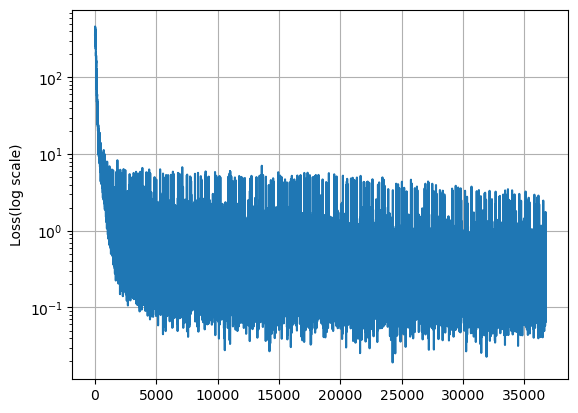

In [24]:
#plt.figure(1, figsize = [20,10])
plt.semilogy(epoch_loss)
plt.ylabel('Loss(log scale)')
plt.grid()

In [25]:
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    test_inputs = torch.tensor(inp_test_data, dtype=torch.float32).to(device)
    test_targets = torch.tensor(out_test_data, dtype=torch.float32).to(device)
    test_outputs = model(test_inputs)
    test_loss = criterion(test_outputs, test_targets)
    print(f'Test Loss: {test_loss.item():.4f}')

Test Loss: 0.0433


C:\Users\sriniva3\AppData\Local\Temp\ipykernel_25872\1681708791.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_inputs = torch.tensor(inp_test_data, dtype=torch.float32).to(device)
C:\Users\sriniva3\AppData\Local\Temp\ipykernel_25872\1681708791.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_targets = torch.tensor(out_test_data, dtype=torch.float32).to(device)


In [26]:
#torch.save(model, 'LSTM.pth')
#torch.save(model.state_dict(), 'LSTM_state_dict.pth')


In [27]:
########## CDF plots ###########
pred = test_outputs.detach().numpy()
tgt = test_targets.detach().numpy()
error = tgt - pred
#pred = pred.flatten()
#tgt = tgt.flatten()
sortd_pred, a_pred = return_cdf(pred[:,0])
sortd_tgt, a_tgt = return_cdf(tgt[:,0])


In [28]:
#plt.plot(sortd_pred, a_pred)
#plt.plot(sortd_tgt, a_tgt, alpha = 0.3)

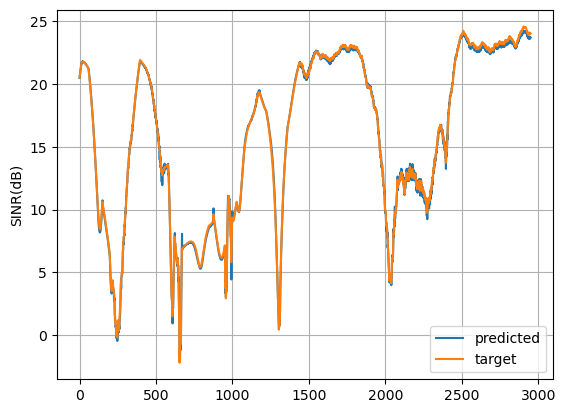

In [29]:
plt.plot(pred[:,0], alpha = 1, label = 'predicted')
plt.plot(tgt[:,0], label = 'target')
plt.legend()
plt.ylabel('SINR(dB)')
plt.grid()
plt.show()

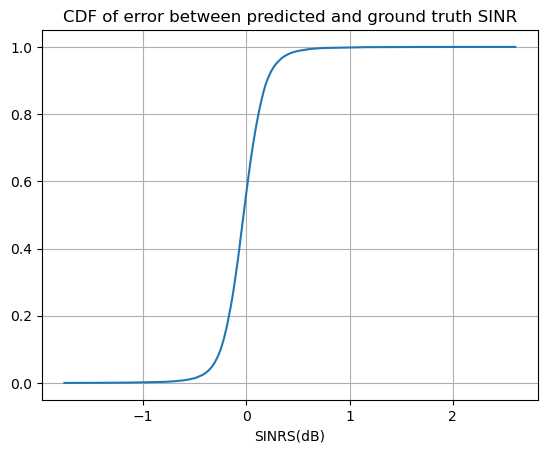

In [30]:
sortd_error, a_error = return_cdf(error.flatten())
plt.plot(sortd_error, a_error)
plt.title('CDF of error between predicted and ground truth SINR')
plt.xlabel('SINRS(dB)')
plt.grid()
plt.show()